# Laboratory #4: Adversarial Learning and OOD Detection

In this laboratory session we will develop a methodology for detecting OOD samples and measuring the quality of OOD detection. We will also experiment with incorporating adversarial examples during training to render models more robust to adversarial attacks.

---
## Exercise 1: OOD Detection and Performance Evaluation
In this first exercise you will build a simple OOD detection pipeline and implement some performance metrics to evaluate its performance.

### Exercise 1.1: Build a simple OOD detection pipeline

Implement an OOD detection pipeline (like in the Flipped Activity notebook) using an ID and an OOD dataset of your choice. Some options:

+ CIFAR-10 (ID), Subset of CIFAR-100 (OOD). You will need to wrap CIFAR-100 in some way to select a subset of classes that are *not* in CIFAR-10 (see `torch.utils.data.Subset`).
+ Labeled Faces in the Wild (ID), CIFAR-10 or FakeData (OOD). The LfW dataset is available in Scikit-learn (see `sklearn.datasets.fetch_lfw_people`).
+ Something else, but if using images keep the images reasonably small!

In this exercise your *OOD Detector* should produce a score representing how "out of distribution" a test sample is. We will implement some metrics in the next exercise, but for now use the techniques from the flipped activity notebook to judge how well OOD scoring is working (i.e. histograms).

**Note**: Make sure you make a validation split of your ID dataset for testing.

In [1]:
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import CIFAR100, CIFAR10
from torchvision.transforms import ToTensor, Compose
import torch
from tqdm import tqdm
import wandb
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class CIFAR100_wrapper(Dataset):

    def __init__(self, classes: set[int], get_train: bool = True) -> None:
        super().__init__()
        self.classes = classes
        cifar = CIFAR100("~/datasets", download=get_train, train=get_train, transform=Compose([ToTensor()]))
        samples = []
        labels = []
        for i in range(len(cifar)):
            if cifar[i][1] in classes:
                samples.append(cifar[i][0])
                labels.append(torch.Tensor([cifar[i][1]]).long())
        self.data = torch.stack(samples)
        self.labels = torch.cat(labels)

    def __len__(self): return len(self.labels)

    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]: return self.data[index], self.labels[index]

index_id = set(range(20))
index_ood = set(range(30, 40))

batch_size=64

c20 = CIFAR100_wrapper(index_id)
c20_train, c20_val = random_split(c20, [0.7, 0.3])
c20_test = CIFAR100_wrapper(index_id)
c20_ood = CIFAR100_wrapper(index_ood)
dl_train = DataLoader(c20_train, batch_size, shuffle=True)
dl_val = DataLoader(c20_val, batch_size, shuffle=True)
dl_test = DataLoader(c20_test, batch_size, shuffle=True)
dl_ood = DataLoader(c20_ood, batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [32]:
@torch.no_grad()
def ood_test(model, dataloader, threshold = 1.):
    max_logits = []
    second_guess = []
    for x, _ in dataloader:
        x = x.to(device)
        logits_sorted, _ = torch.sort(model(x), descending=True)
        max_logits.append(logits_sorted[:, 0])
        second_guess.append(logits_sorted[:, 1])
    max_logits = torch.cat(max_logits)
    second_guess = torch.cat(second_guess)
    return (max_logits - second_guess) > threshold

@torch.no_grad()
def ood_scores(model, dataloader, T = 1):
    max_logits = []
    second_guess = []
    min_logits = []
    for x, _ in dataloader:
        x = x.to(device)
        logits_sorted, _ = torch.sort(model(x), descending=True)
        max_logits.append(logits_sorted[:, 0])
        min_logits.append(logits_sorted[:, -1])
        second_guess.append(logits_sorted[:, 1])
    max_logits = torch.cat(max_logits)
    min_logits = torch.cat(min_logits)
    second_guess = torch.cat(second_guess)
    return min_logits / T, max_logits / T, (max_logits - min_logits) / T, (max_logits - second_guess) / T

def plot_hists(model, dataloader_id, dataloader_ood, T = 1):
    min_l_id, max_l_id, max_min_l_id, max_second_l_id = ood_scores(model, dataloader_id, T)
    min_l_ood, max_l_ood, max_min_l_ood, max_second_l_ood = ood_scores(model, dataloader_ood, T)
    fig, axes = plt.subplots(1, 4, figsize=(20, 4))
    axes[0].hist(min_l_id.cpu(), bins=30, density=True, alpha=0.5, label="ID")
    axes[0].hist(min_l_ood.cpu(), bins=30, density=True, alpha=0.5, label="OOD")
    axes[0].set_title("Min Logits")
    axes[0].legend()

    axes[1].hist(max_l_id.cpu(), bins=30, density=True, alpha=0.5, label="ID")
    axes[1].hist(max_l_ood.cpu(), bins=30, density=True, alpha=0.5, label="OOD")
    axes[1].set_title("Max Logits")
    axes[1].legend()

    axes[2].hist(max_min_l_id.cpu(), bins=30, density=True, alpha=0.5, label="ID")
    axes[2].hist(max_min_l_ood.cpu(), bins=30, density=True, alpha=0.5, label="OOD")
    axes[2].set_title("Max - Min Logits")
    axes[2].legend()

    axes[3].hist(max_second_l_id.cpu(), bins=30, density=True, alpha=0.5, label="ID")
    axes[3].hist(max_second_l_ood.cpu(), bins=30, density=True, alpha=0.5, label="OOD")
    axes[3].set_title("Max - 2nd Max Logits")
    axes[3].legend()
    fig.show()



# Model
Using the model from the flipped classroom just for having a reference point

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# CIFAR10 dataset

In [5]:
cifar = CIFAR10("~/datasets", transform=Compose([ToTensor() # ,
     # Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ]))
c_train, c_val = random_split(cifar, [0.7, 0.3])
dl_train = DataLoader(c_train, batch_size=batch_size, shuffle=True)
dl_val = DataLoader(c_val, batch_size=batch_size, shuffle=True)
dl_test = DataLoader(CIFAR10("~/datasets", train=False, transform=ToTensor()), batch_size=batch_size, shuffle=True)

In [6]:
model = CNN().to(device)
x = torch.rand((16, 3, 32, 32)).to(device)
model(x).shape

torch.Size([16, 10])

## Training

In [7]:
@torch.no_grad()
def validation(model, dataloader, loss_fn):
    model.eval()
    loss = 0
    acc = 0
    for x, y in tqdm(dataloader, "Validation: ", leave=False):
        x, y = x.to(device), y.to(device)
        prediction_logits = model(x)
        loss += loss_fn(prediction_logits, y).item()
        acc += (prediction_logits.argmax(1) == y).float().sum().item()
    return loss / len(dataloader), acc / len(dataloader.dataset)

In [8]:
def training(model, train_dataloader, validation_dataloader, loss_fn, optimizer, epochs, validation_freq, log):
    losses, accs = [], []
    for t in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for x, y in tqdm(train_dataloader, f"Epoch #{t}: ", leave=False):
            x, y = x.to(device), y.to(device)
            prediction_logits = model(x)
            loss = loss_fn(prediction_logits, y)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if t % validation_freq == 0:
            lss, acc = validation(model, validation_dataloader, loss_fn)
            print(f"Loss Train = {train_loss / len(train_dataloader)}, Loss Val = {lss}, Acc = {acc}")
            losses.append(lss)
            accs.append(acc)
            log_dict = {"loss": lss, "accuracy": acc}
            if log:
                wandb.log(log_dict)

    return losses, accs

In [9]:
loss_fn = F.cross_entropy
epochs = 30
optim = torch.optim.Adam(model.parameters(), lr=0.001)
lss, accs = training(model, dl_train, dl_val, loss_fn, optim, epochs, 5, False)

Epoch #1:   0%|          | 0/547 [00:00<?, ?it/s]

Loss Train = 1.3378203215939035, Loss Val = 1.3425358239640581, Acc = 0.5169333333333334


Loss Train = 1.1314385512629201, Loss Val = 1.1985070175312935, Acc = 0.5783333333333334


Loss Train = 1.0055133789723272, Loss Val = 1.1919750880687794, Acc = 0.5841333333333333


Loss Train = 0.9038153392087389, Loss Val = 1.1946265613779108, Acc = 0.5944


Loss Train = 0.825672813263846, Loss Val = 1.1735292772029309, Acc = 0.6080666666666666


Loss Train = 0.7526951426779767, Loss Val = 1.2321783119059624, Acc = 0.6012666666666666


/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


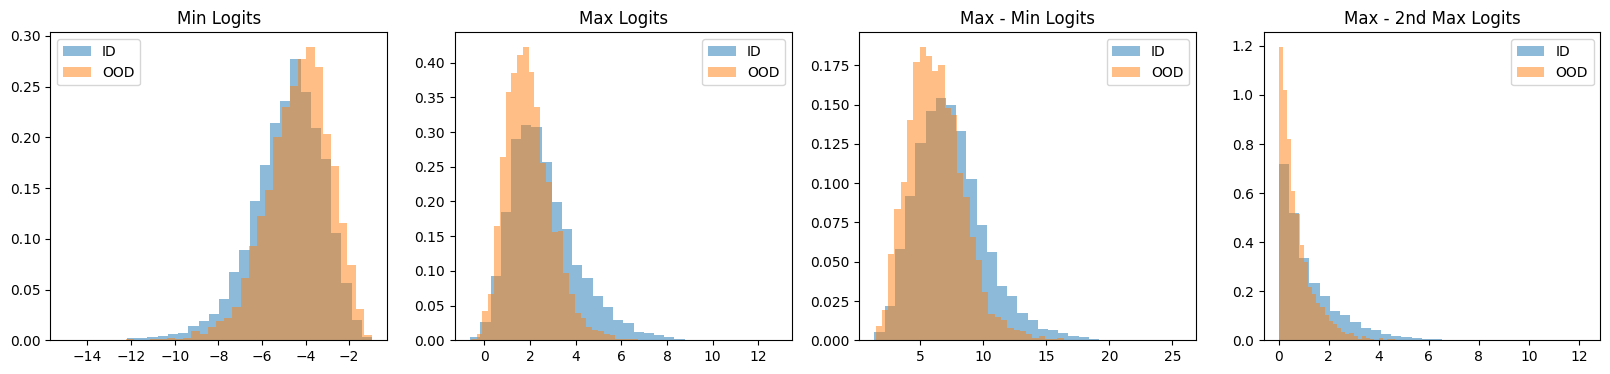

In [33]:
plot_hists(model, dl_test, dl_ood)

### Exercise 1.2: Measure your OOD detection performance

There are several metrics used to evaluate OOD detection performance, we will concentrate on two threshold-free approaches: the area under the Receiver Operator Characteristic (ROC) curve for ID classification, and the area under the Precision-Recall curve for *both* ID and OOD scoring. See [the ODIN paper](https://arxiv.org/pdf/1706.02690.pdf) section 4.3 for a description of OOD metrics.

Use the functions in `sklearn.metrics` to produce ROC and PR curves for your OOD detector. Some useful functions:

+ [`sklearn.metric.RocCurveDisplay.from_predictions`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html)
+ [`sklearn.metrics.PrecisionRecallDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.PrecisionRecallDisplay.html)


In [37]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
@torch.no_grad()
def plot_curves(model, dataloader_id, dataloader_ood, T=None):
    predicted = []
    true = []

    for x, y in dataloader_id:
        x, y = x.to(device), y.to(device)
        predicted.append(model(x).max(1).values if T is None else model(x, T).max(1).values)
        true.append(torch.ones_like(y))

    for x, y in dataloader_ood:
        x, y = x.to(device), y.to(device)
        predicted.append(model(x).max(1).values if T is None else model(x, T).max(1).values)
        true.append(torch.zeros_like(y))

    predicted = torch.cat(predicted).cpu()
    true = torch.cat(true).cpu()
    fpr, tpr, _ = roc_curve(true, predicted)
    precision, recall, _ = precision_recall_curve(true, predicted)
    pr_auc = auc(recall, precision)
    plt.figure()
    plt.plot(fpr, tpr, label=f"ROC curve (AuC = {pr_auc})")
    plt.plot(recall, precision, label=f"PR curve (AuC = {pr_auc})")
    plt.plot([0, 1], [0, 1], color='gray', linestyle='-')
    plt.legend()
    plt.show()

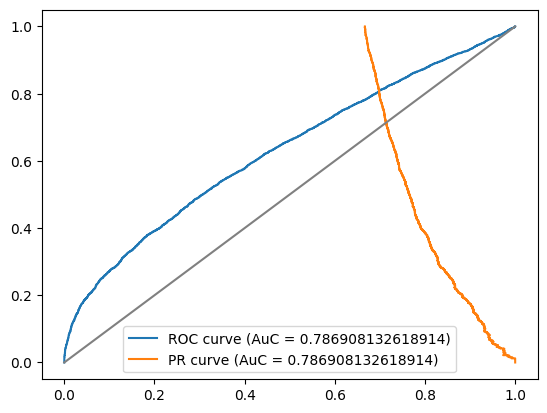

In [35]:
plot_curves(model, dl_test, dl_ood)

In [13]:
# Your code here.
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay, precision_score, recall_score
@torch.no_grad()
def ood_roc_test(model, dataloader_id, dataloader_ood, threshold = 0.4):
    predictions = torch.cat((ood_test(model, dataloader_id, threshold), ood_test(model, dataloader_ood, threshold)), dim=0)
    true_values = torch.cat((torch.ones(len(dataloader_id.dataset)), torch.zeros(len(dataloader_ood.dataset))), dim=0) 
    # print(len(dataloader_ood.dataset), len(dataloader_id.dataset), len(true_values), len(predictions))
    RocCurveDisplay.from_predictions(true_values, predictions.cpu())
    PrecisionRecallDisplay.from_predictions(true_values, predictions.cpu())


---
## Exercise 2: Enhancing Robustness to Adversarial Attack

In this second exercise we will experiment with enhancing our base model to be (more) robust to adversarial attacks. 

### Exercise 2.1: Implement FGSM and generate adversarial examples

Recall that the Fast Gradient Sign Method (FGSM) perturbs samples in the direction of the gradient with respect to the input $\mathbf{x}$:
$$ \boldsymbol{\eta}(\mathbf{x}) = \varepsilon \mathrm{sign}(\nabla_{\mathbf{x}} \mathcal{L}(\boldsymbol{\theta}, \mathbf{x}, y)) ) $$
Implement FGSM and generate some *adversarial examples* using your trained ID model. Evaluate these samples qualitatively and quantitatively. Evaluate how dependent on $\varepsilon$ the quality of these samples are. 

In [14]:
r = torch.randn((10)) * 10
r

tensor([ -8.3070,  -1.5131, -11.6785, -12.1354,  16.9592,  15.5759, -12.1174,
         -6.2331,  -1.3070,  11.5469])

In [15]:
s = r.sign()
s

tensor([-1., -1., -1., -1.,  1.,  1., -1., -1., -1.,  1.])

In [16]:
# Your code here.
def fgs_perturbation(model: torch.nn.Module, batch: torch.Tensor, batch_label: torch.Tensor, loss_fn, epsilon: float = 0.01):
    # gradient wrt input
    batch.requires_grad = True
    model.requires_grad_ = False
    logits = model(batch)
    loss = loss_fn(logits, batch_label)
    loss.backward()
    perturbation = batch.grad.data # gradient
    perturbation = perturbation.sign() # signed gradient
    perturbation = epsilon * perturbation # scaled perturbation
    return perturbation

In [17]:
for x, y in dl_train:
    batch, batch_labels = x, y
    break

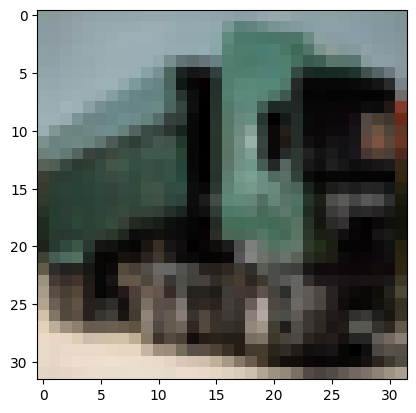

In [18]:
_ = plt.imshow(batch[0].transpose(0, 1).transpose(1, 2))
plt.show()

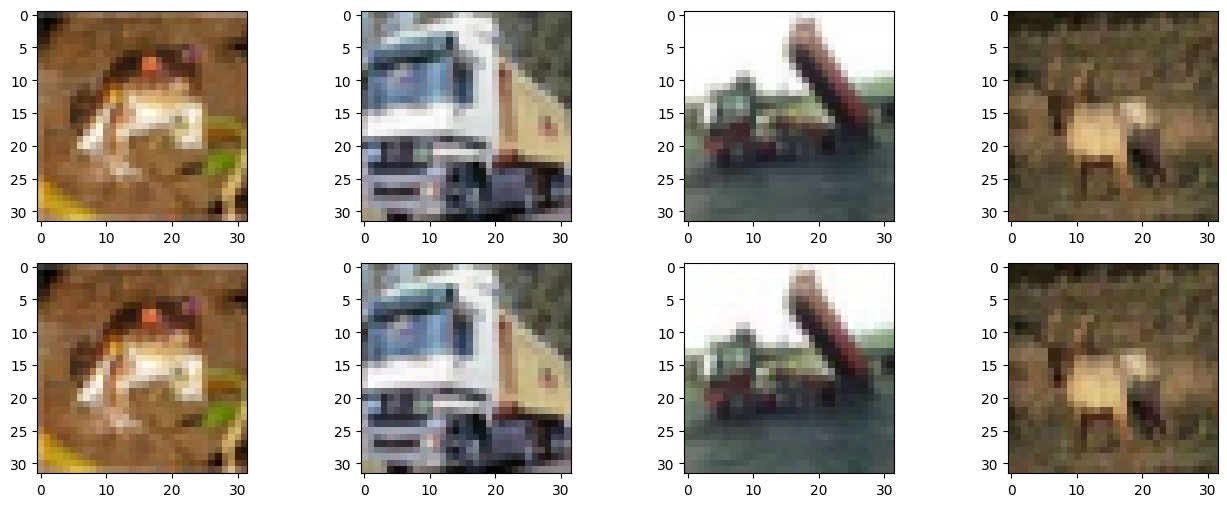

In [19]:
cols = 4
fig, axes = plt.subplots(2, cols, figsize=(16, 6))
for i in range(cols):
    x, y = cifar[i][0].to(device), torch.tensor([cifar[i][1]]).to(device)
    x = x.view(1, *x.shape)
    pert = fgs_perturbation(model, x, y, F.cross_entropy)
    perturbed = (x + pert).clamp(0, 1)
    perturbed = perturbed[0] 
    x = x[0]
    axes[0][i].imshow(x.transpose(0, 1).transpose(1, 2).detach().cpu().numpy())
    axes[1][i].imshow(perturbed.transpose(0, 1).transpose(1, 2).detach().cpu().numpy())
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


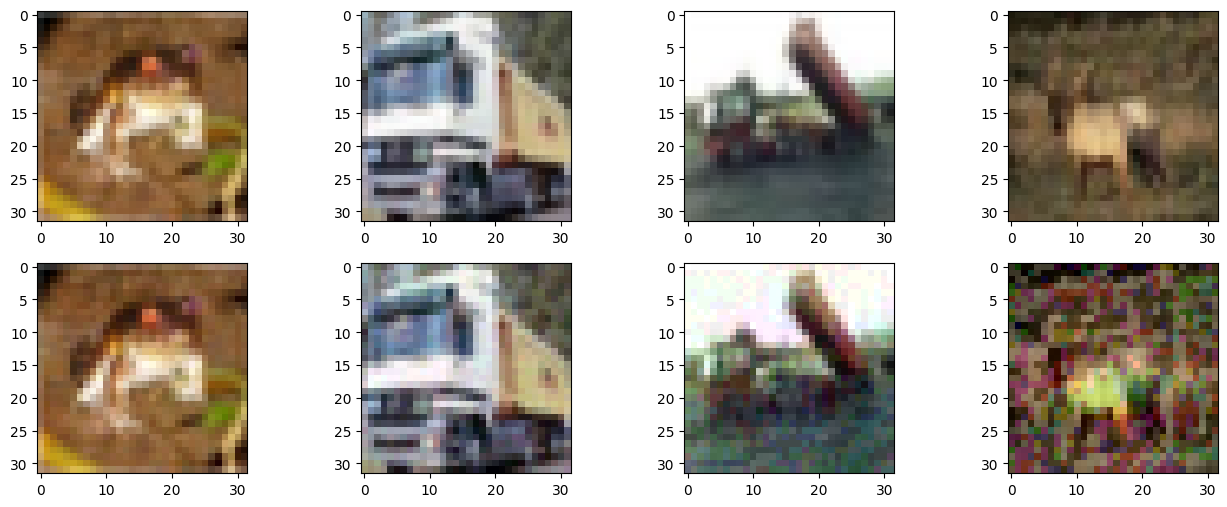

In [20]:
fig, axes = plt.subplots(2, cols, figsize=(16, 6))
epsilons = [0.01, 0.02, 0.05, 0.1]
for i in range(cols):
    x, y = cifar[i][0].to(device), torch.tensor([cifar[i][1]]).to(device)
    x = x.view(1, *x.shape)
    pert = fgs_perturbation(model, x, y, F.cross_entropy, epsilon=epsilons[i])
    perturbed = x + pert
    perturbed = perturbed[0] 
    x = x[0]
    axes[0][i].imshow(x.transpose(0, 1).transpose(1, 2).detach().cpu().numpy())
    axes[1][i].imshow(perturbed.transpose(0, 1).transpose(1, 2).detach().cpu().numpy())
plt.show()

In [21]:
def validation_perturbated(model, dataloader, loss_fn):
    model.eval()
    loss = 0
    acc = 0
    for x, y in tqdm(dataloader, "Validation: ", leave=False):
        x, y = x.to(device), y.to(device)
        pert = fgs_perturbation(model, x, y, loss_fn, 0.)
        x = x + pert
        prediction_logits = model(x)
        loss += loss_fn(prediction_logits, y).item()
        acc += (prediction_logits.argmax(1) == y).float().sum().item()
    return loss / len(dataloader), acc / len(dataloader.dataset)

validation_perturbated(model, dl_test, F.cross_entropy)

(1.2622050794826192, 0.6)

In [22]:
perturbed.shape

torch.Size([3, 32, 32])

### Exercise 2.2: Augment training with adversarial examples

Use your implementation of FGSM to augment your training dataset with adversarial samples. Ideally, you should implement this data augmentation *on the fly* so that the adversarial samples are always generated using the current model. Evaluate whether the model is more (or less) robust to ID samples using your OOD detection pipeline and metrics you implemented in Exercise 1.

In [23]:
# Your code here.
def augment_batch(model, batch, batch_labels, loss, epsilon=0.01):
    pert = fgs_perturbation(model, batch, batch_labels, loss, epsilon)
    augmented_data = batch + pert
    batch = torch.cat([batch, augmented_data], dim=0)
    batch_labels = torch.cat([batch_labels, batch_labels], dim=0)
    return batch, batch_labels

batch, batch_labels = batch.to(device), batch_labels.to(device)
aug, aug_l = augment_batch(model, batch, batch_labels, F.cross_entropy)
print(batch.shape, aug.shape)

torch.Size([64, 3, 32, 32]) torch.Size([128, 3, 32, 32])


In [24]:
# NOTE  l'augment fatto in questo modo implica che il batch size effettivo è doppio rispetto a quello dichiarato (=64) 
def training_with_augment(model, train_dataloader, validation_dataloader, loss_fn, optimizer, epochs, validation_freq, log):
    losses, accs = [], []
    for t in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for x, y in tqdm(train_dataloader, f"Epoch #{t}: ", leave=False):
            x, y = x.to(device), y.to(device)
            x, y = augment_batch(model, x, y, loss_fn)
            prediction_logits = model(x)
            loss = loss_fn(prediction_logits, y)
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if t % validation_freq == 0:
            lss, acc = validation(model, validation_dataloader, loss_fn)
            print(f"Loss Train = {train_loss / len(train_dataloader)}, Loss Val = {lss}, Acc = {acc}")
            losses.append(lss)
            accs.append(acc)
            log_dict = {"loss": lss, "accuracy": acc}
            if log:
                wandb.log(log_dict)

    return losses, accs

In [25]:
loss_fn = F.cross_entropy
model = CNN().to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
lss, accs = training_with_augment(model, dl_train, dl_val, loss_fn, optim, epochs, 5, False)

Epoch #1:   4%|▍         | 24/547 [00:00<00:08, 60.97it/s]

Loss Train = 1.551091640261453, Loss Val = 1.3947351917307427, Acc = 0.49906666666666666


Loss Train = 1.4301658633422154, Loss Val = 1.3048814400713495, Acc = 0.5372666666666667


Loss Train = 1.3564873434725802, Loss Val = 1.238546632452214, Acc = 0.5594666666666667


Loss Train = 1.3044480736992259, Loss Val = 1.2224353942465276, Acc = 0.5642


Loss Train = 1.2570253028730152, Loss Val = 1.1823539368649747, Acc = 0.5780666666666666


Loss Train = 1.2192755945203946, Loss Val = 1.1829280417016212, Acc = 0.5802


/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


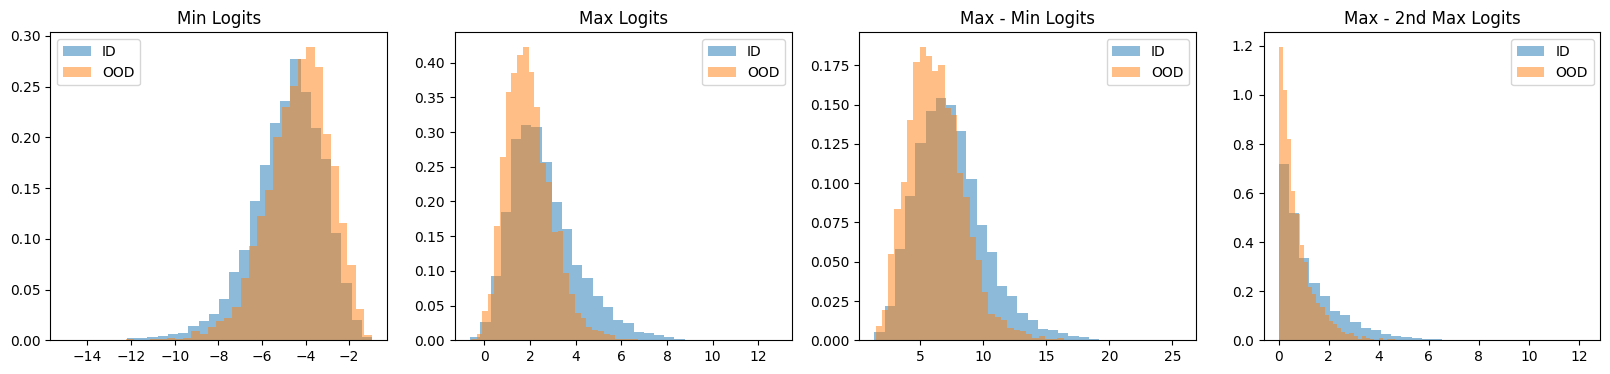

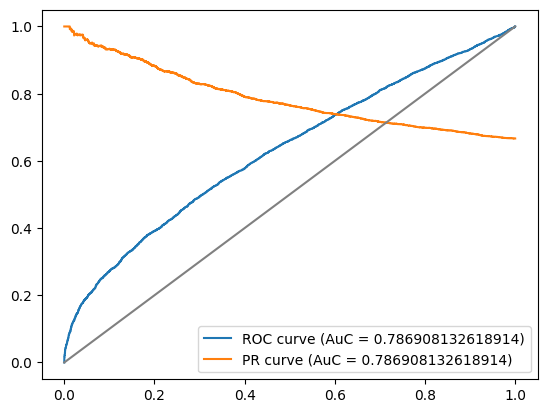

In [38]:
plot_hists(model, dl_test, dl_ood)
plot_curves(model, dl_test, dl_ood)

---
## Exercise 3: Wildcard

You know the drill. Pick *ONE* of the following exercises to complete.

### Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

### Exercise 3.2: Implement JARN
In exercise 2.2 you already implemented Jacobian-regularized learning to make your model more robust to adversarial samples. Add a *discriminator* to your model to encourage the adversarial samples used for regularization to be more *salient*.

See [the JARN paper](https://arxiv.org/abs/1912.10185) for more details.

### Exercise 3.3: Experiment with *targeted* adversarial attacks
Implement the targeted Fast Gradient Sign Method to generate adversarial samples that *imitate* samples from a specific class. Evaluate your adversarial samples qualitatively and quantitatively.

## Exercise 3.1: Implement ODIN for OOD detection
ODIN is a very simple approach, and you can already start experimenting by implementing a temperature hyperparameter in your base model and doing a grid search on $T$ and $\varepsilon$.

In [27]:
class CifarClassifierWithODIN(nn.Module):

    def __init__(self, n_classes) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=2)
        self.dropout1 = nn.Dropout()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=2)
        self.dropout2 = nn.Dropout()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.head = nn.Sequential(nn.Linear(784*2, 1000), nn.ReLU(), nn.Linear(1000, n_classes))

    def forward(self, X, T = 1):
        X = F.relu(self.dropout1(self.conv1(X)))
        X = self.pool1(X)
        X = F.relu(self.dropout2(self.conv2(X)))
        X = self.pool2(X)
        X = self.flatten(X)
        return self.head(X) / T

In [28]:
# Your code here.

def odin_perturbation(model: torch.nn.Module, batch: torch.Tensor, epsilon: float = 0.01):
    # gradient wrt input
    batch.requires_grad = True
    model.requires_grad_ = False
    logits = model(batch)
    probabilities, _ = torch.max(F.log_softmax(logits, dim=1), dim=1)
    probabilities.sum().backward()

    perturbation = -batch.grad.data # gradient
    perturbation = perturbation.sign() # signed gradient
    perturbation = epsilon * perturbation # scaled perturbation
    return perturbation

def odin_augment(model, batch, epsilon=0.01):
    pert = odin_perturbation(model, batch, epsilon)
    augmented_data = batch - pert
    # batch = torch.cat([batch, augmented_data], dim=0)
    # batch_labels = torch.cat([batch_labels, batch_labels], dim=0)
    return augmented_data

In [29]:
def ood_odin_classication(model, dataloader, temperature, threshold = .3):
    probs = []
    for x, _ in dataloader:
        x = x.to(device)
        x = odin_augment(model, x)
        prob, _ = torch.max(F.softmax(model(x, temperature), dim=1), dim=1)
        probs.append(prob)
    probs = torch.cat(probs, dim=0)
    return probs > threshold


In [30]:
# Your code here.
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay
def ood_odin_test(model, dataloader_id, dataloader_ood, temperature, threshold):
    predictions = torch.cat((ood_odin_classication(model, dataloader_id, temperature, threshold), ood_odin_classication(model, dataloader_ood, temperature, threshold)), dim=0)
    true_values = torch.cat((torch.ones(len(dataloader_id.dataset)), torch.zeros(len(dataloader_ood.dataset))), dim=0).to(device)
    # print(len(dataloader_ood.dataset), len(dataloader_id.dataset), len(true_values), len(predictions))
    # compute true positive and false positive
    tp = (predictions == 1) * (true_values == 1)
    fp = (predictions == 1) * (true_values == 0)

    # compute true negative and false negative
    tn = (predictions == 0) * (true_values == 0)
    fn = (predictions == 0) * (true_values == 1)
    return tp.sum().item(), fp.sum().item(), tn.sum().item(), fn.sum().item()
    # RocCurveDisplay.from_predictions(true_values, predictions.cpu(), name=f"T={temperature}, eps={threshold}")
    # PrecisionRecallDisplay.from_predictions(true_values, predictions.cpu())

In [31]:
n_classes = 10
epochs = 30
odin_model = CifarClassifierWithODIN(n_classes).to(device)
optimizer = torch.optim.Adam(odin_model.parameters(), lr=0.001)
loss = F.cross_entropy
training(odin_model, dl_train, dl_val, loss, optimizer, epochs, 5, False)

Epoch #1:   3%|▎         | 15/547 [00:00<00:10, 51.38it/s]

Loss Train = 0.9521176880412825, Loss Val = 1.2686382790829274, Acc = 0.6282666666666666


Loss Train = 0.6054534459898633, Loss Val = 1.062013294595353, Acc = 0.6515333333333333


Loss Train = 0.3799963714980556, Loss Val = 0.9742335984047423, Acc = 0.6732666666666667


Loss Train = 0.2612934587097691, Loss Val = 1.0266069518758896, Acc = 0.6467333333333334


Loss Train = 0.1970741653123656, Loss Val = 1.0251088527922934, Acc = 0.6513333333333333


Loss Train = 0.17910234163935812, Loss Val = 1.0647677502733597, Acc = 0.6484


([1.2686382790829274,
  1.062013294595353,
  0.9742335984047423,
  1.0266069518758896,
  1.0251088527922934,
  1.0647677502733597],
 [0.6282666666666666,
  0.6515333333333333,
  0.6732666666666667,
  0.6467333333333334,
  0.6513333333333333,
  0.6484])

Epoch #1:   1%|          | 6/547 [00:00<00:10, 53.98it/s]

Loss Train = 0.9668471078768073, Loss Val = 1.2853239556576344, Acc = 0.6451333333333333


Loss Train = 0.6686501981898243, Loss Val = 1.0884195725968544, Acc = 0.6721333333333334


Loss Train = 0.46714132275071396, Loss Val = 0.9905779541806972, Acc = 0.6749333333333334


Loss Train = 0.3396518495499107, Loss Val = 0.9688440731231203, Acc = 0.6710666666666667


Loss Train = 0.27573606471311457, Loss Val = 0.9610092132649524, Acc = 0.6726666666666666


Loss Train = 0.22643412321370088, Loss Val = 1.006877016260269, Acc = 0.6606666666666666


/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


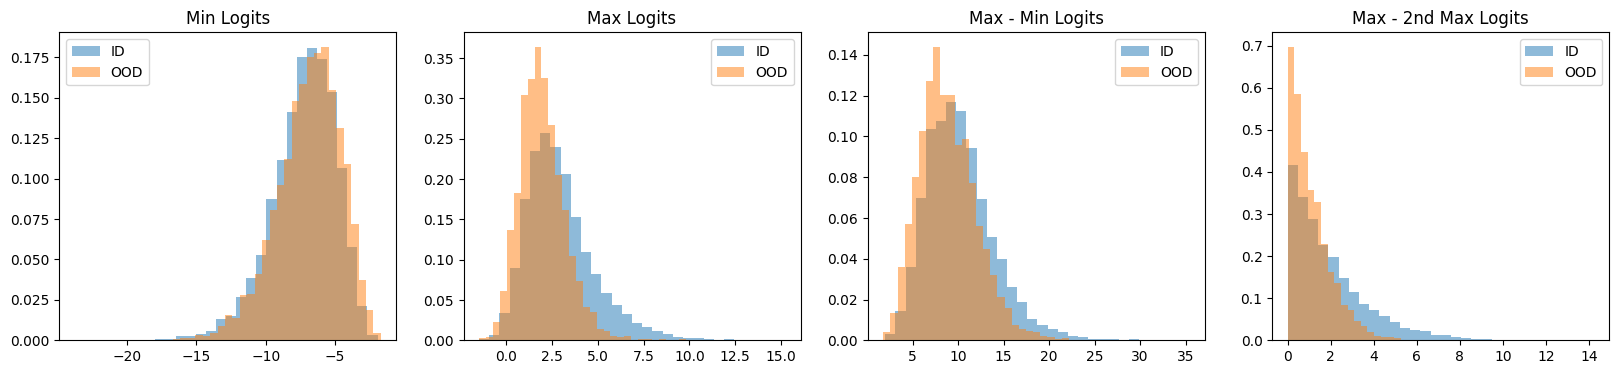

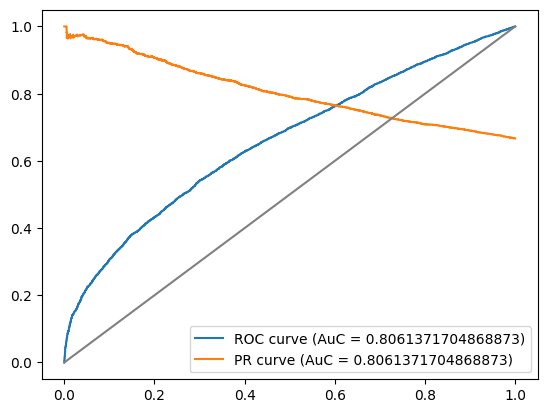

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


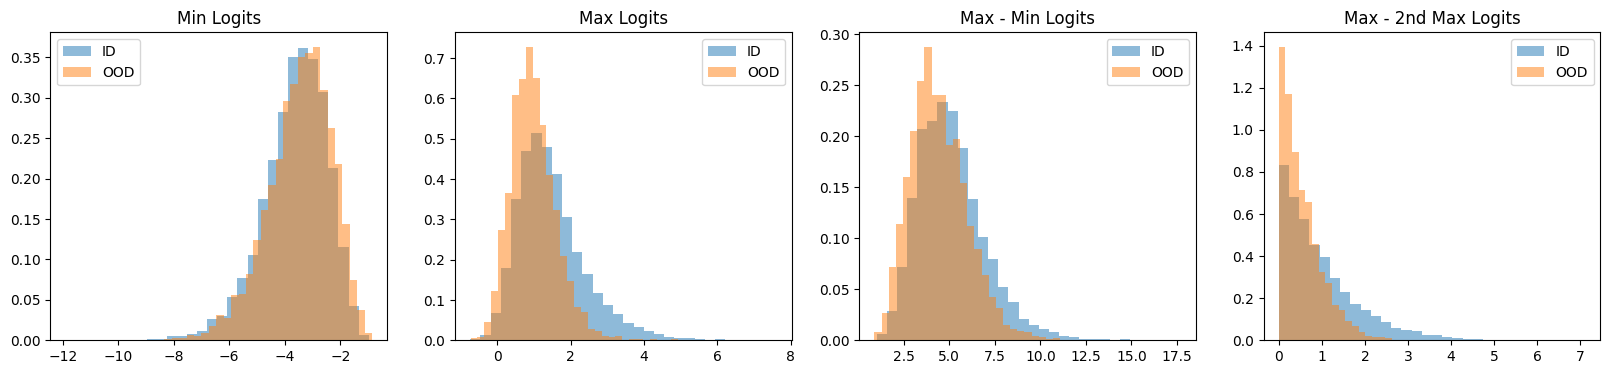

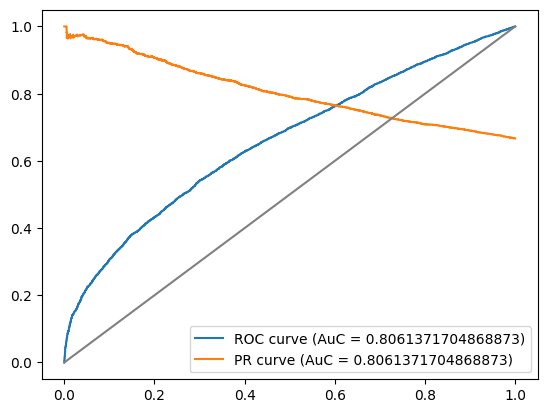

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


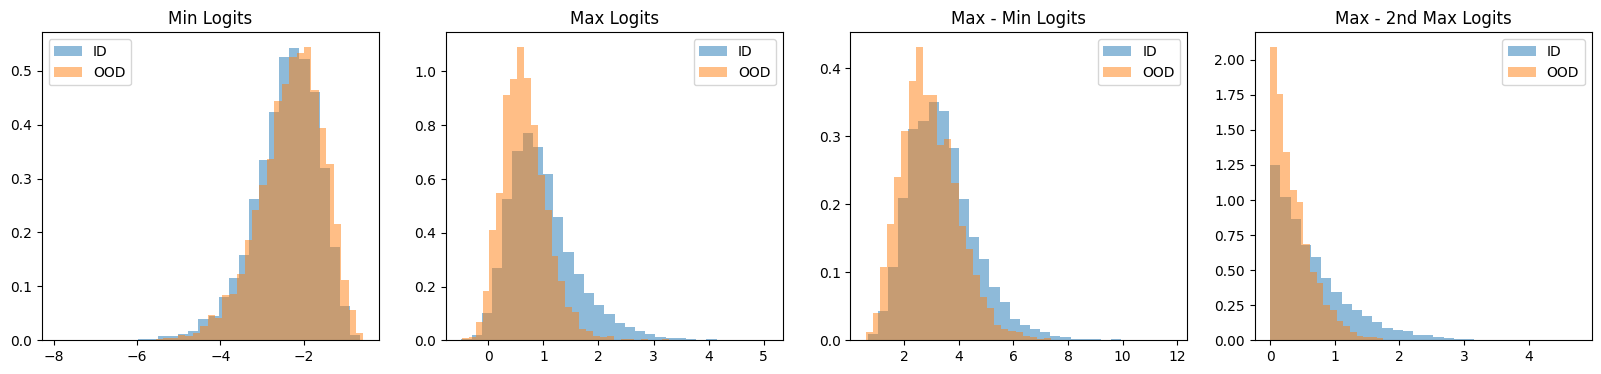

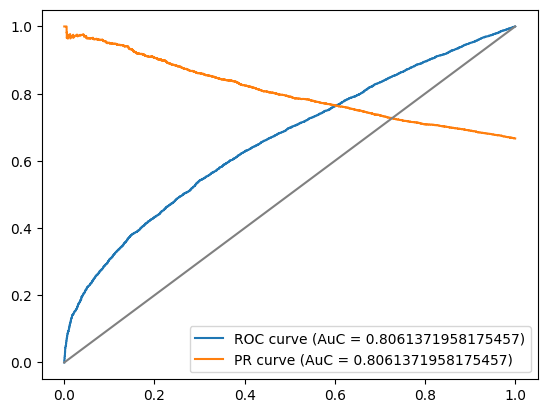

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


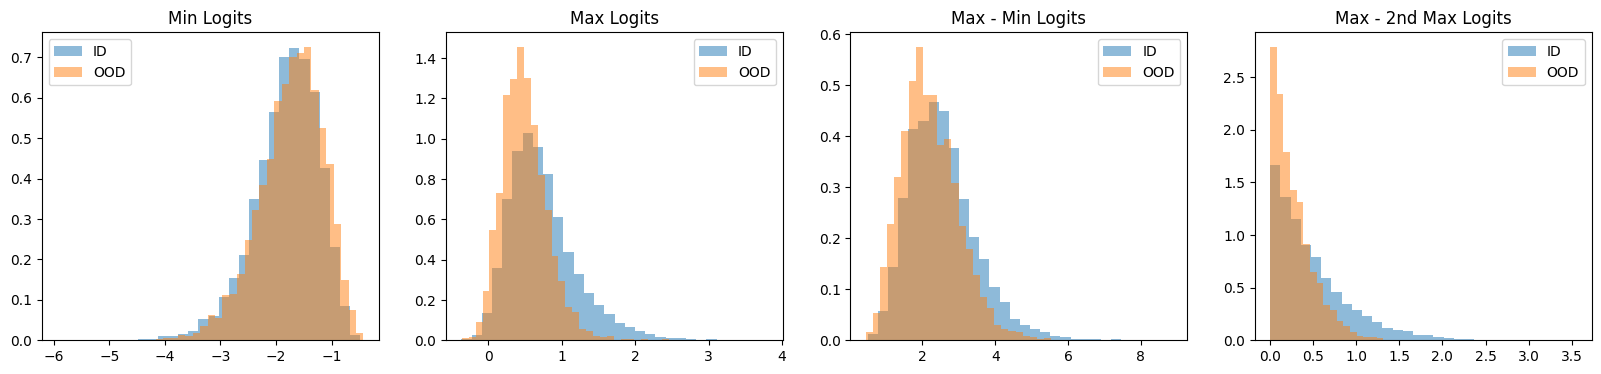

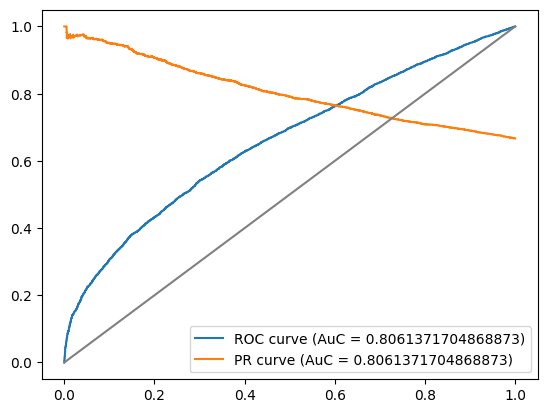

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


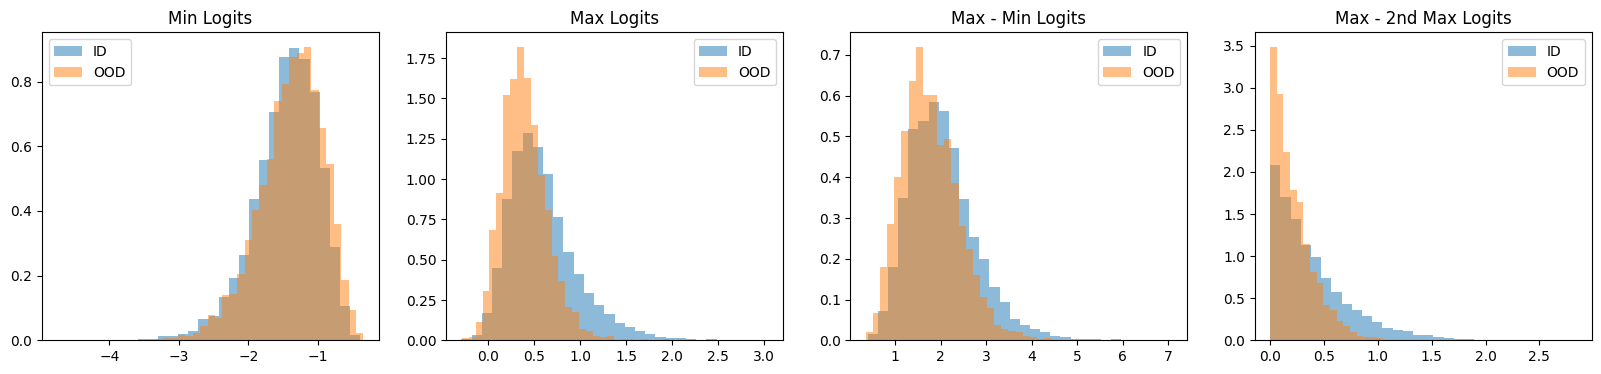

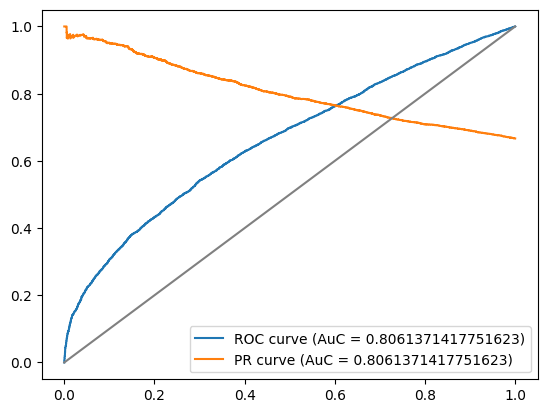

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


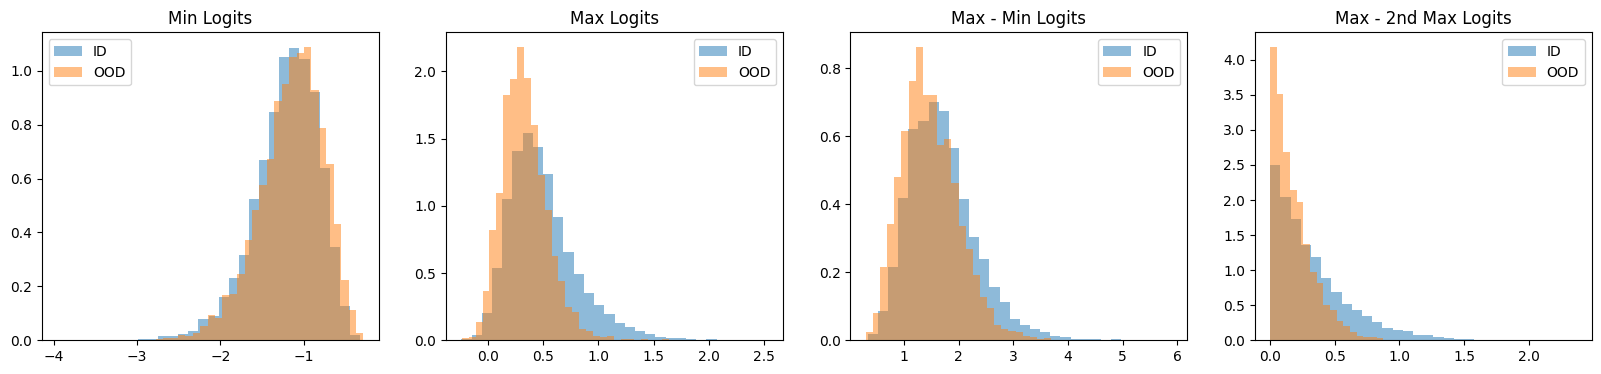

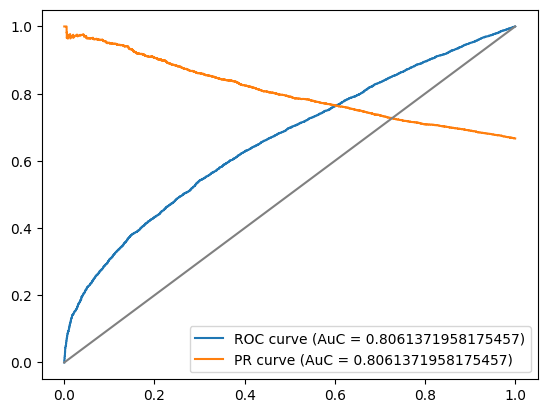

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


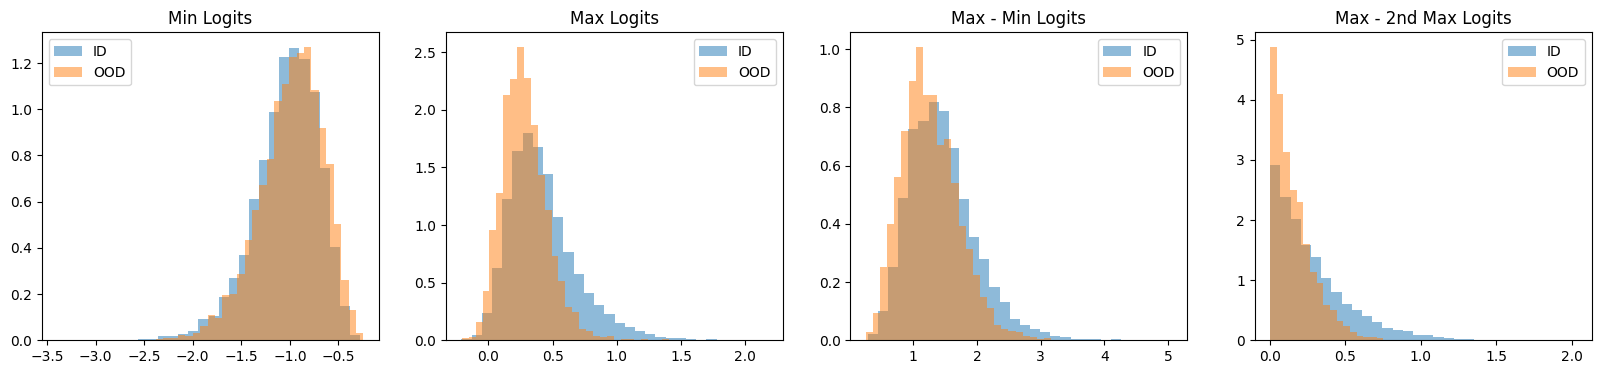

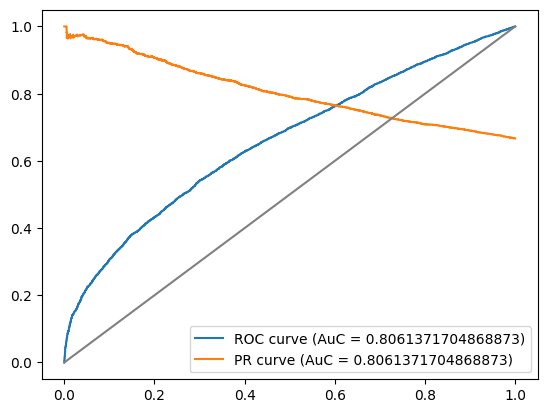

Loss Train = 0.9493372445786457, Loss Val = 1.3081385921924673, Acc = 0.5880666666666666


Loss Train = 0.5866319652667211, Loss Val = 1.1133183575691061, Acc = 0.6248666666666667


Loss Train = 0.35984604790725044, Loss Val = 1.00334949747045, Acc = 0.6612666666666667


Loss Train = 0.2473977791789027, Loss Val = 1.1020573156945248, Acc = 0.6258666666666667


Loss Train = 0.1928643219350025, Loss Val = 1.0704977213068212, Acc = 0.6447333333333334


Loss Train = 0.15082516640397486, Loss Val = 1.115516331855287, Acc = 0.6381333333333333


/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


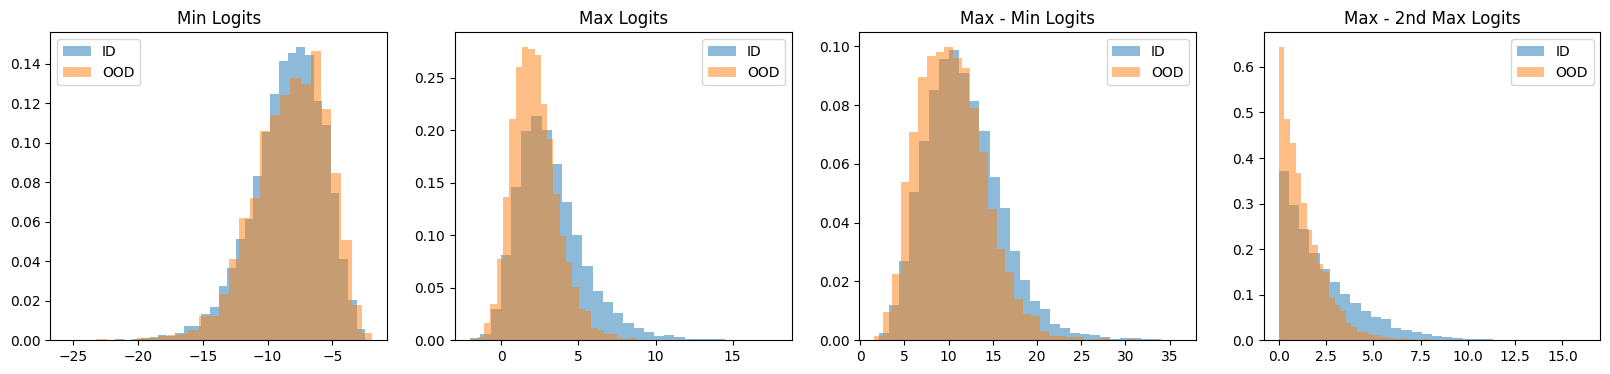

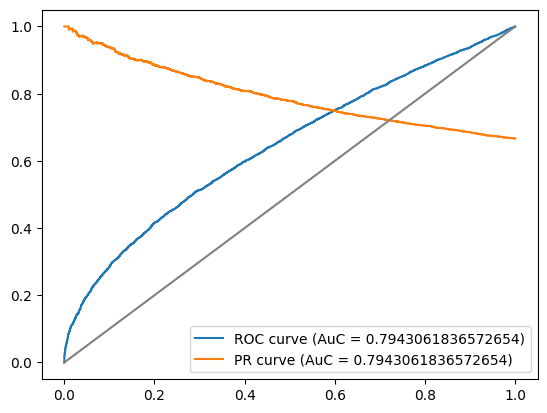

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


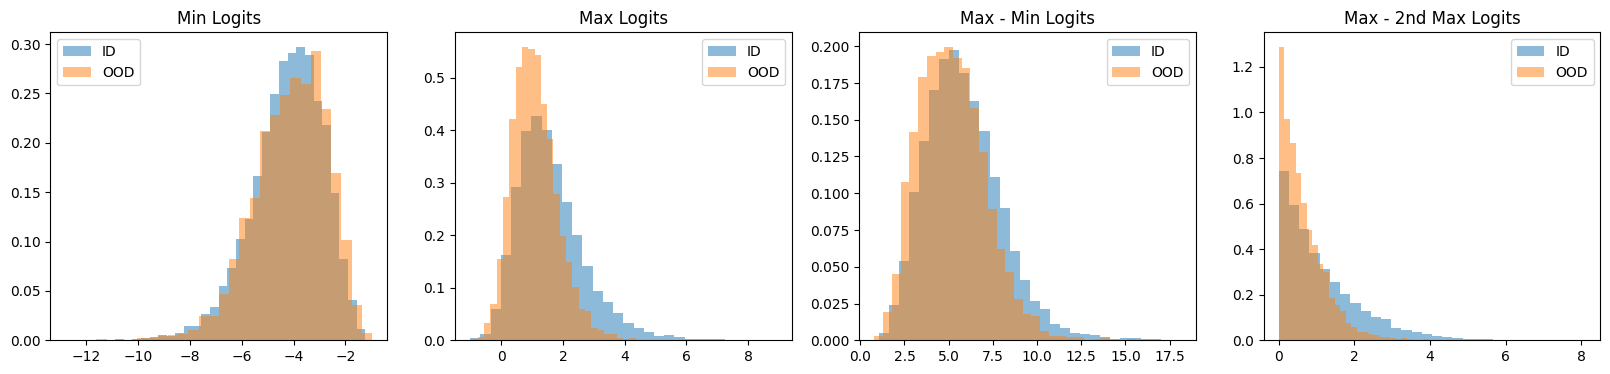

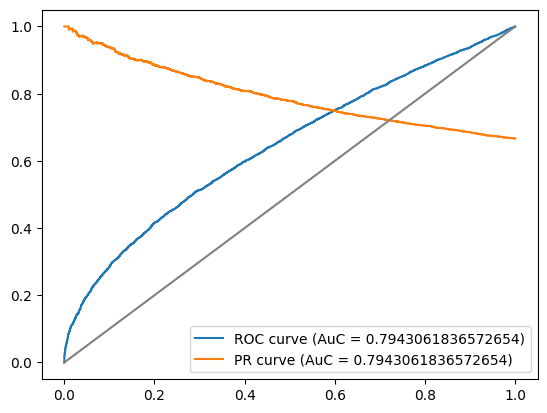

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


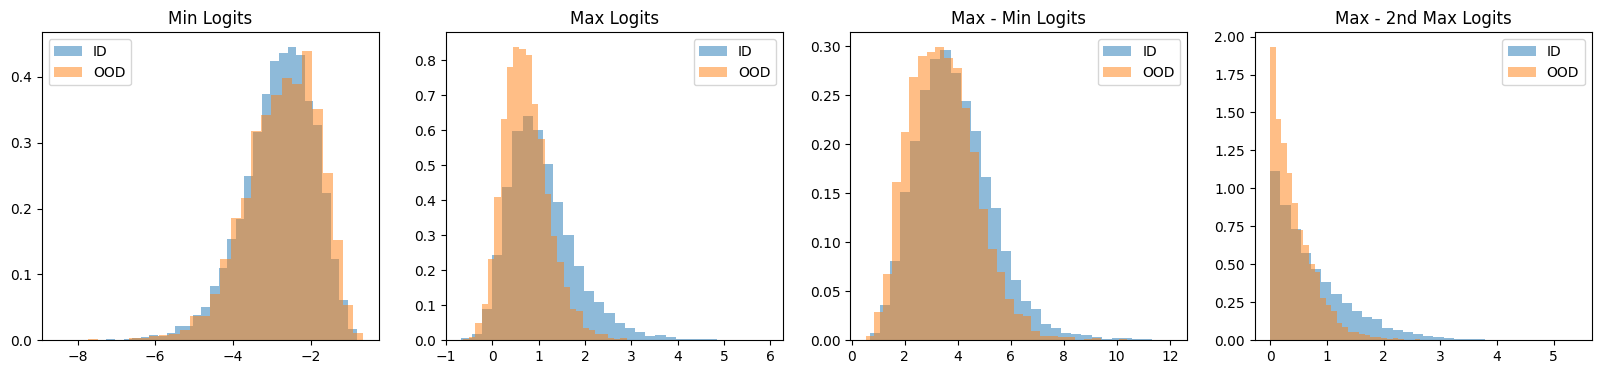

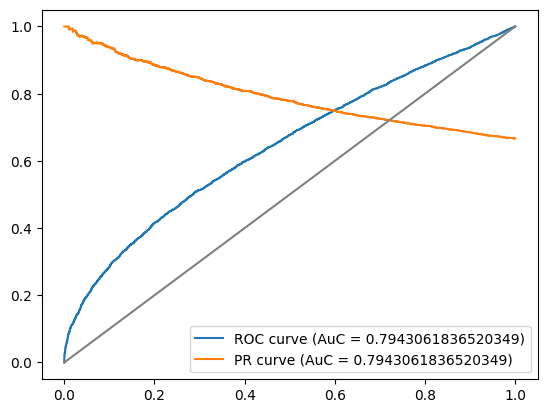

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


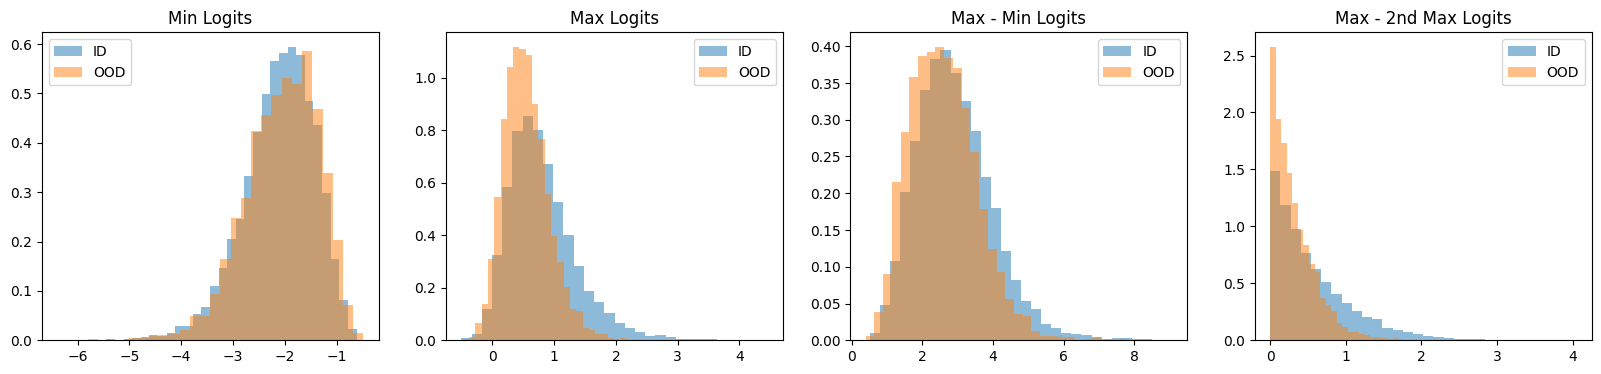

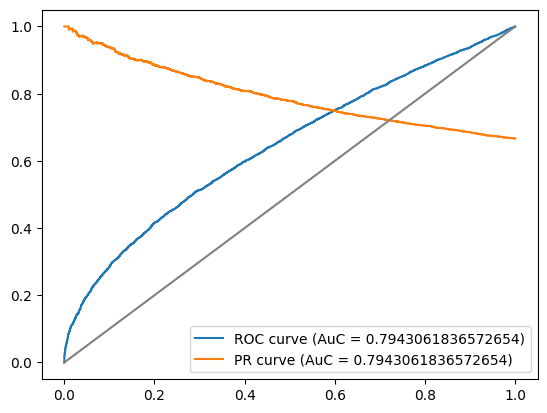

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


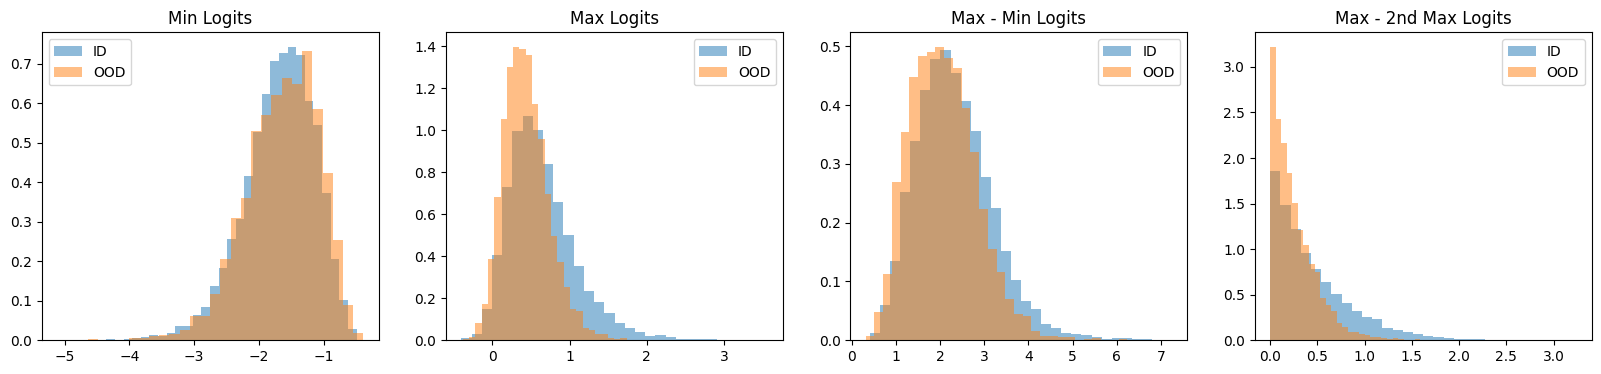

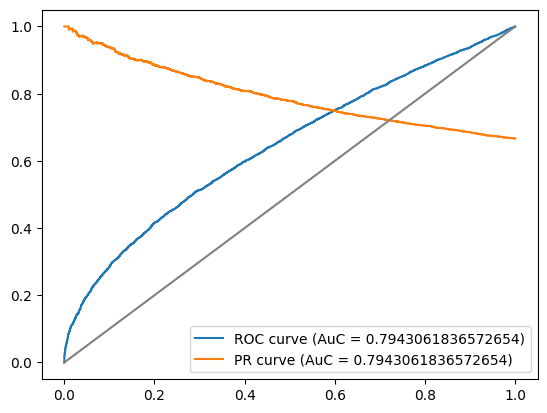

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


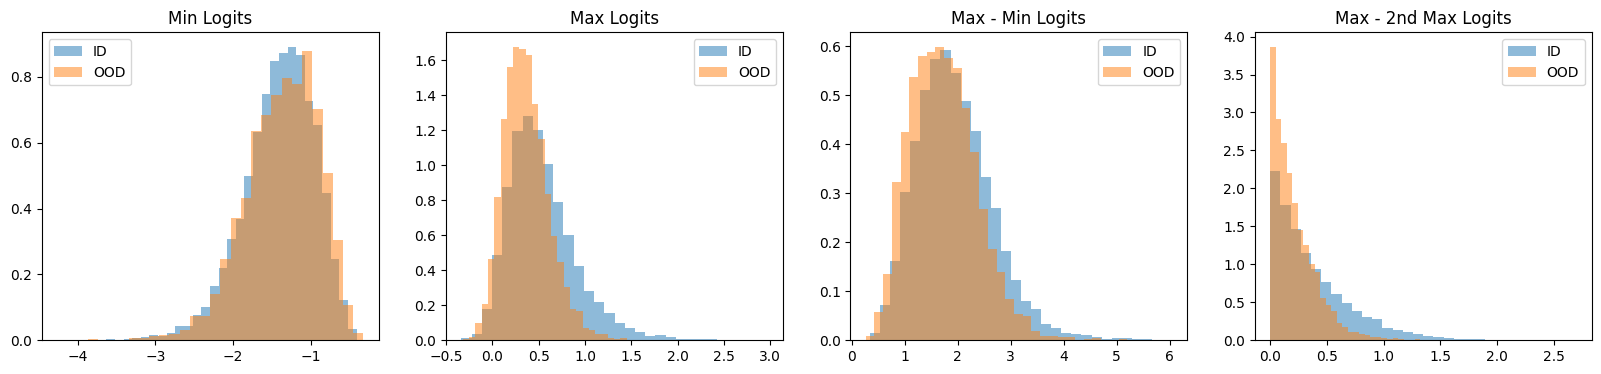

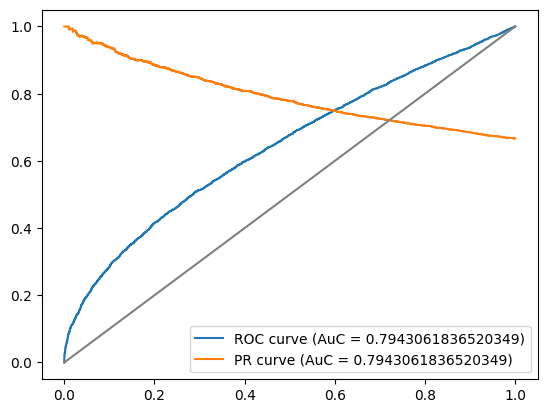

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


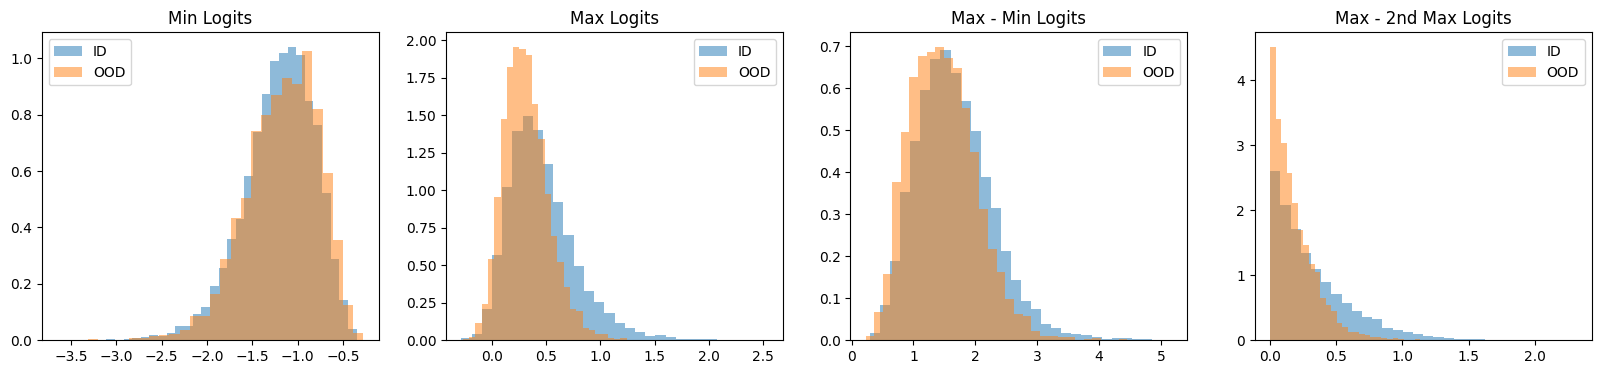

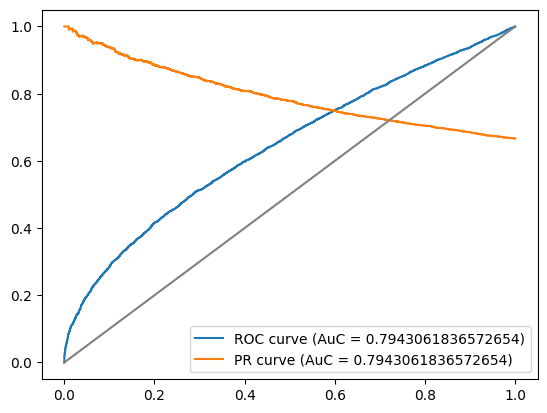

Loss Train = 0.9899588095422637, Loss Val = 1.3067140837933156, Acc = 0.6196666666666667


Loss Train = 0.6449053644371207, Loss Val = 1.1166692596800785, Acc = 0.6428666666666667


Loss Train = 0.40958984967123657, Loss Val = 1.0312119778166426, Acc = 0.6554


Loss Train = 0.2781179509035412, Loss Val = 1.0453431367874146, Acc = 0.6398


Loss Train = 0.2178738528430135, Loss Val = 1.0456002905013713, Acc = 0.6476


Loss Train = 0.19354034650396604, Loss Val = 1.0594264763466856, Acc = 0.6469333333333334


/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


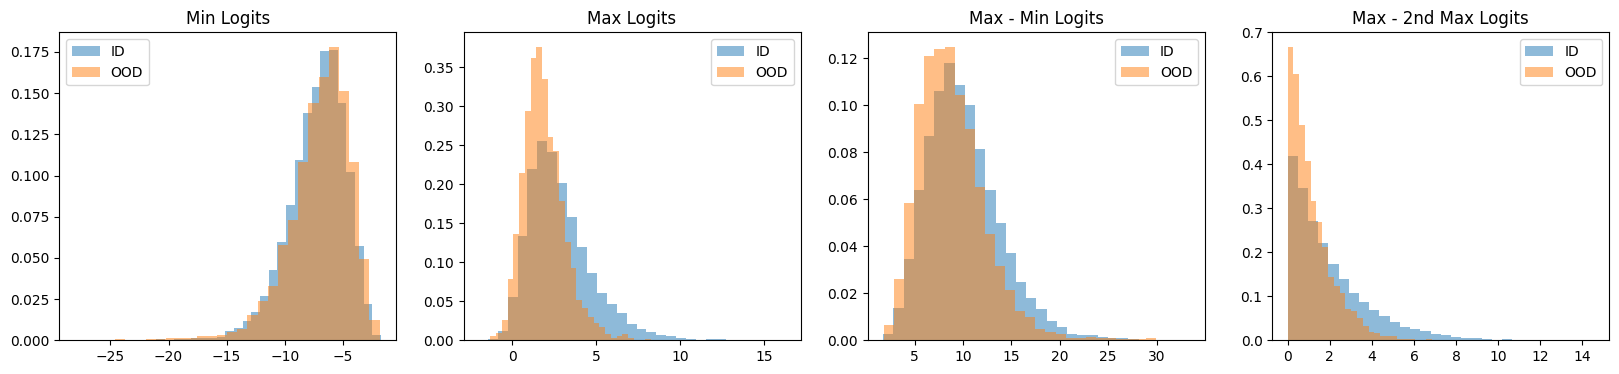

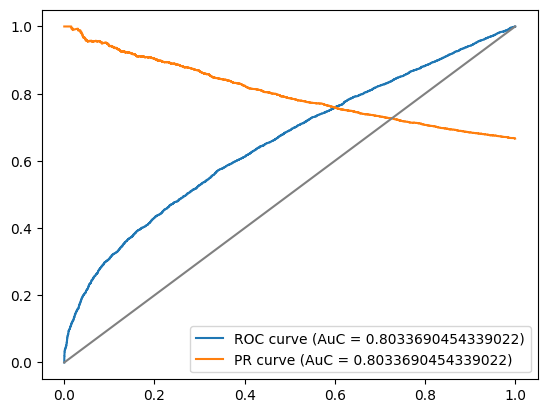

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


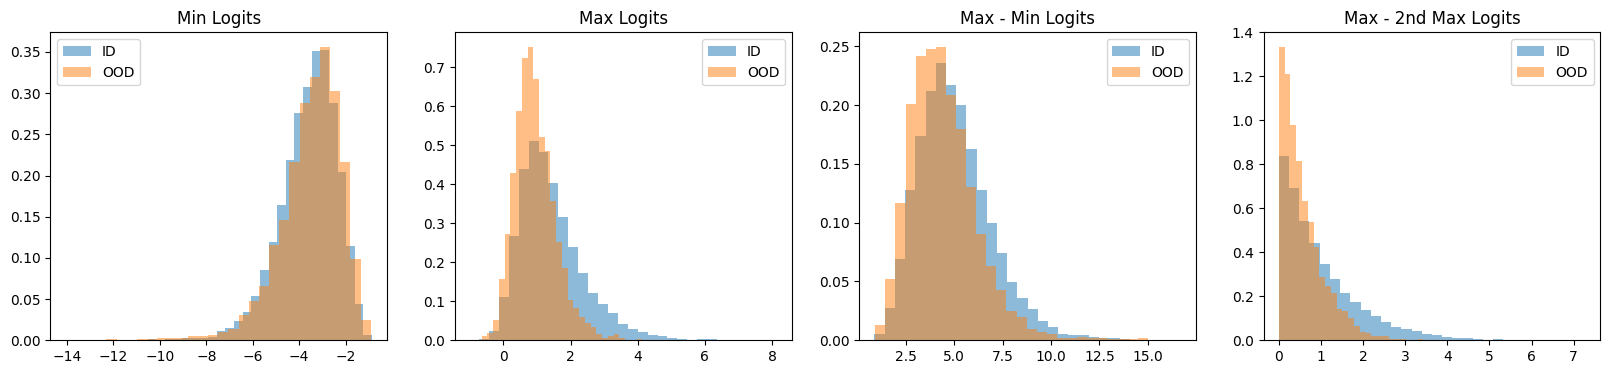

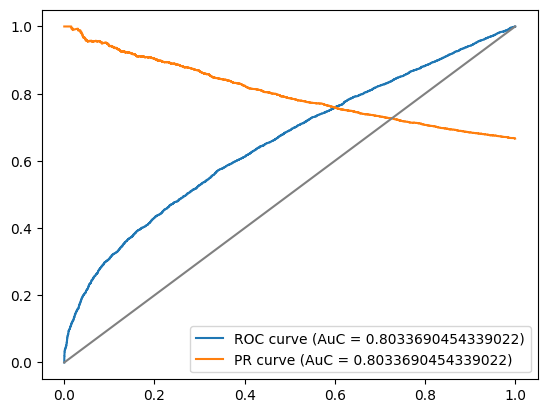

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


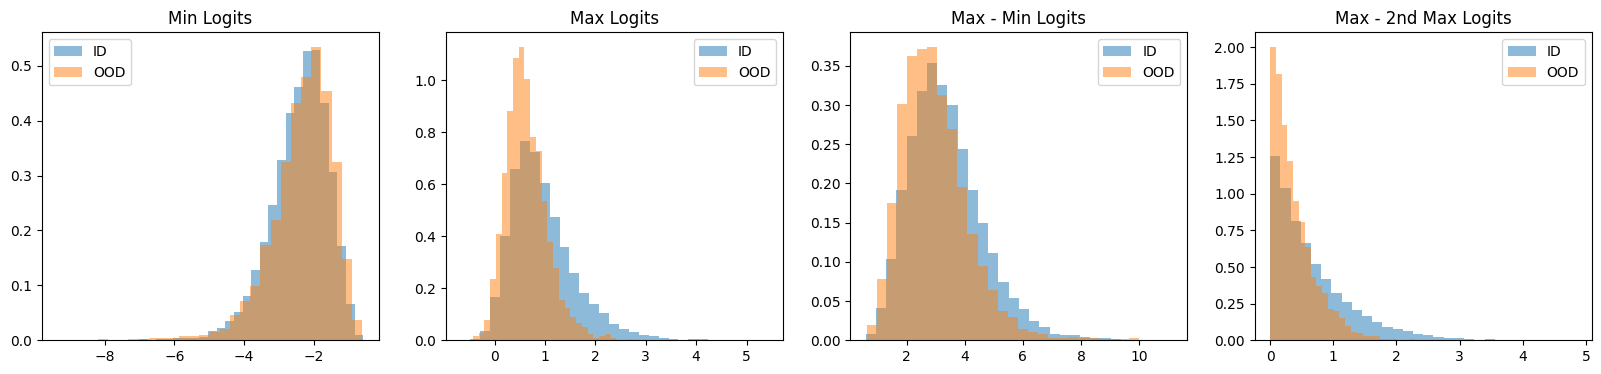

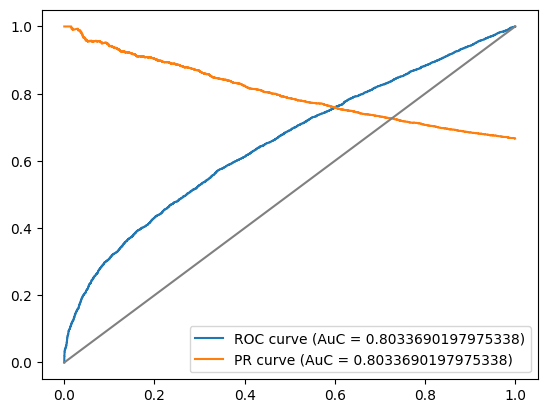

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


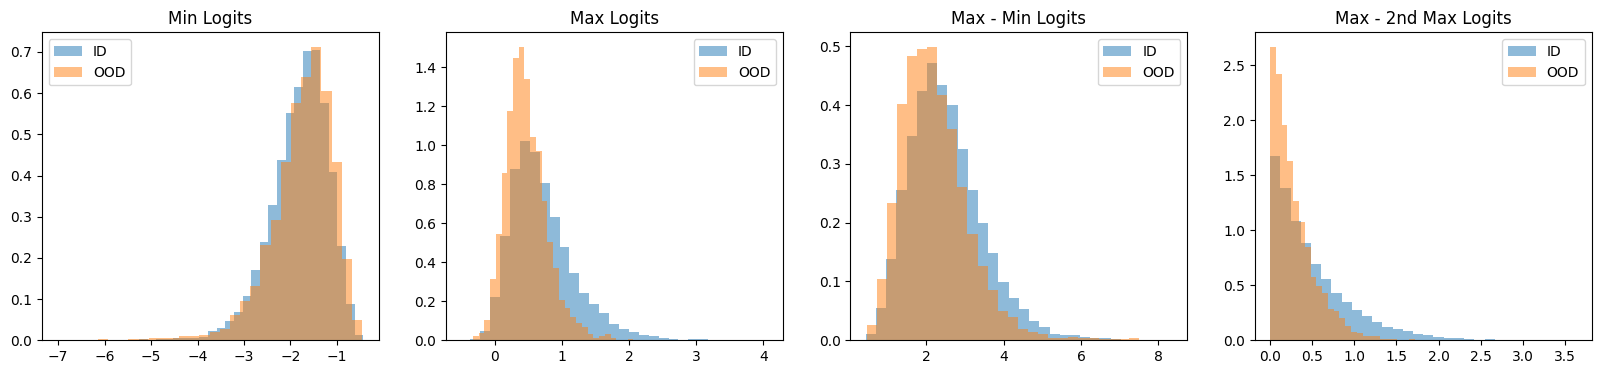

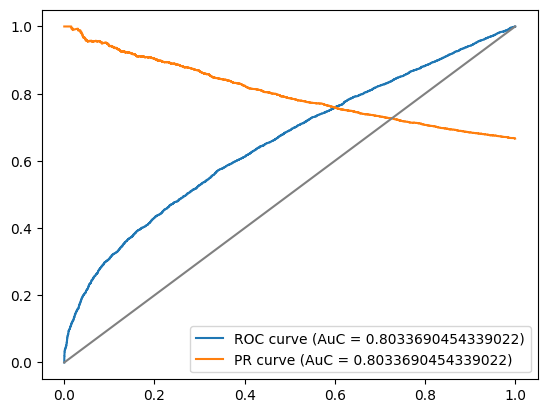

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


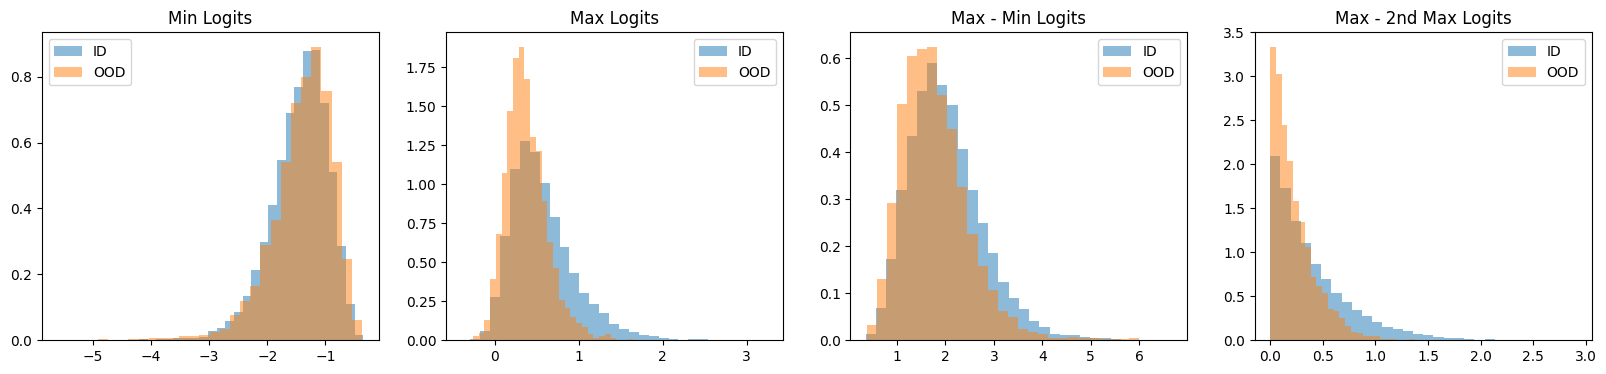

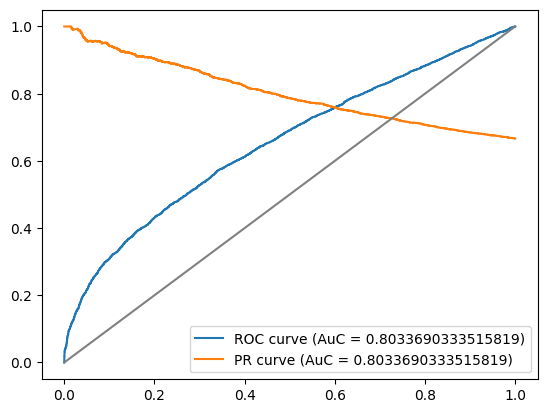

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


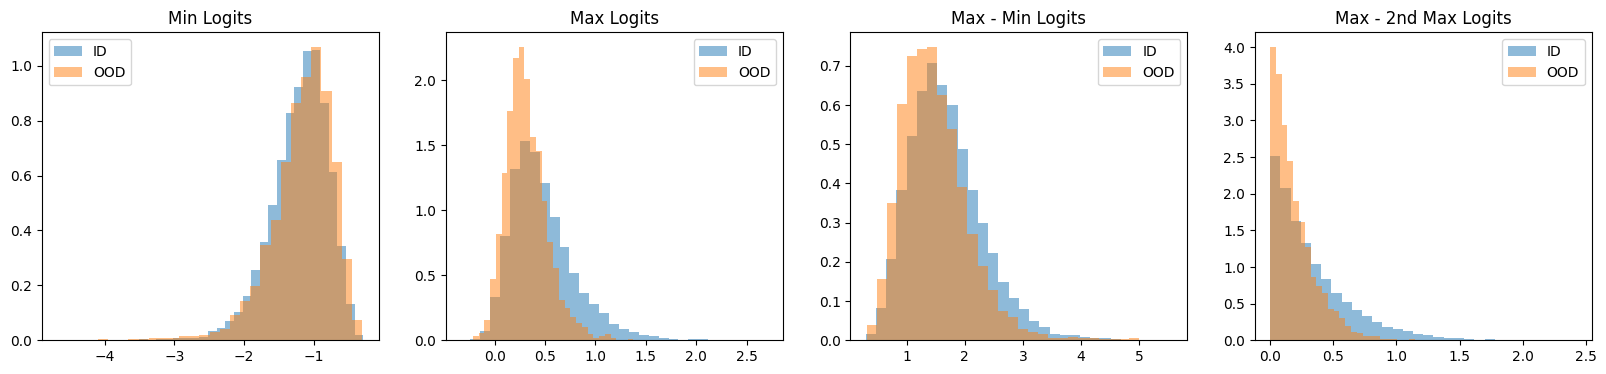

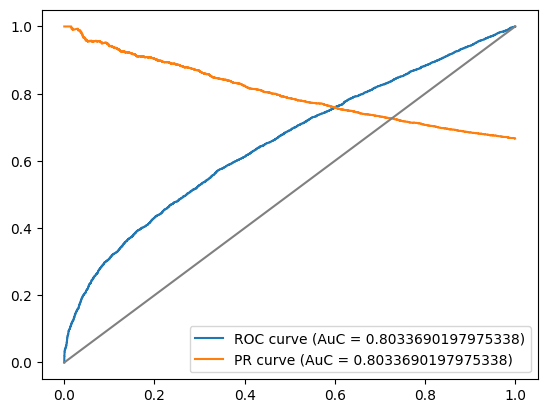

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


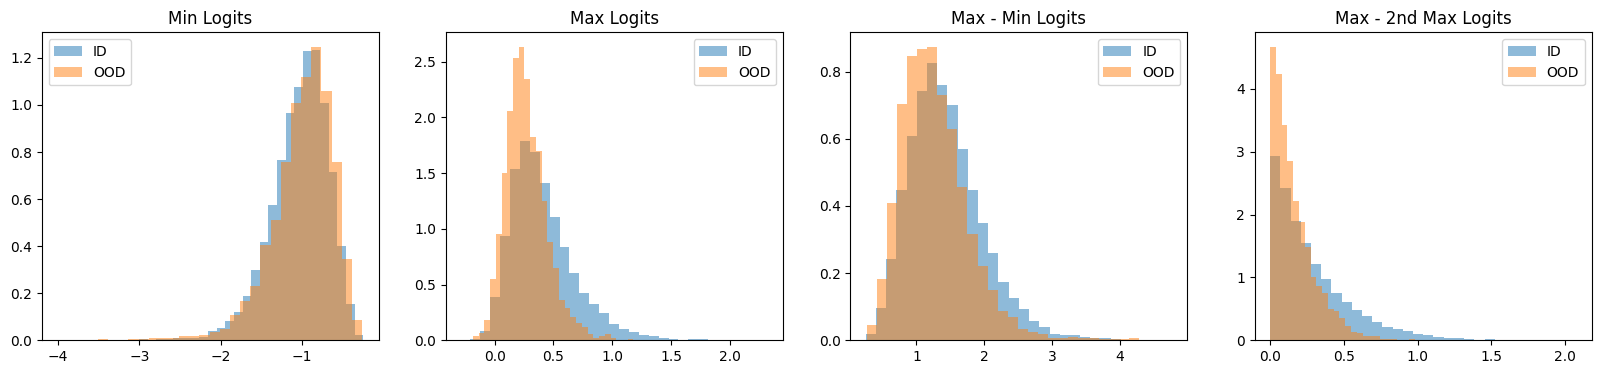

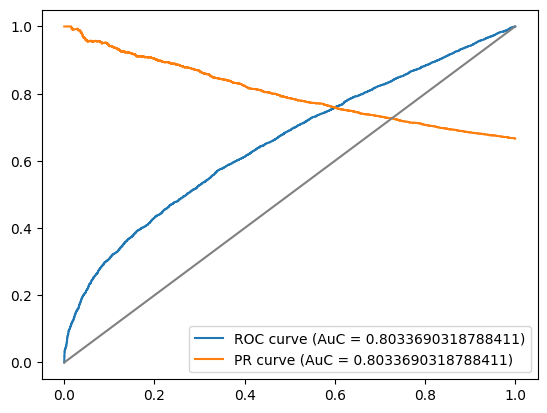

Loss Train = 0.9533253926681644, Loss Val = 1.3161119653823528, Acc = 0.607


Loss Train = 0.5771618485450745, Loss Val = 1.0940034323550285, Acc = 0.6314666666666666


Loss Train = 0.3439335249078339, Loss Val = 1.0613872583876265, Acc = 0.638


Loss Train = 0.2258297166764954, Loss Val = 1.0003879519219094, Acc = 0.6584


Loss Train = 0.17026526245273227, Loss Val = 1.02042492196915, Acc = 0.6619333333333334


Loss Train = 0.14140332618411597, Loss Val = 1.083510417887505, Acc = 0.6445333333333333


/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


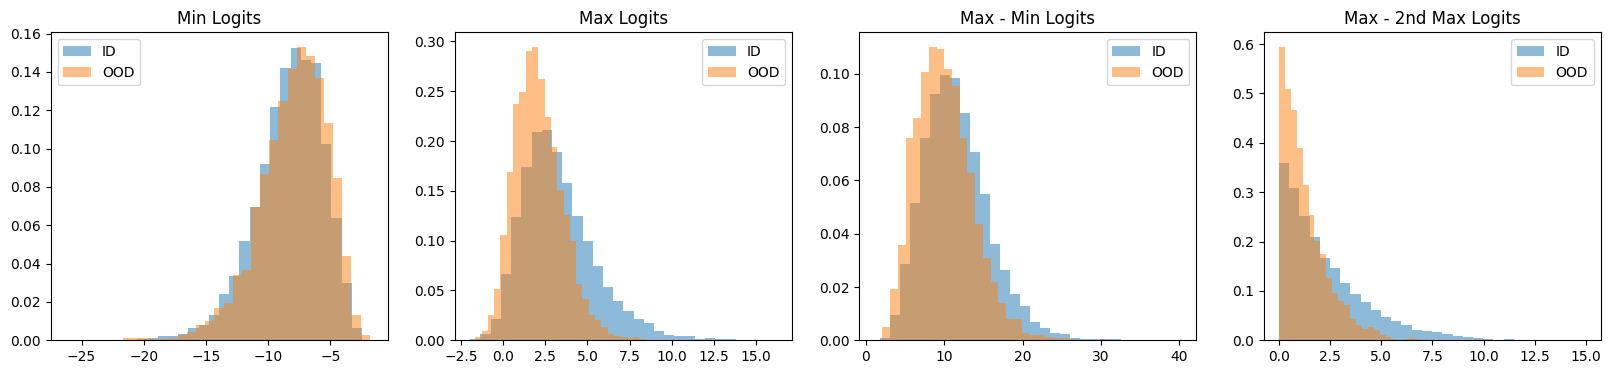

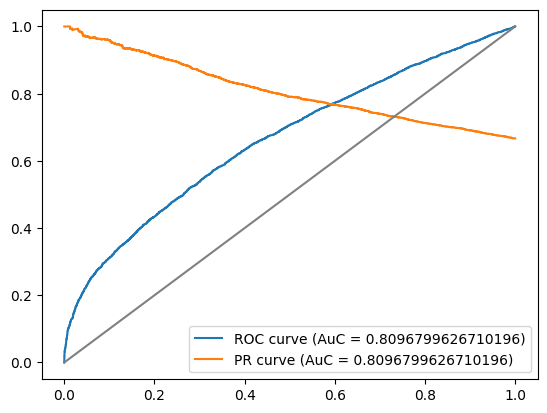

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


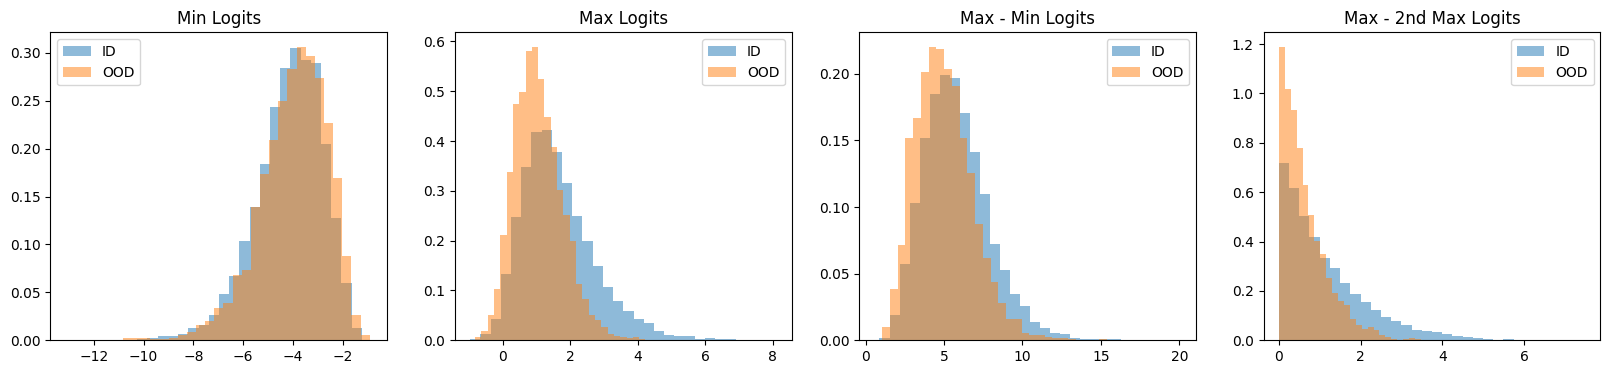

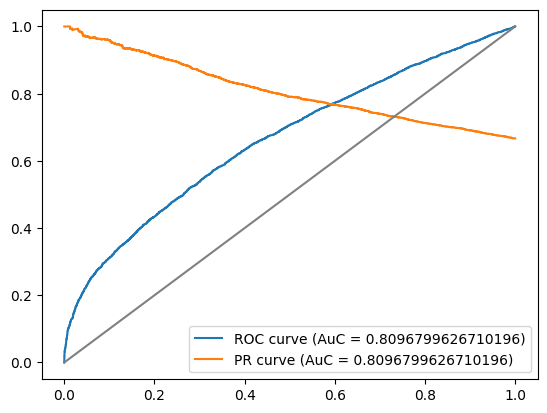

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


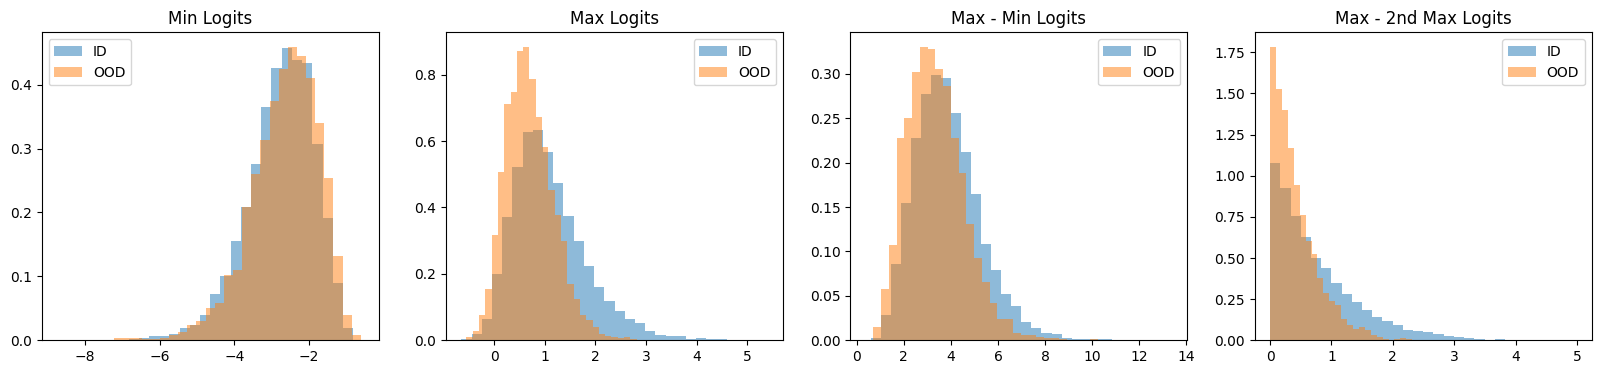

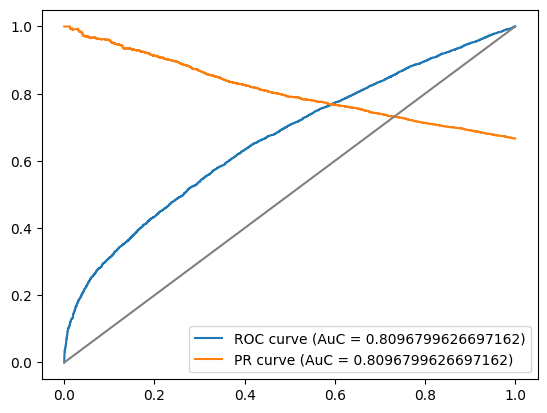

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


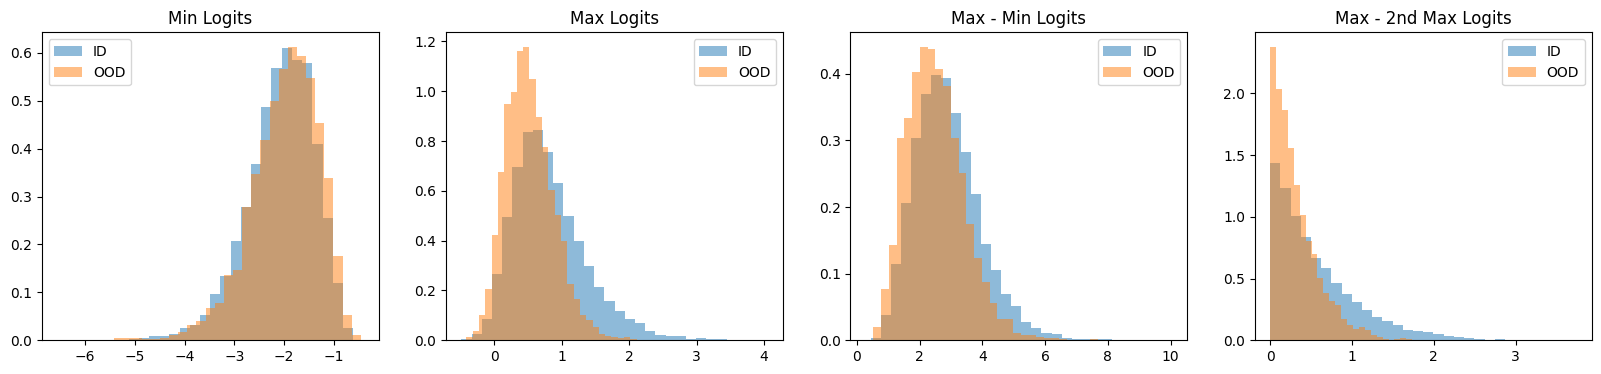

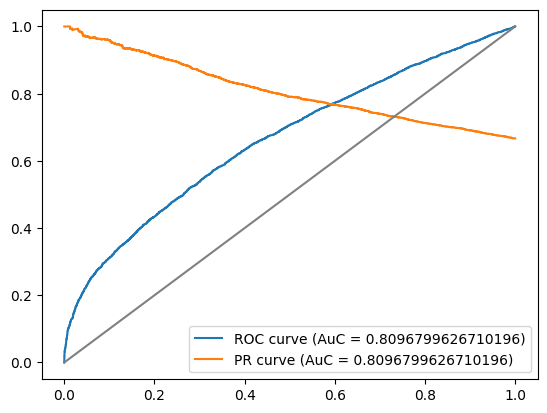

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


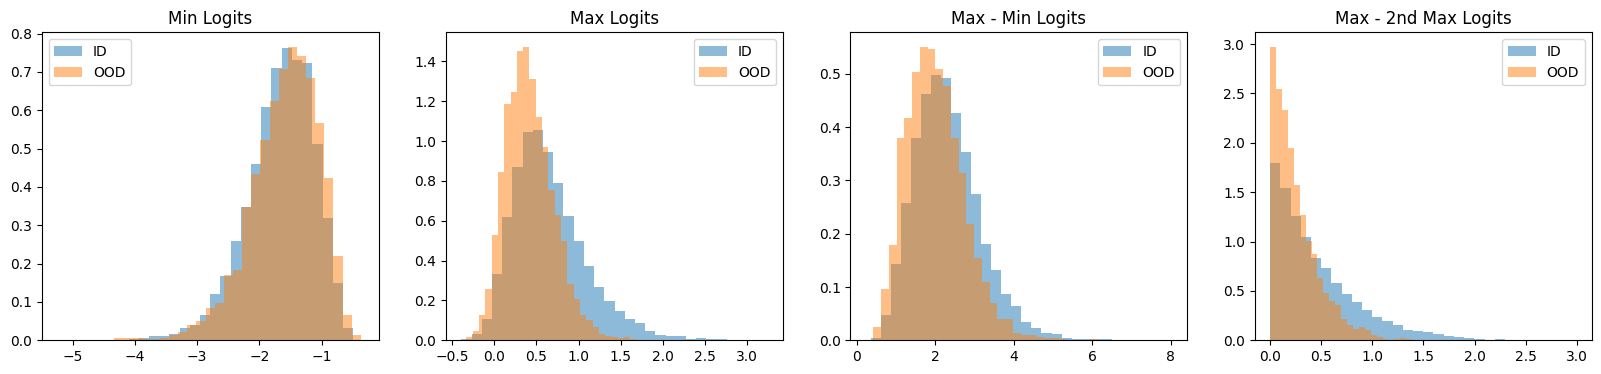

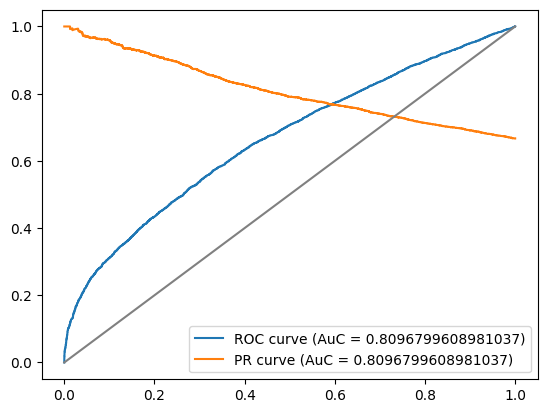

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


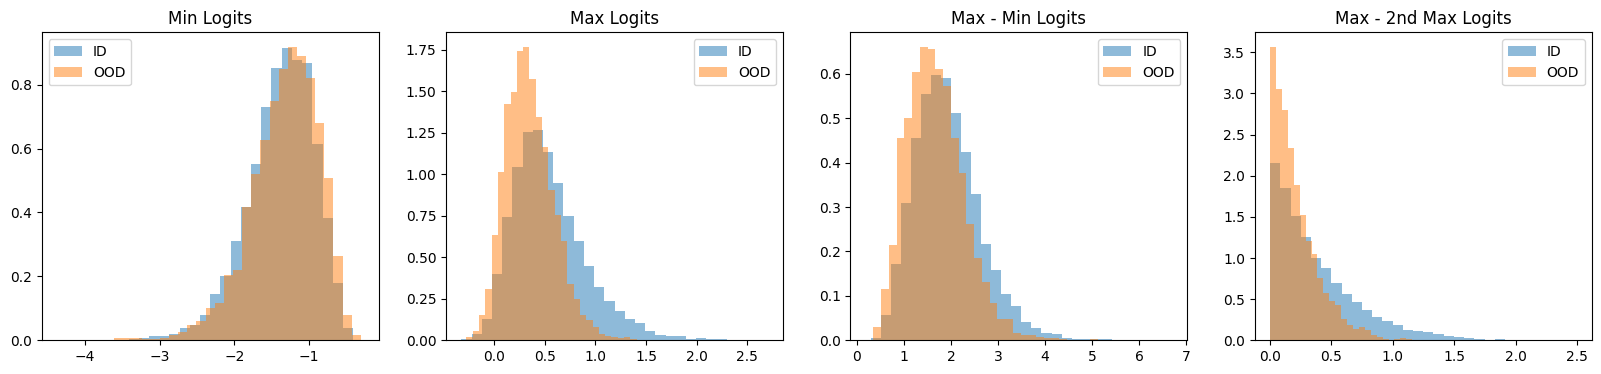

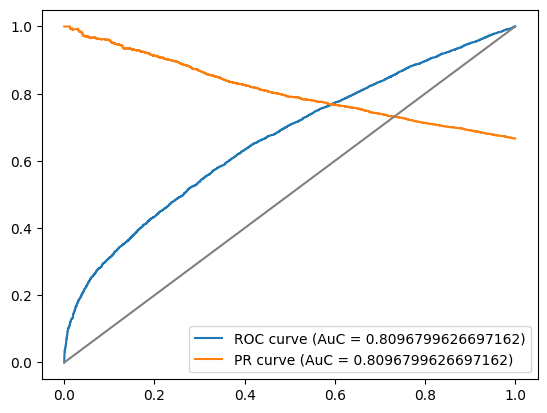

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


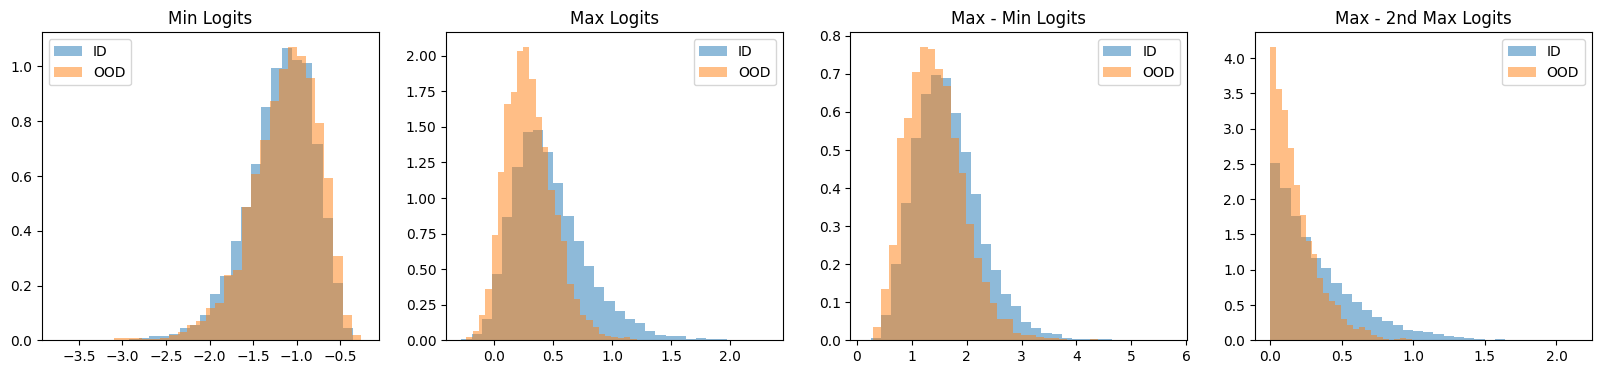

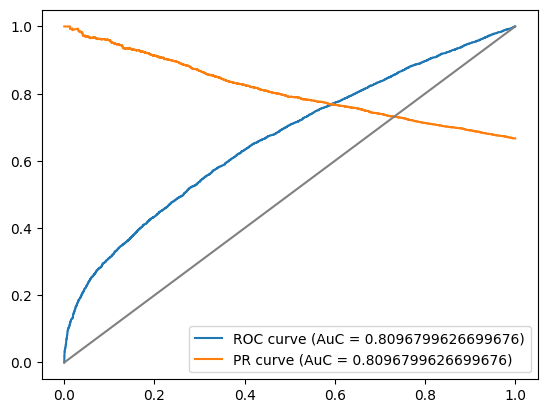

Loss Train = 0.9650068348460921, Loss Val = 1.319364885066418, Acc = 0.63


Loss Train = 0.6082298539619777, Loss Val = 1.0915502548217773, Acc = 0.647


Loss Train = 0.36844699250932583, Loss Val = 1.0061990768351454, Acc = 0.6636666666666666


Loss Train = 0.24800779921099733, Loss Val = 0.9826915631902978, Acc = 0.6635333333333333


Loss Train = 0.1886288923308444, Loss Val = 0.9957119023546259, Acc = 0.6598666666666667


Loss Train = 0.16480010218060212, Loss Val = 1.02123107377519, Acc = 0.6651333333333334


/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


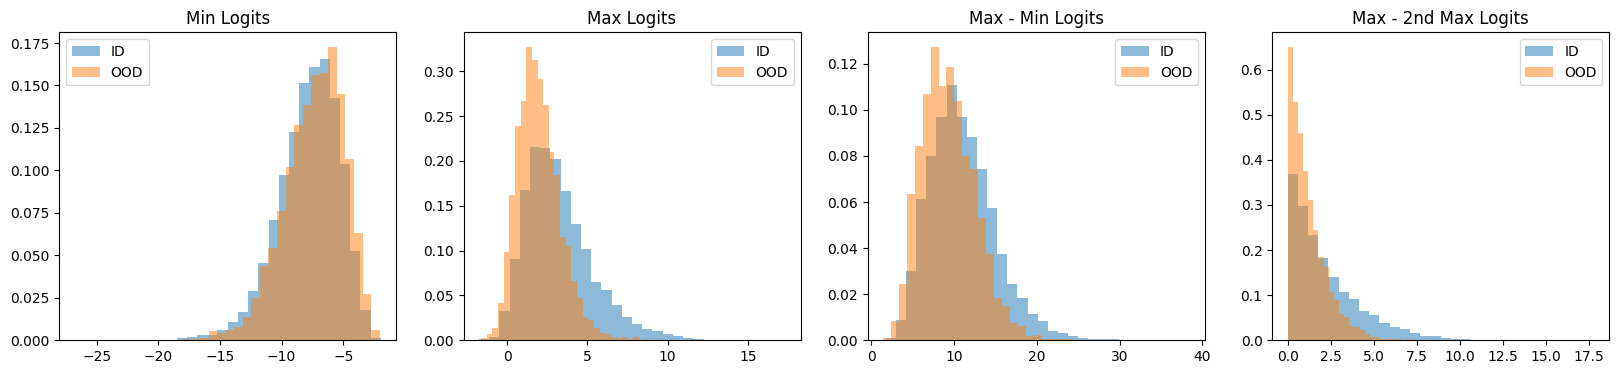

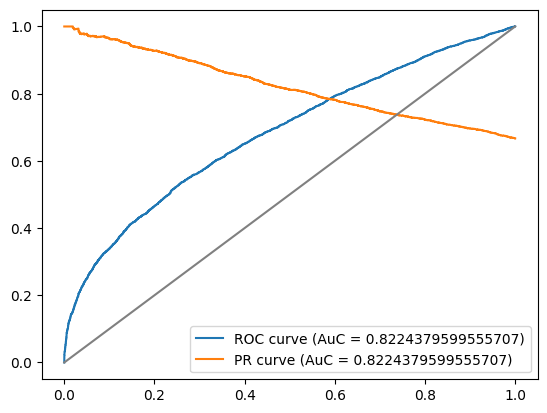

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


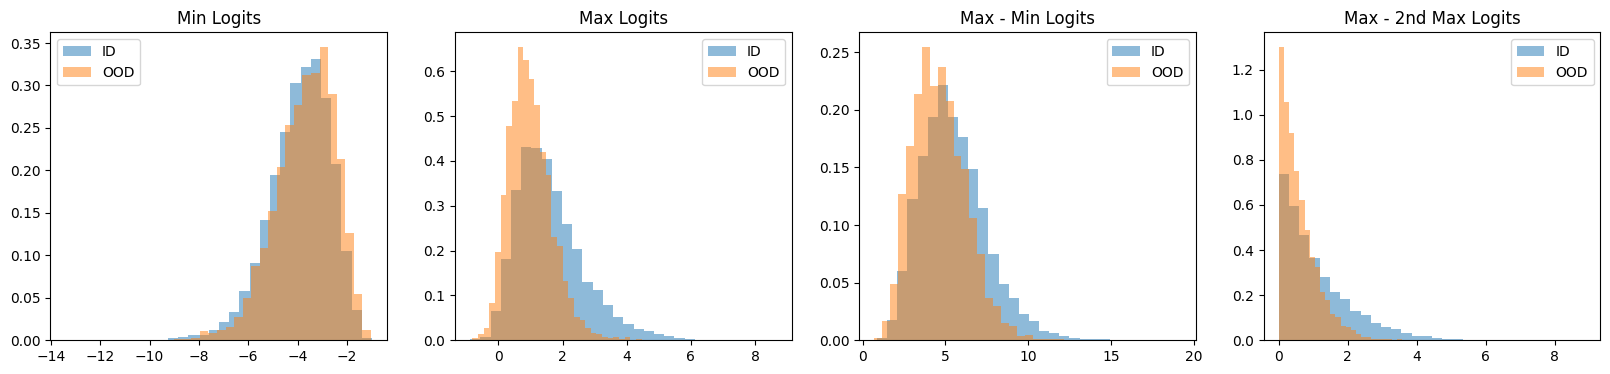

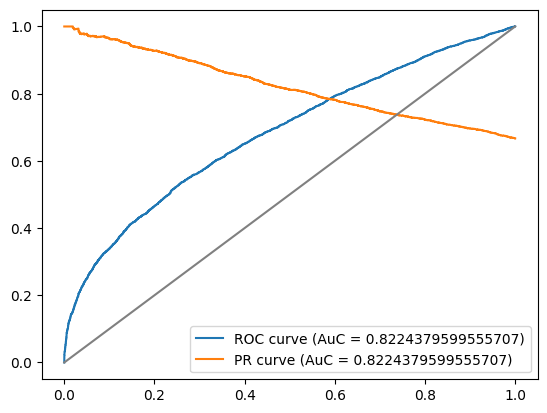

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


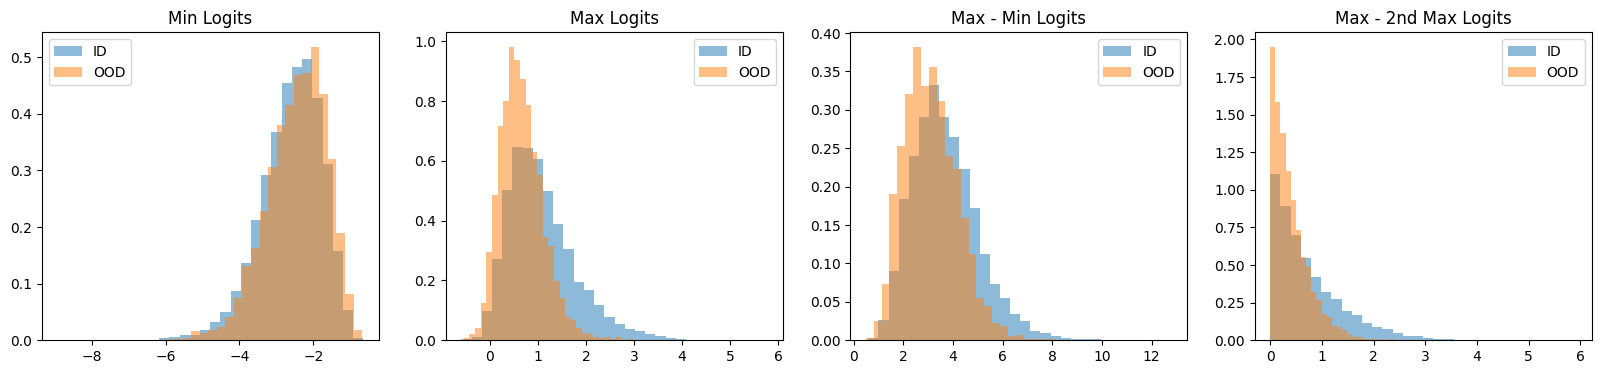

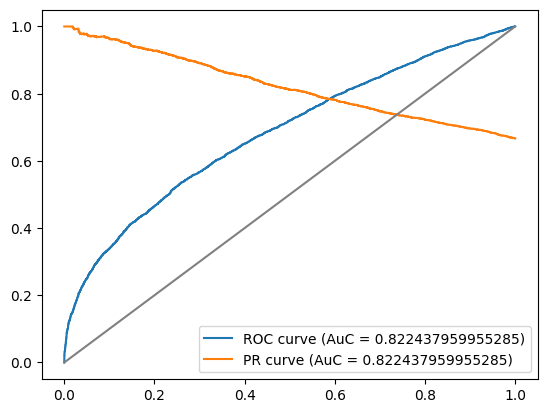

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


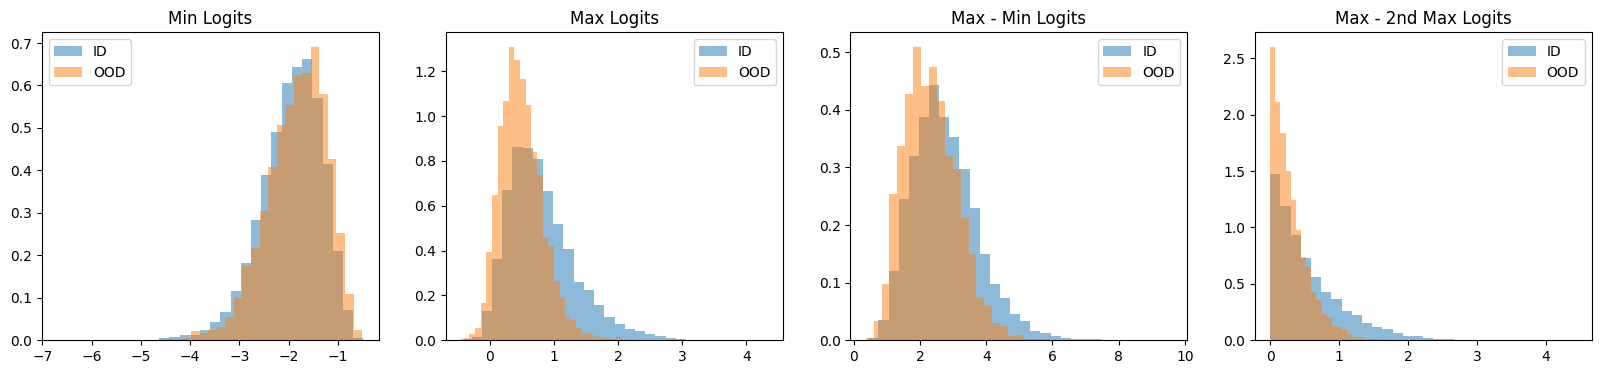

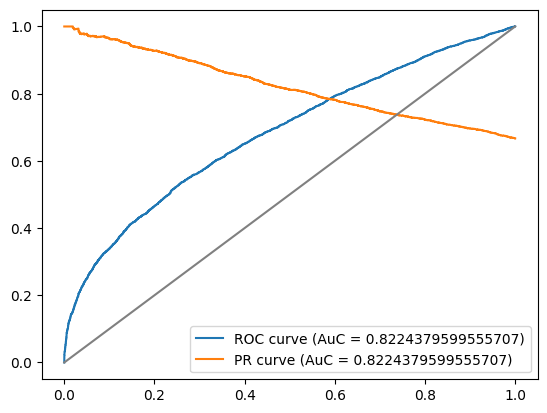

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


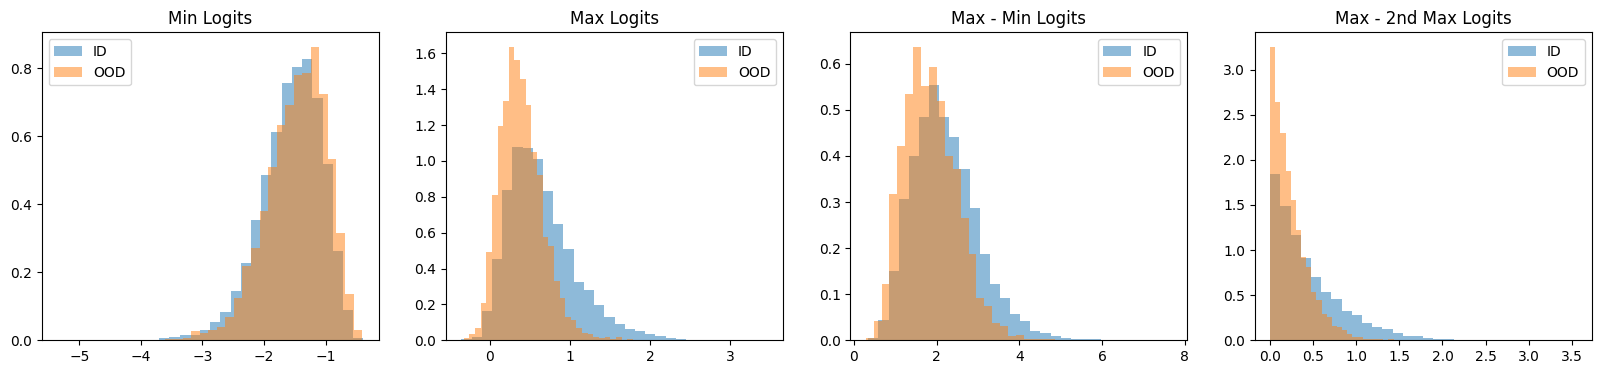

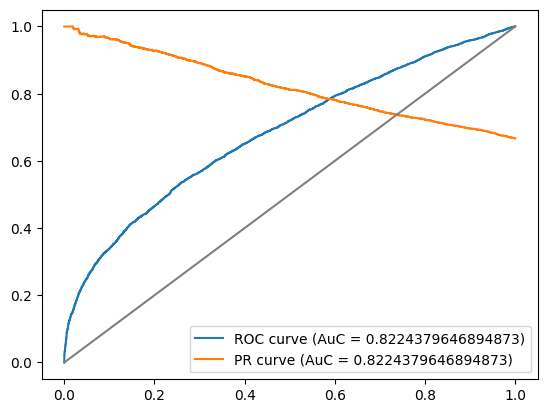

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


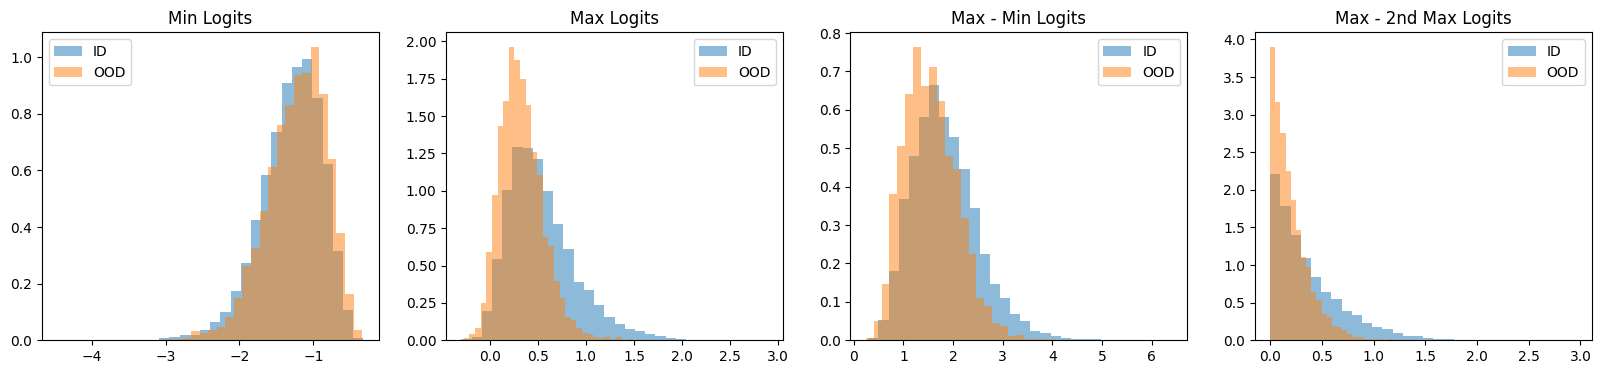

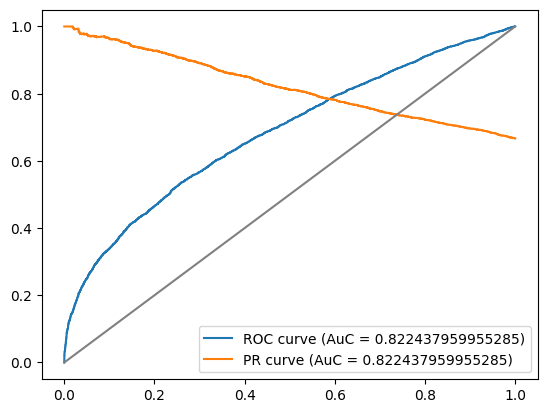

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


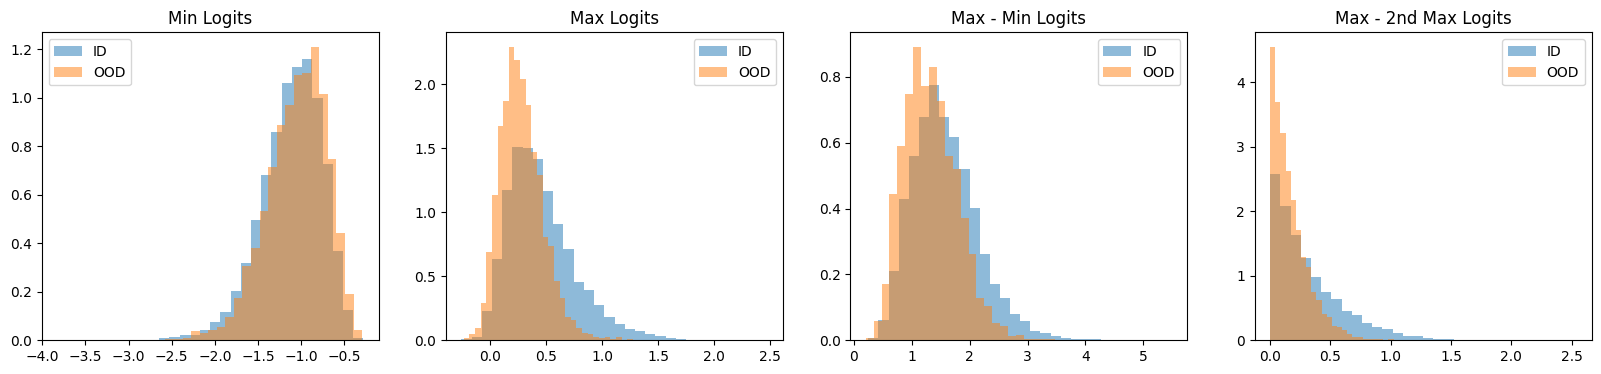

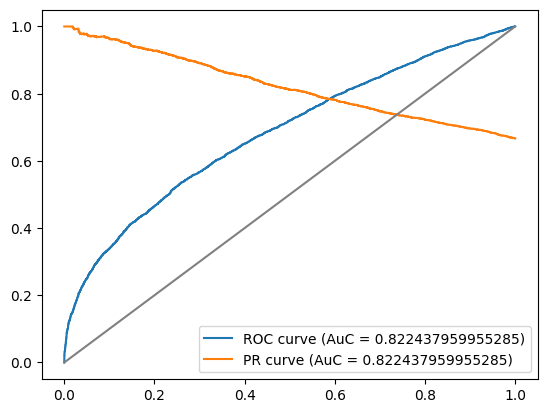

Loss Train = 0.9231259011045453, Loss Val = 1.279607893050985, Acc = 0.6173333333333333


Loss Train = 0.5594480136303841, Loss Val = 1.0814372204719707, Acc = 0.6506666666666666


Loss Train = 0.3367271469514374, Loss Val = 1.0261933978567732, Acc = 0.6477333333333334


Loss Train = 0.2233022919275425, Loss Val = 0.9932273020135596, Acc = 0.6611333333333334


Loss Train = 0.17487100643911135, Loss Val = 1.0283892065920728, Acc = 0.6542666666666667


Loss Train = 0.14504709008611208, Loss Val = 1.0766299889442768, Acc = 0.6529333333333334


/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


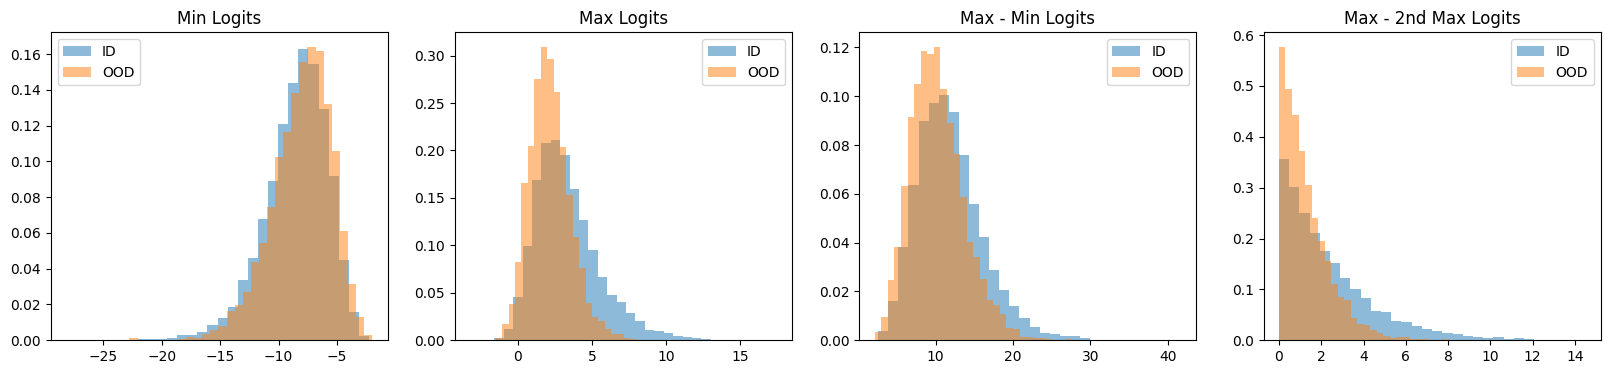

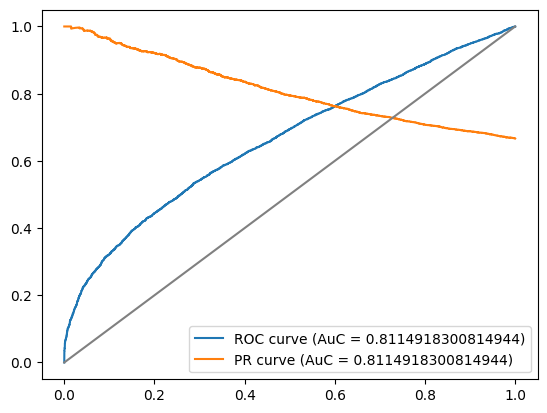

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


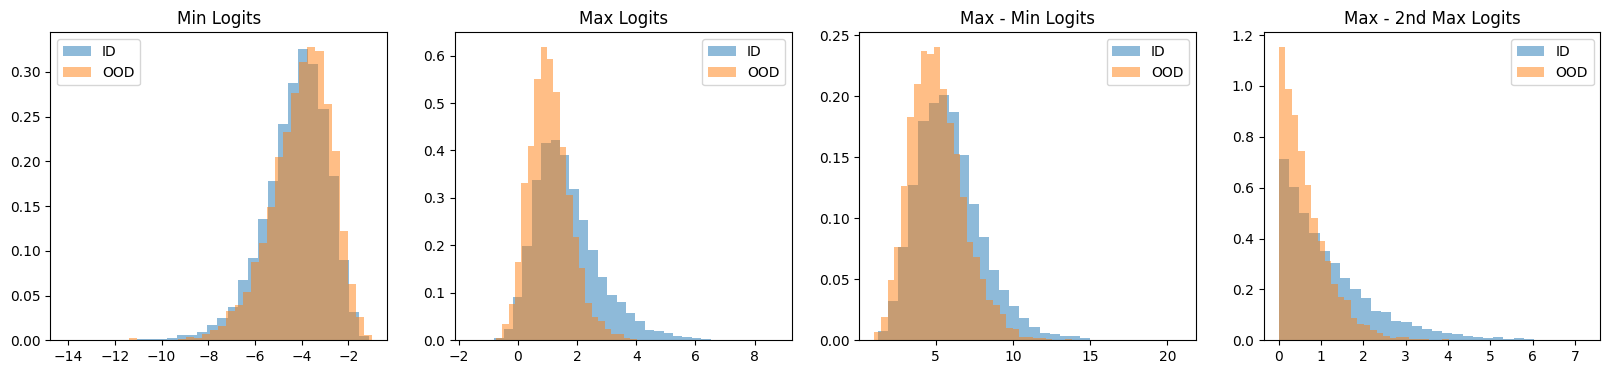

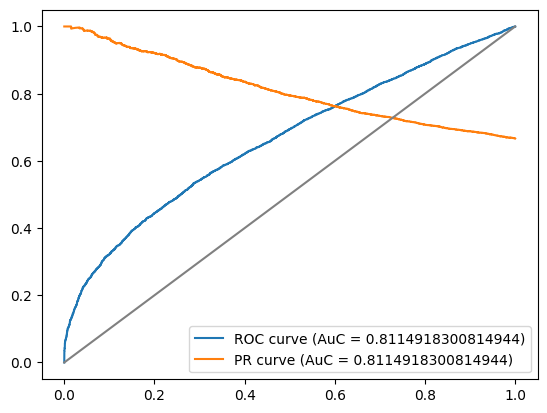

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


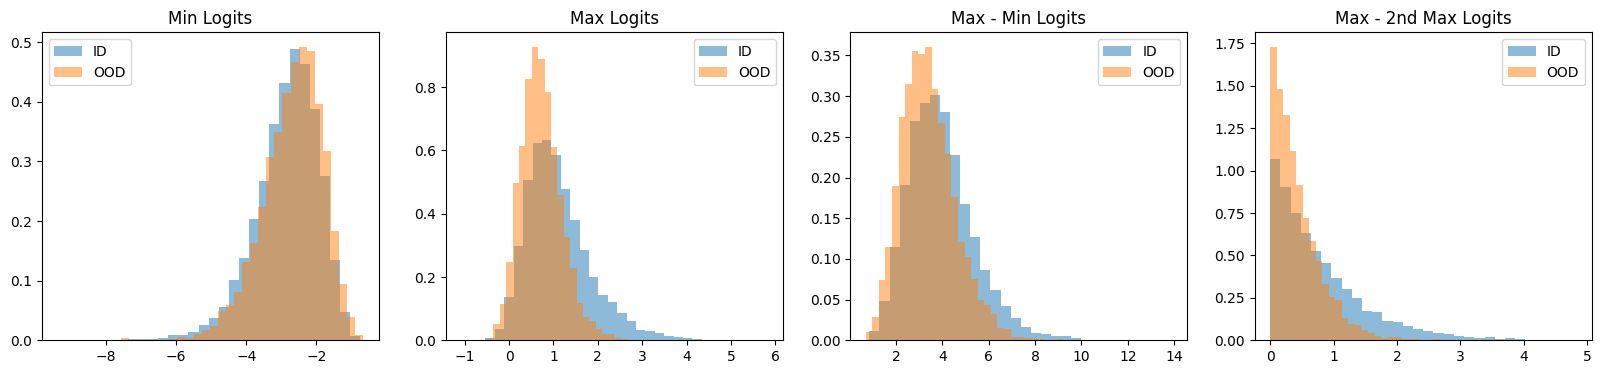

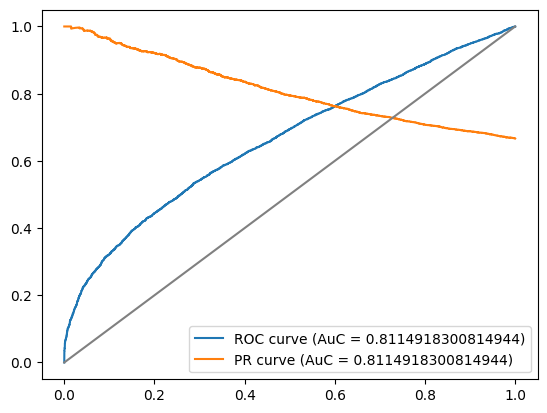

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


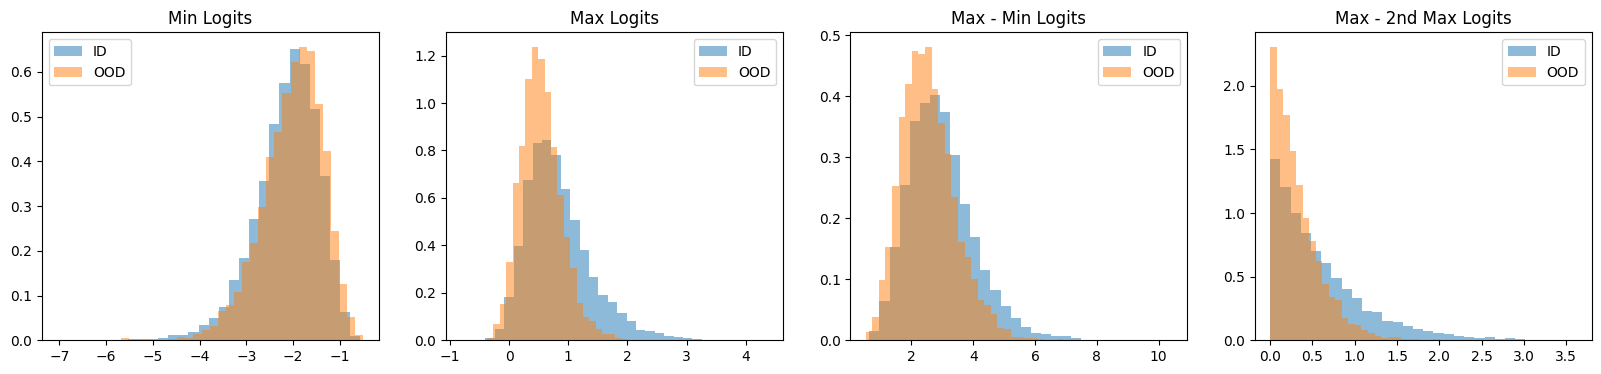

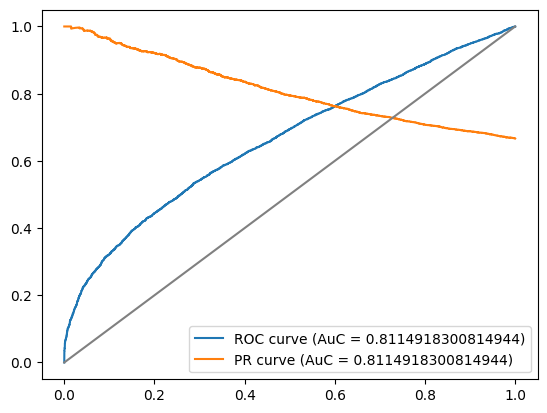

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


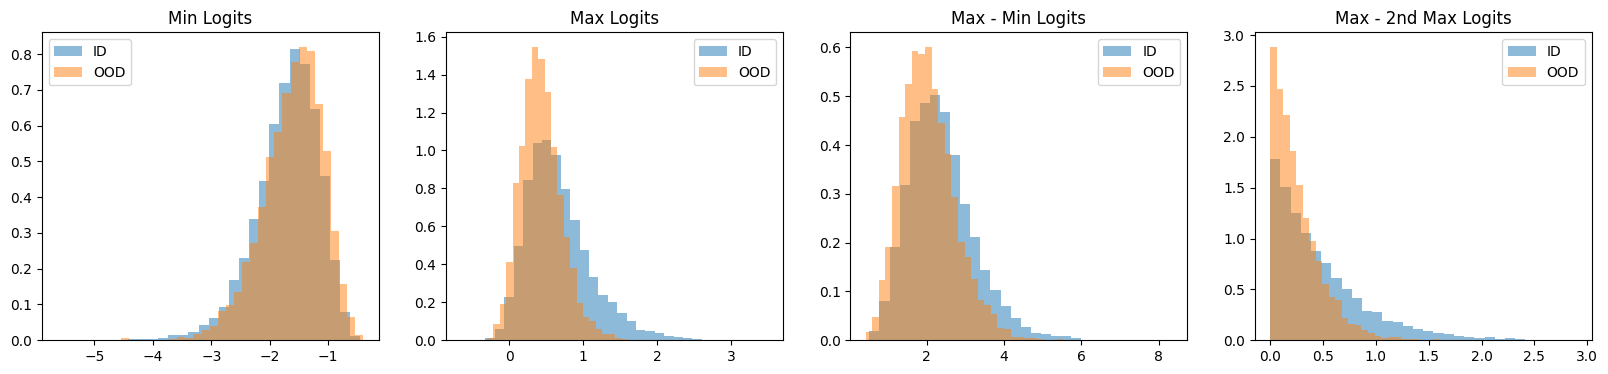

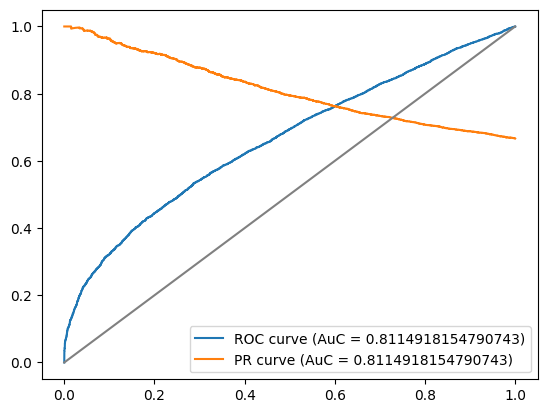

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


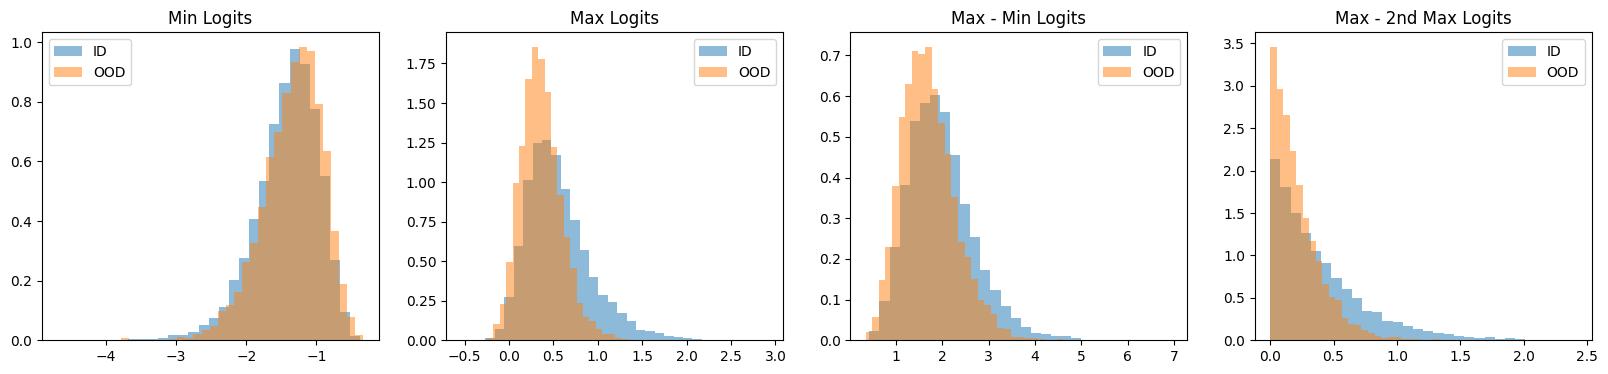

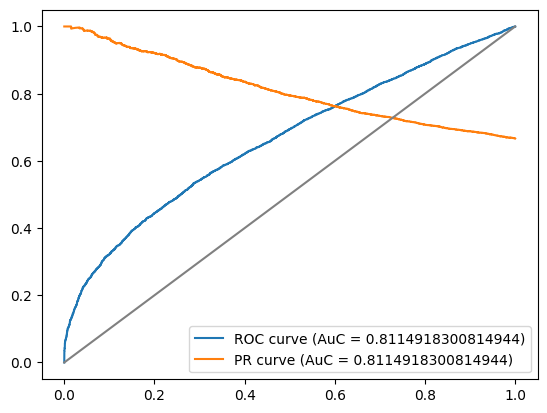

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


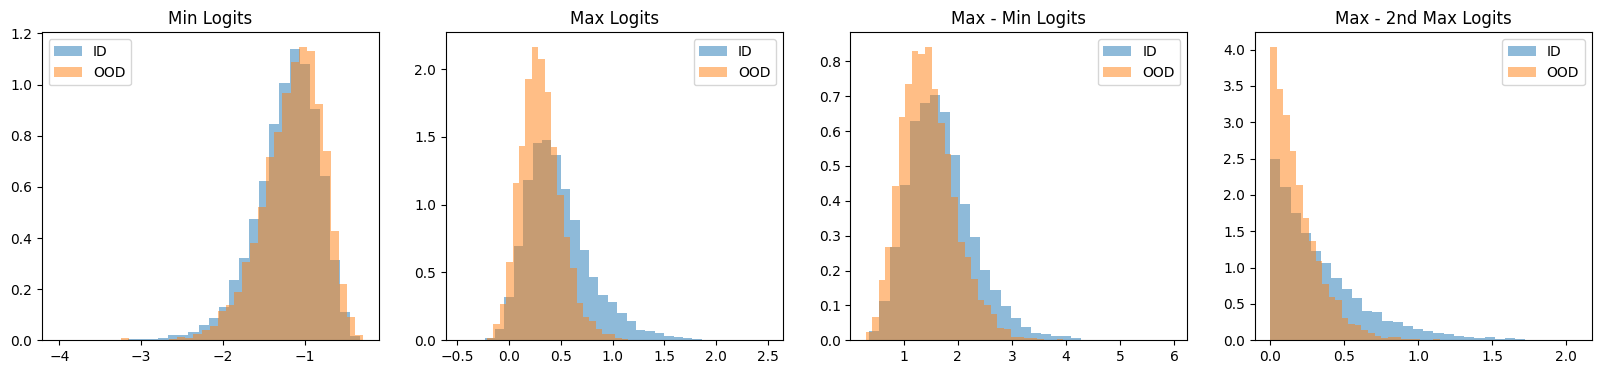

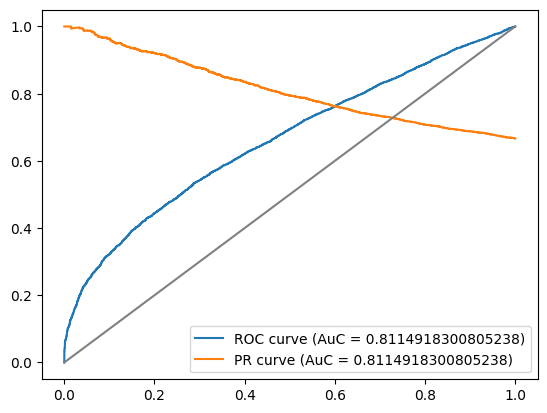

Loss Train = 0.9401136671603271, Loss Val = 1.2982868159070928, Acc = 0.6466666666666666


Loss Train = 0.6048605058485237, Loss Val = 1.0621939070681308, Acc = 0.6704


Loss Train = 0.3778115324199309, Loss Val = 0.9507095263359394, Acc = 0.683


Loss Train = 0.2613143984235183, Loss Val = 0.980948029680455, Acc = 0.6653333333333333


Loss Train = 0.20111048575048038, Loss Val = 0.9757424521953502, Acc = 0.6703333333333333


Loss Train = 0.17080094299570298, Loss Val = 1.0145997159024502, Acc = 0.664


/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


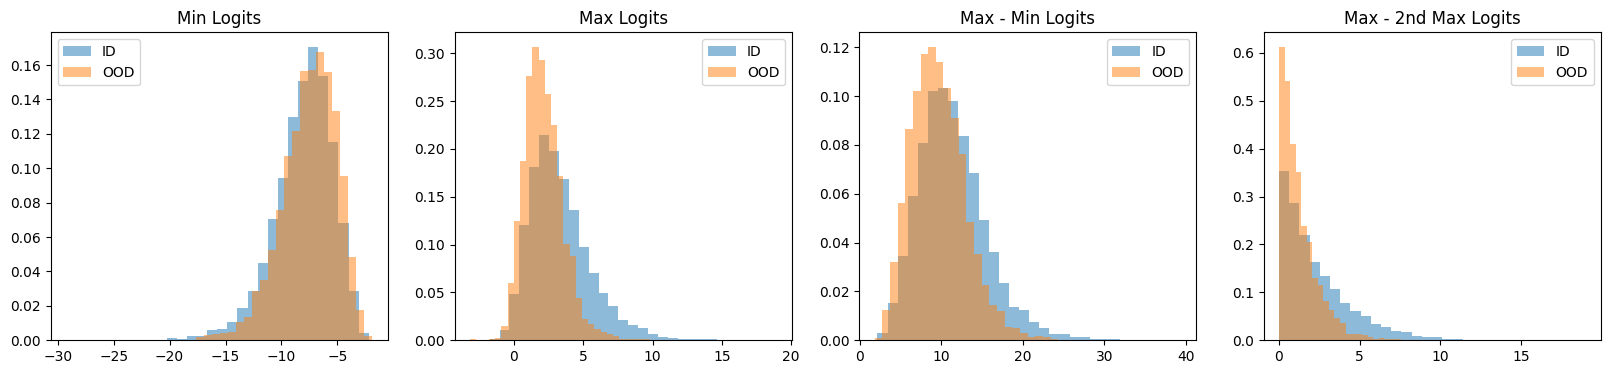

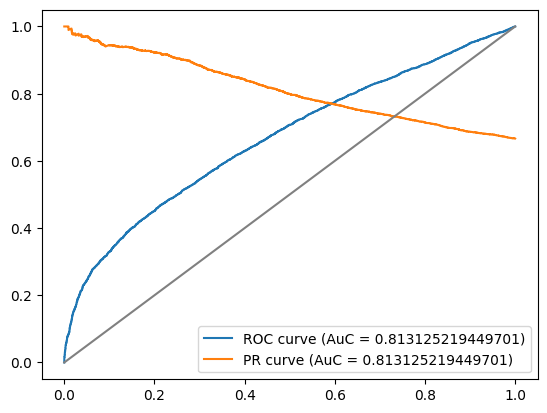

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


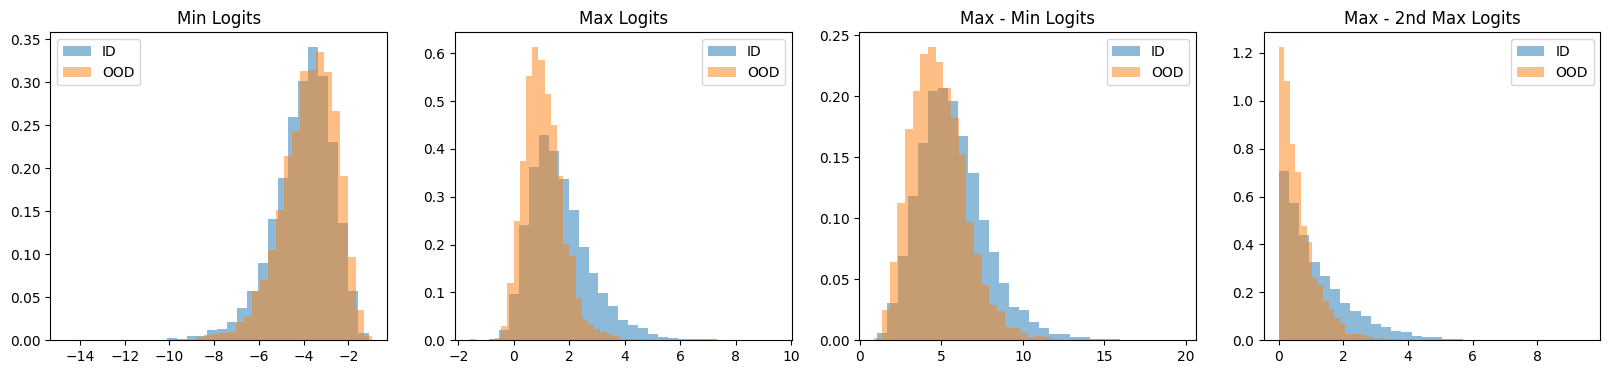

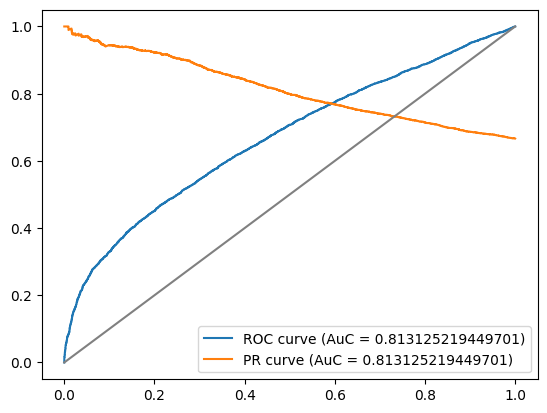

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


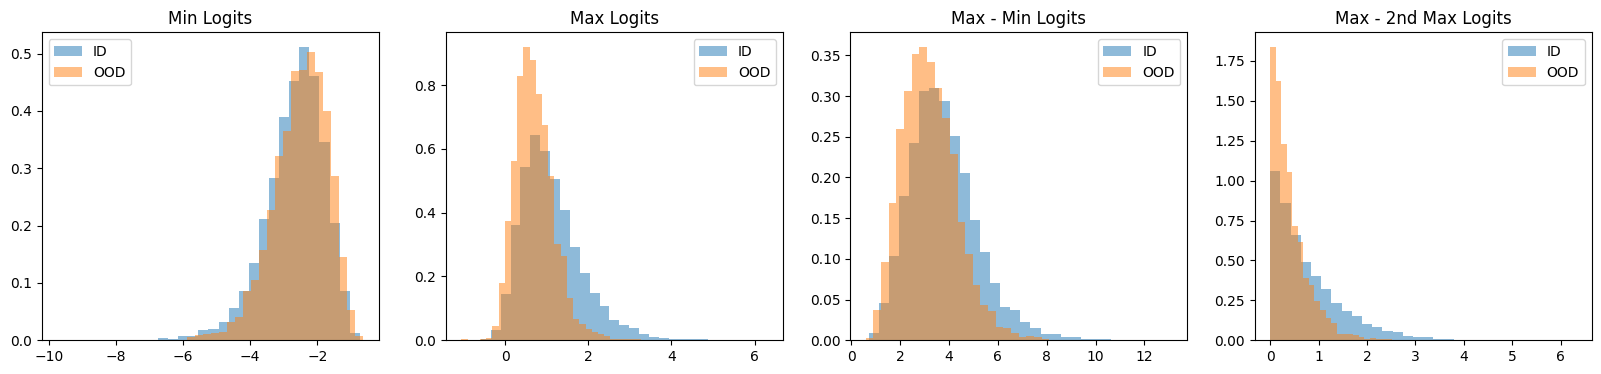

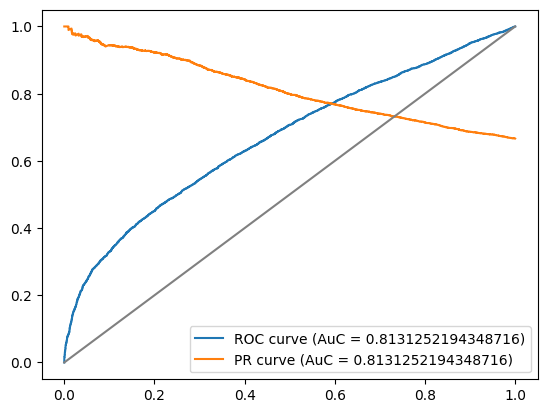

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


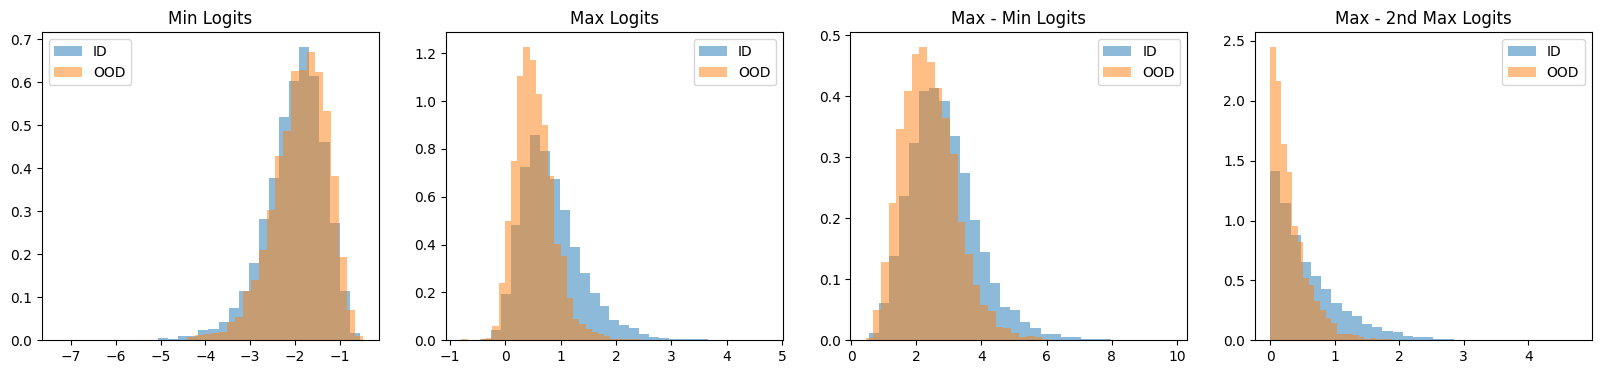

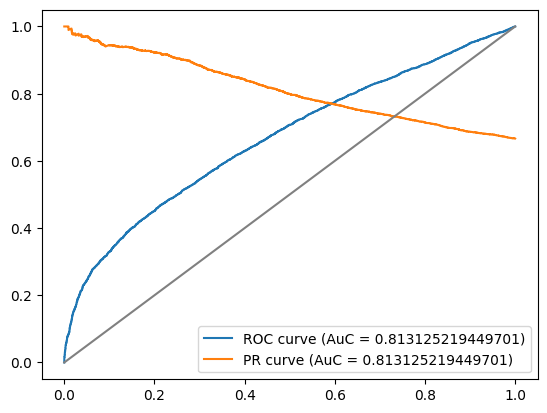

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


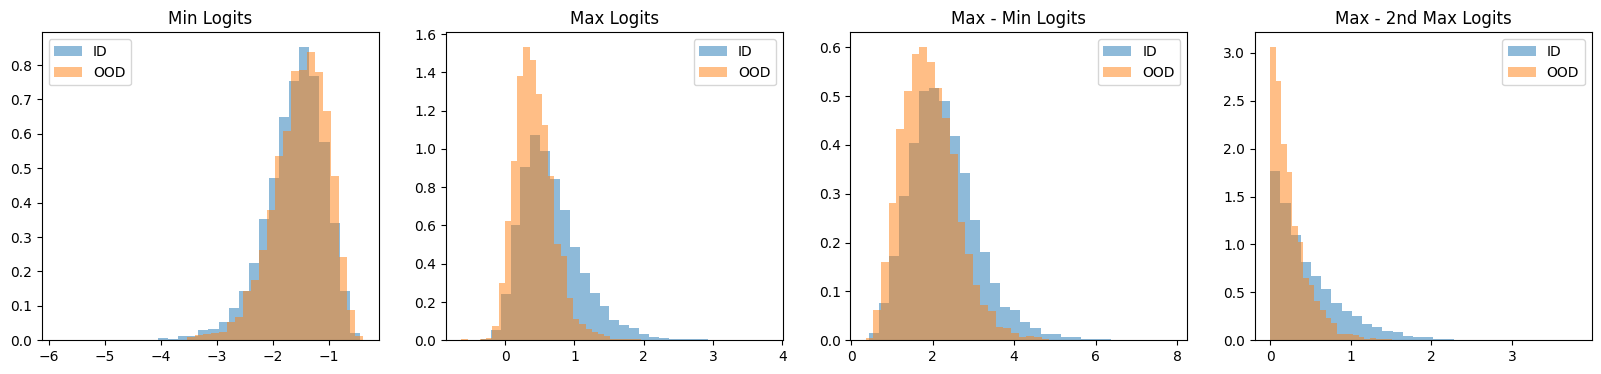

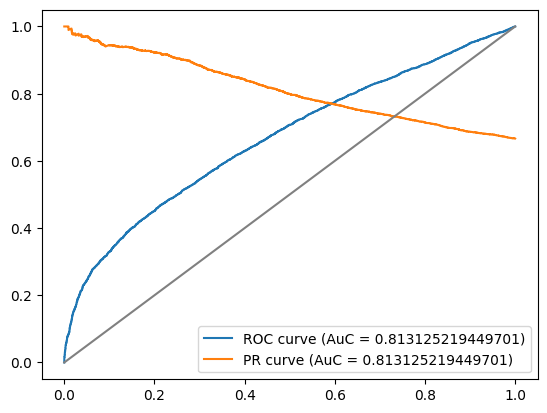

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


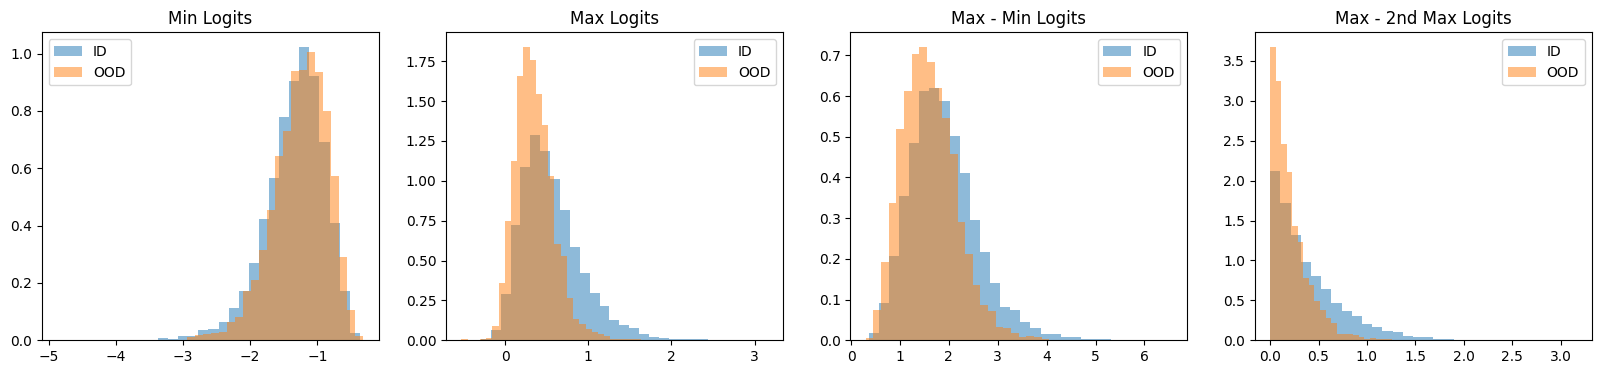

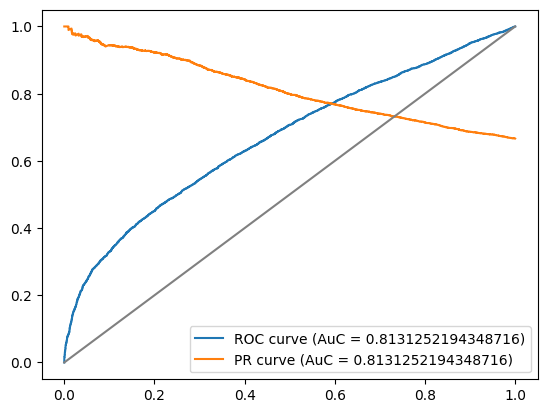

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


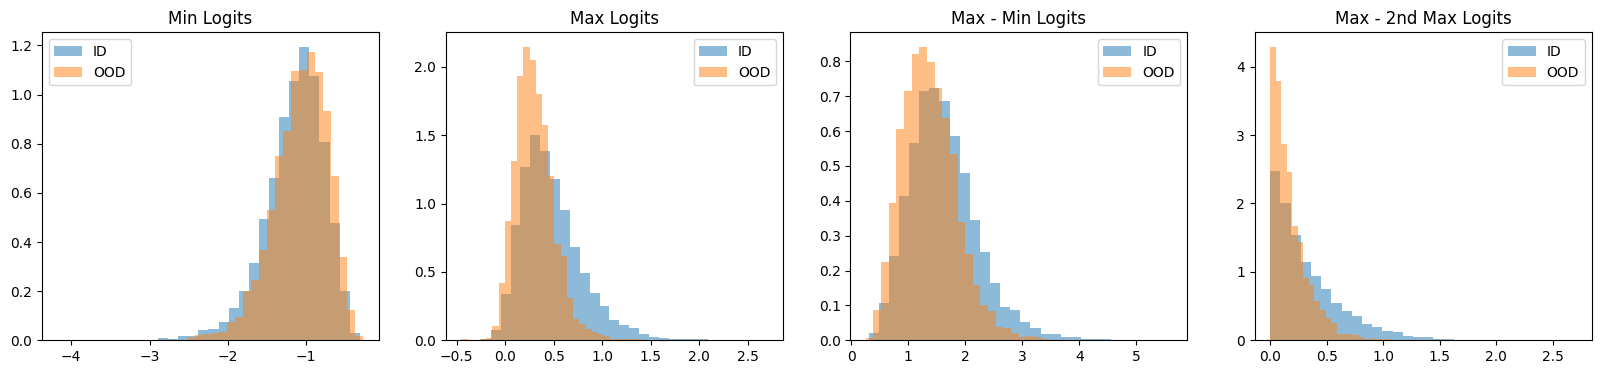

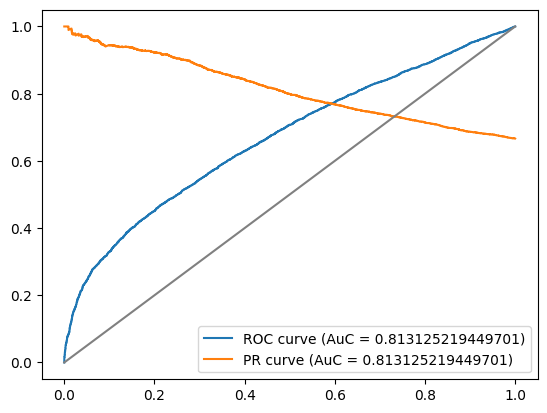

Loss Train = 0.9099116204425666, Loss Val = 1.22985504104736, Acc = 0.6378666666666667


Loss Train = 0.5458922014049028, Loss Val = 1.0136140516463747, Acc = 0.6760666666666667


Loss Train = 0.323978014767061, Loss Val = 0.9566220067917033, Acc = 0.6731333333333334


Loss Train = 0.2129963961254526, Loss Val = 0.9795045327632985, Acc = 0.6660666666666667


Loss Train = 0.16848866721203165, Loss Val = 1.0305828218764448, Acc = 0.6542


Loss Train = 0.14434242028218627, Loss Val = 1.0633748064649866, Acc = 0.6598666666666667


/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


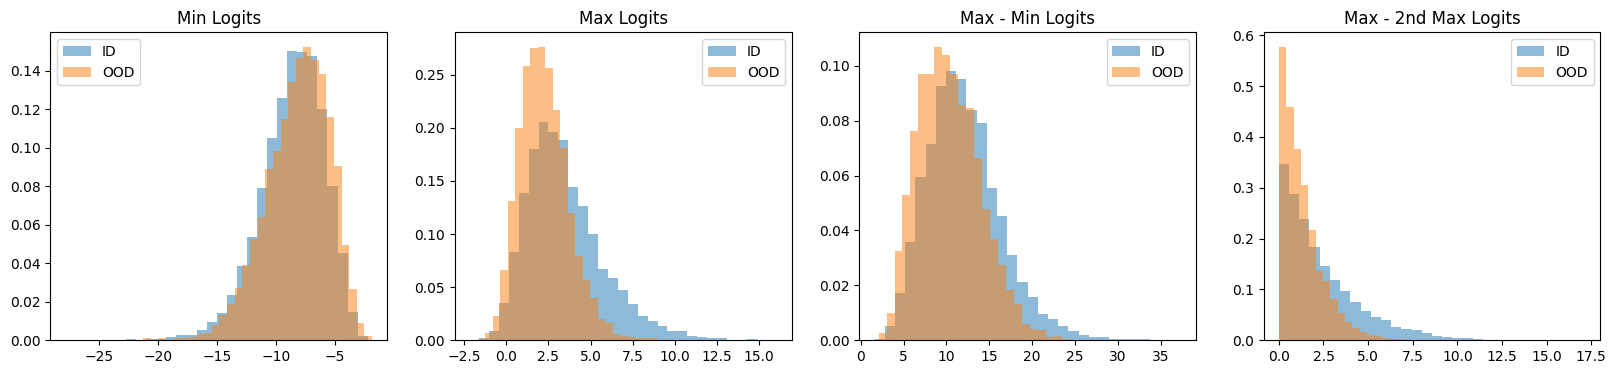

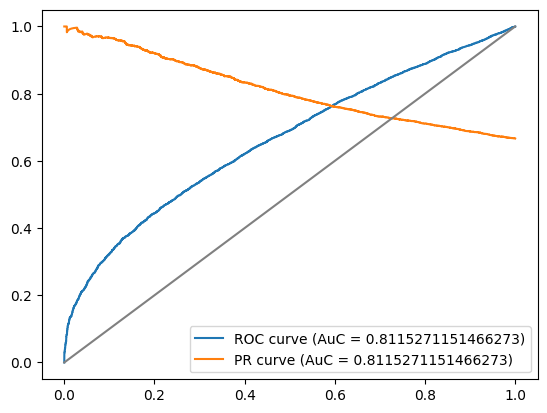

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


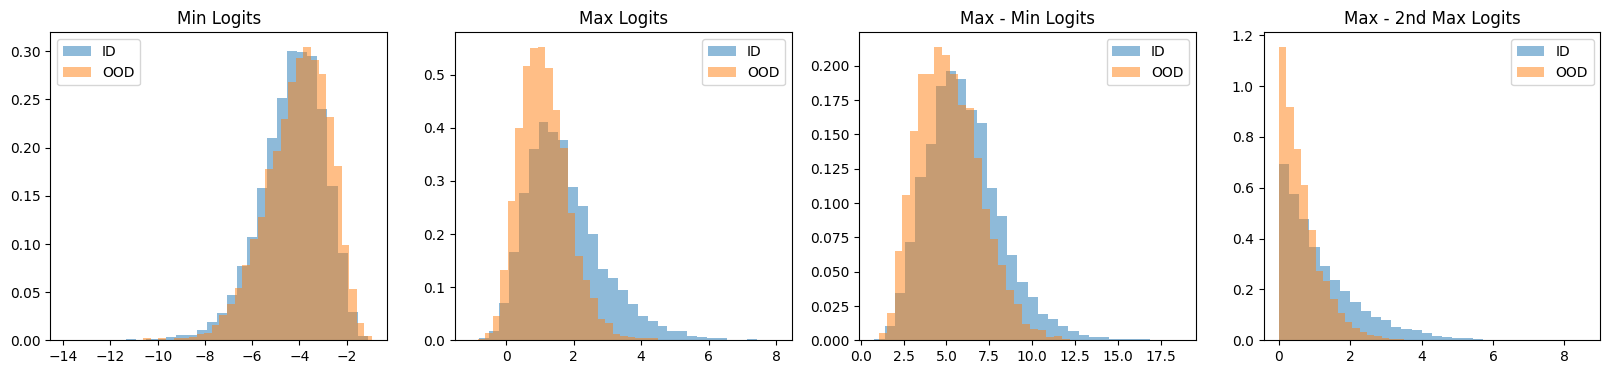

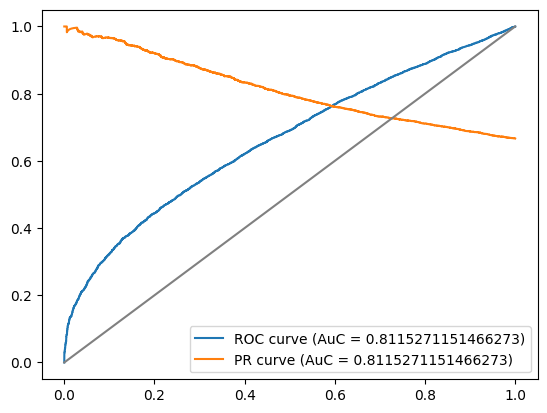

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


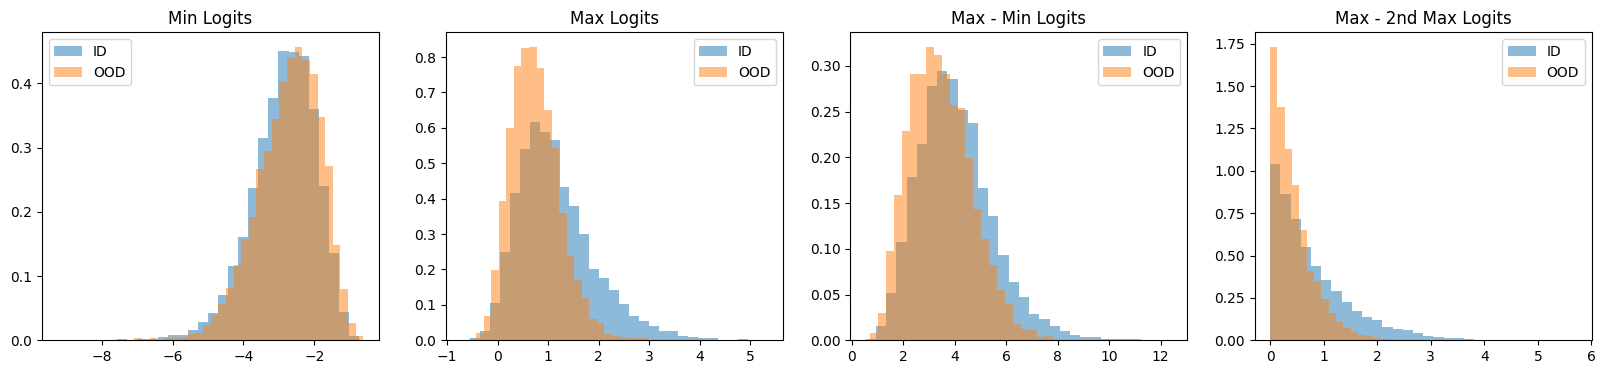

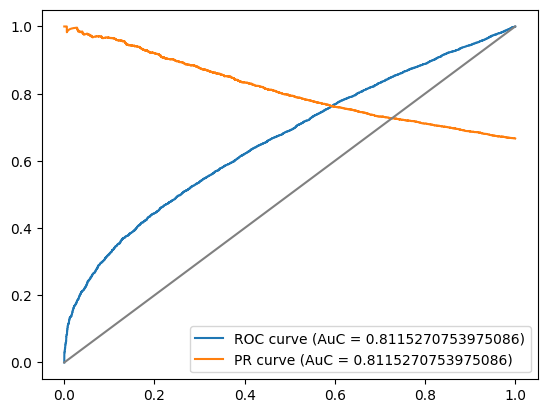

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


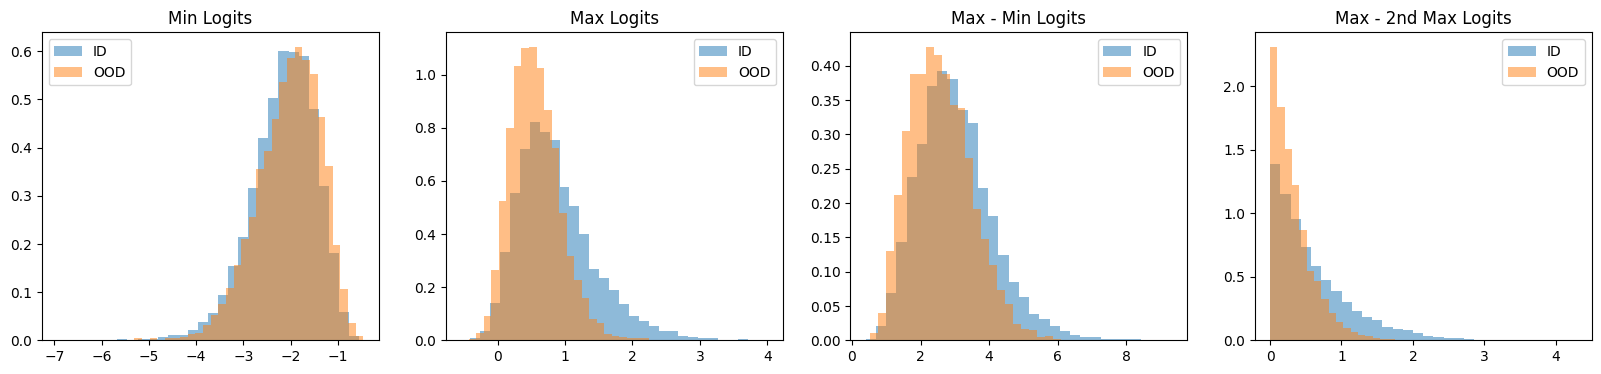

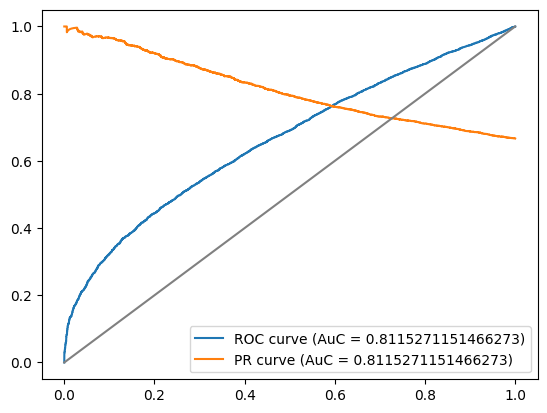

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


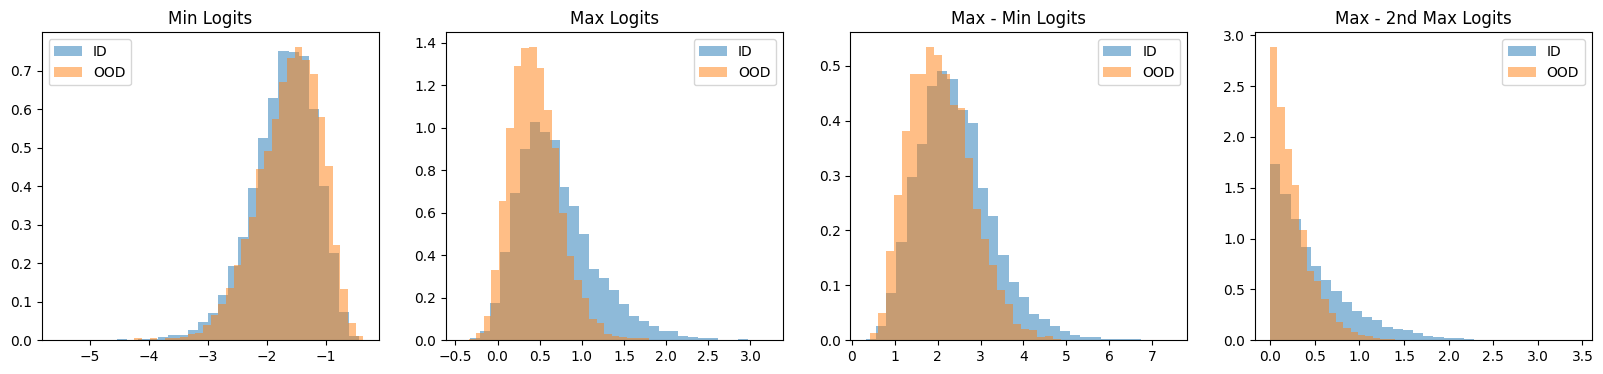

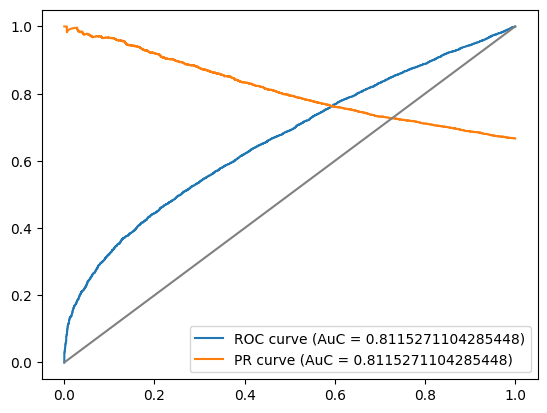

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


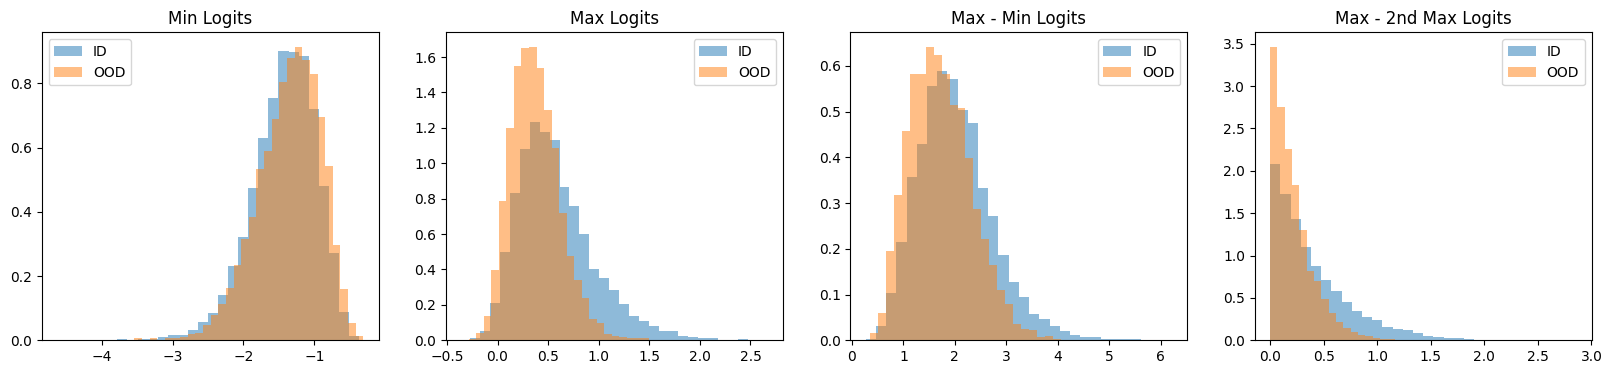

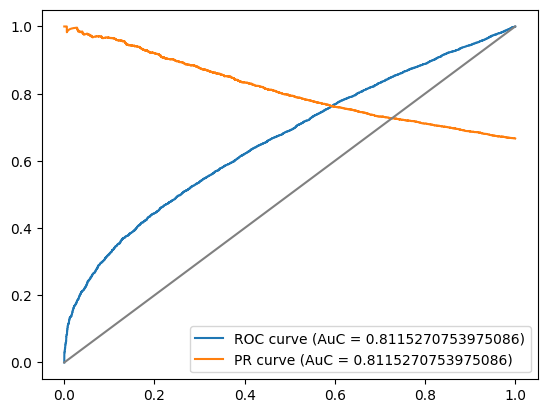

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


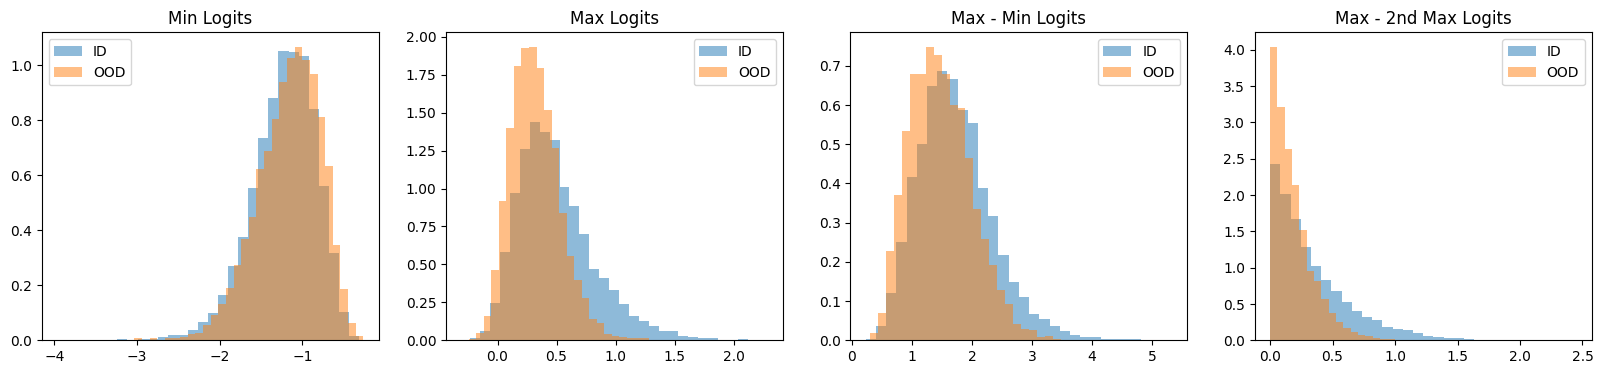

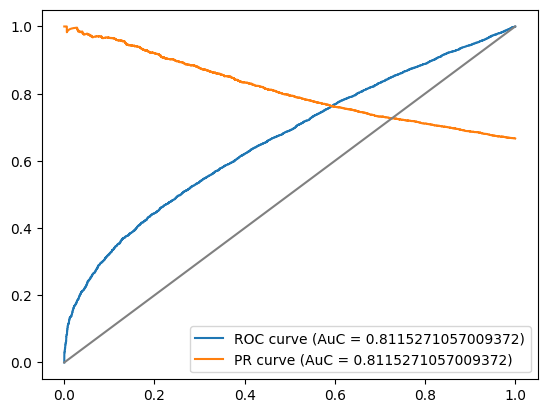

Loss Train = 1.0352586847772547, Loss Val = 1.358034631039234, Acc = 0.606


Loss Train = 0.6821074058630349, Loss Val = 1.1538255767619356, Acc = 0.6414


Loss Train = 0.4434316842603945, Loss Val = 1.0450667376213885, Acc = 0.6486666666666666


Loss Train = 0.30992824348605746, Loss Val = 1.0014925860344095, Acc = 0.6554666666666666


Loss Train = 0.2362270719444948, Loss Val = 1.041345694217276, Acc = 0.6458666666666667


Loss Train = 0.1991340603059672, Loss Val = 1.085760463552272, Acc = 0.6324


/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


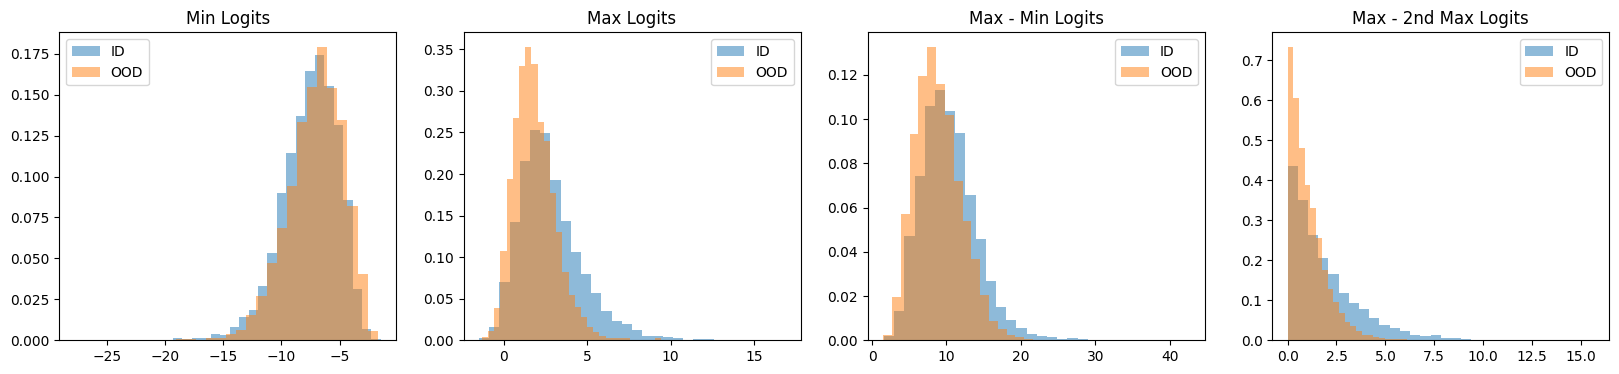

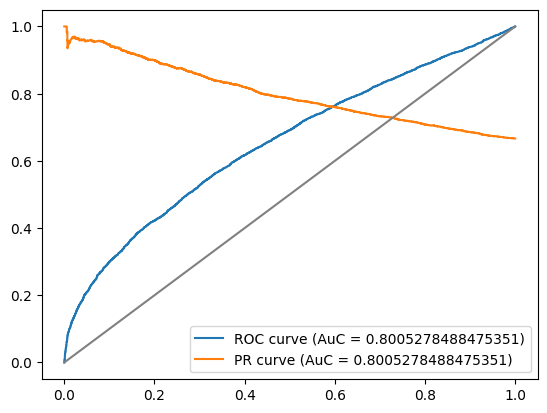

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


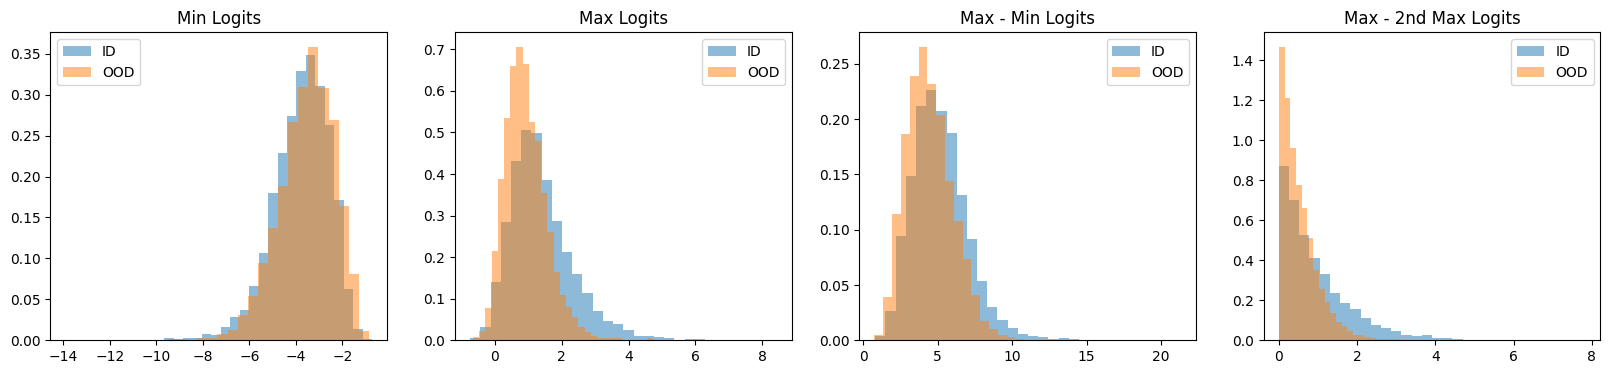

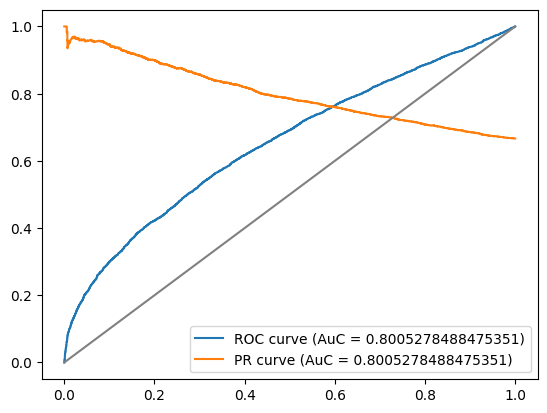

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


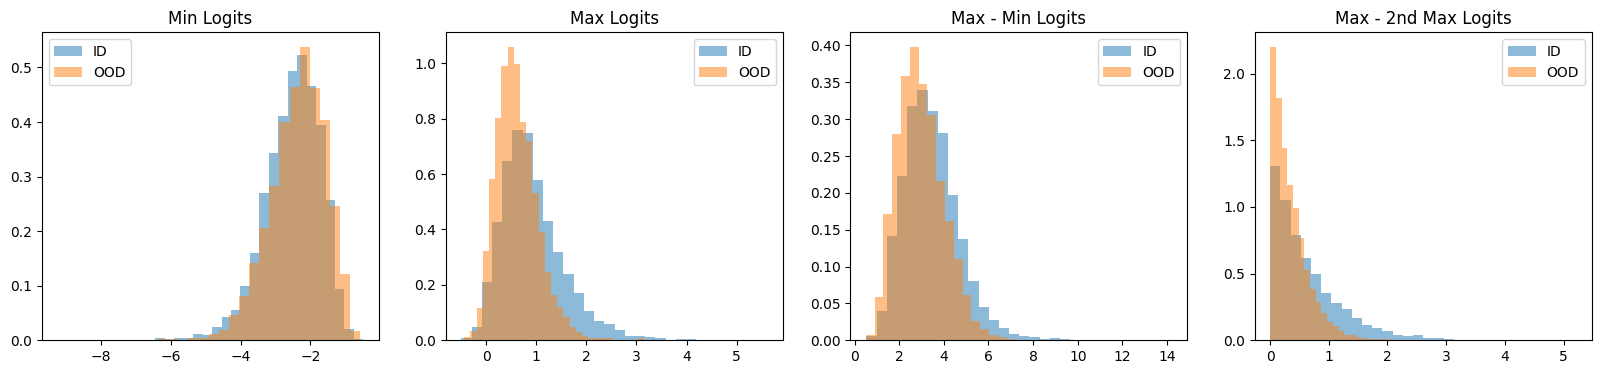

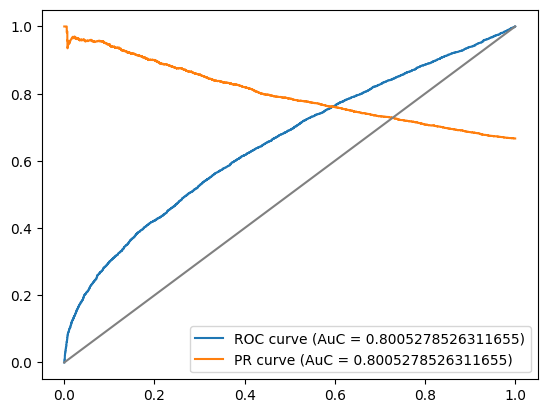

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


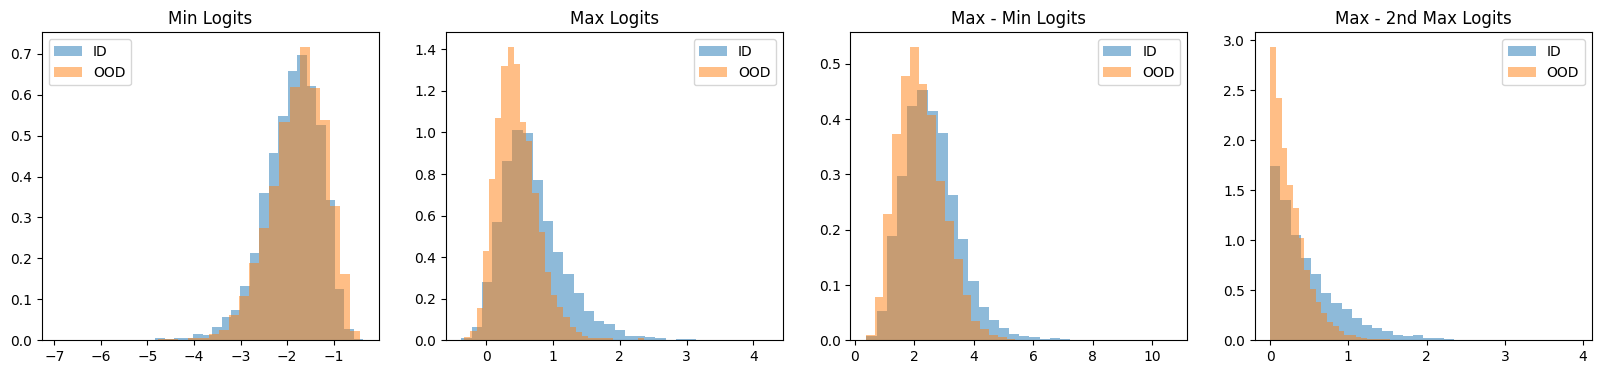

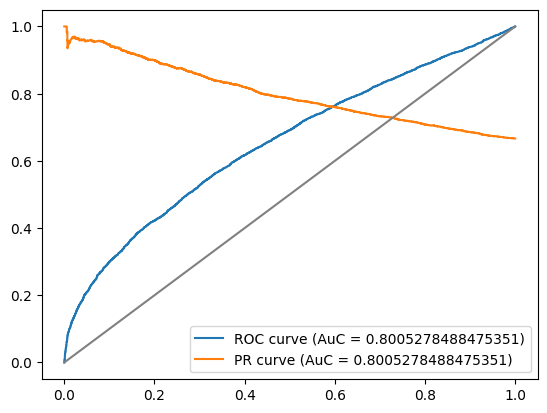

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


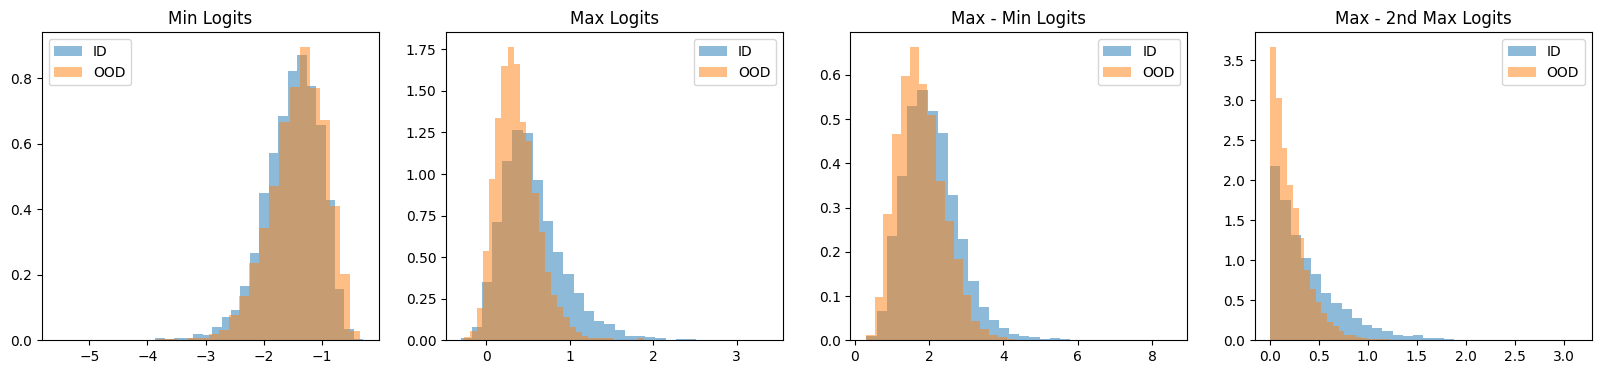

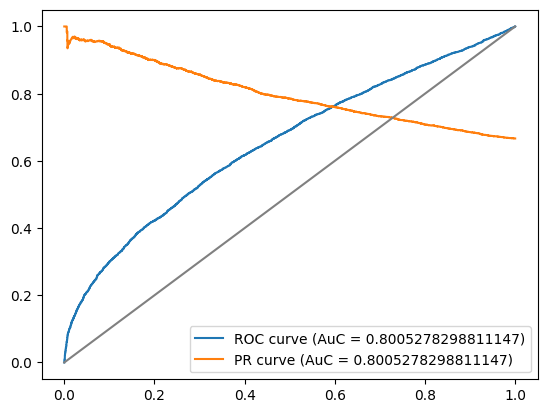

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


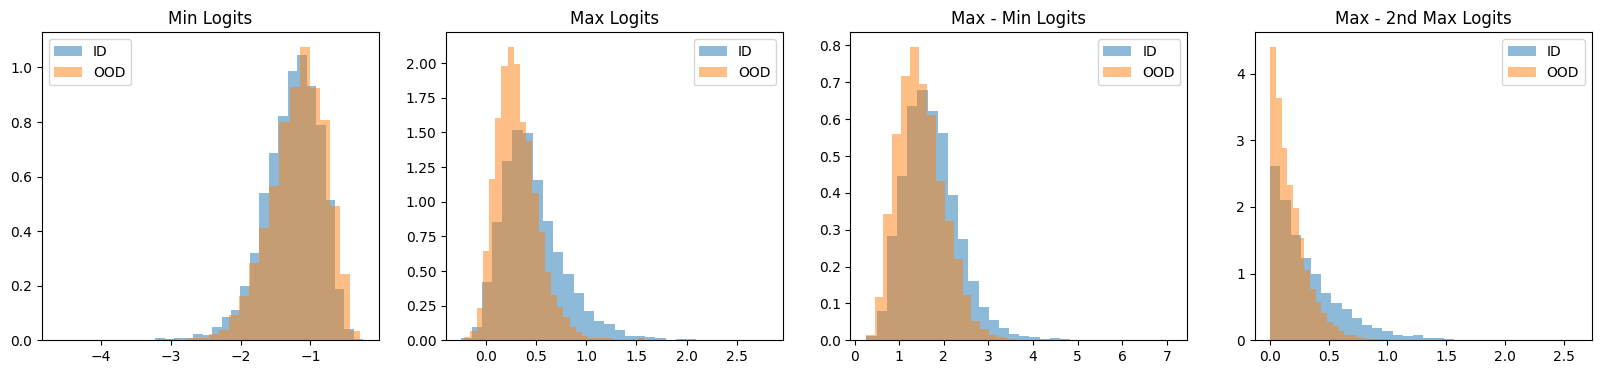

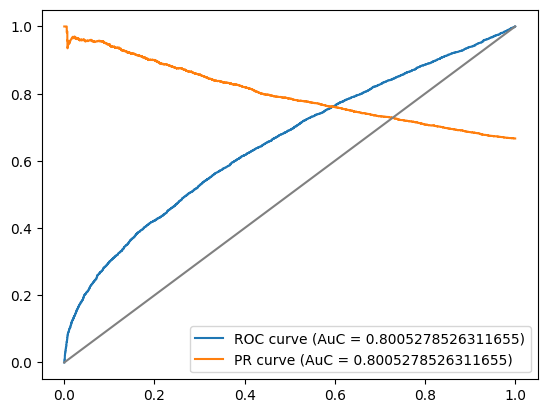

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


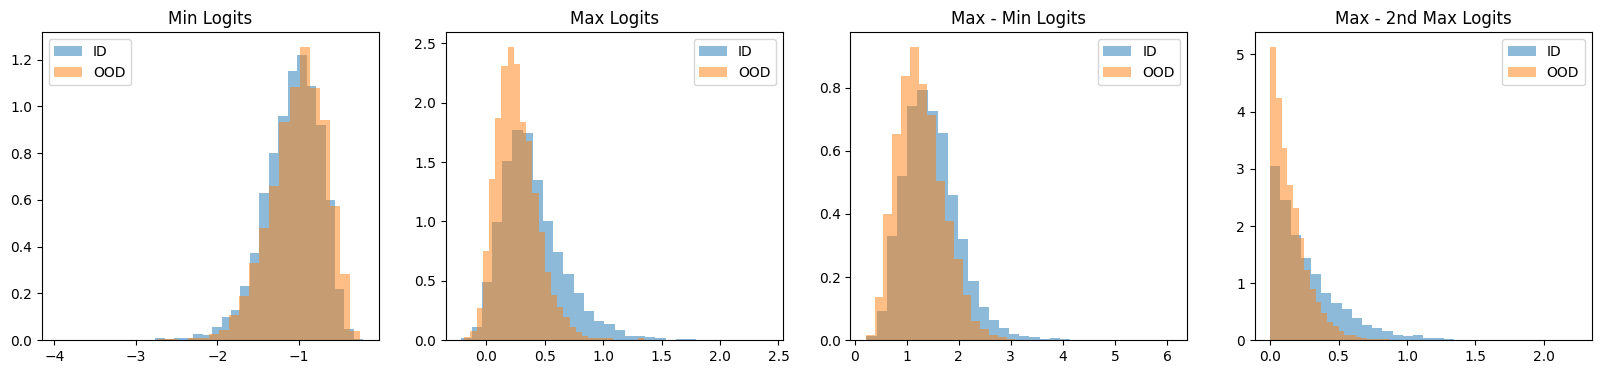

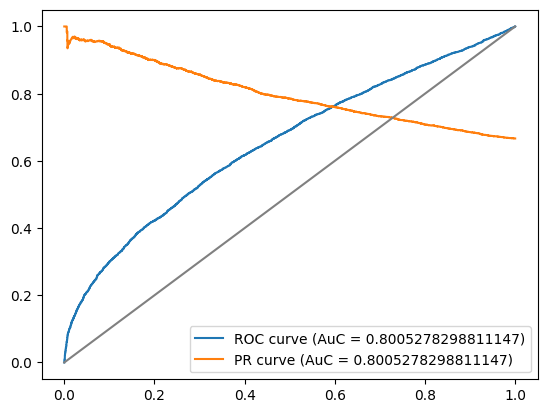

Loss Train = 0.937609107446409, Loss Val = 1.280155236163038, Acc = 0.6248


Loss Train = 0.5863970879880777, Loss Val = 1.0656759099757418, Acc = 0.6715333333333333


Loss Train = 0.3635030065746586, Loss Val = 1.020124019714112, Acc = 0.6513333333333333


Loss Train = 0.24730296048865238, Loss Val = 0.9999512936206574, Acc = 0.658


Loss Train = 0.19535601940653005, Loss Val = 1.034439835142582, Acc = 0.6491333333333333


Loss Train = 0.16235422998516935, Loss Val = 1.0960280136859164, Acc = 0.6412


/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


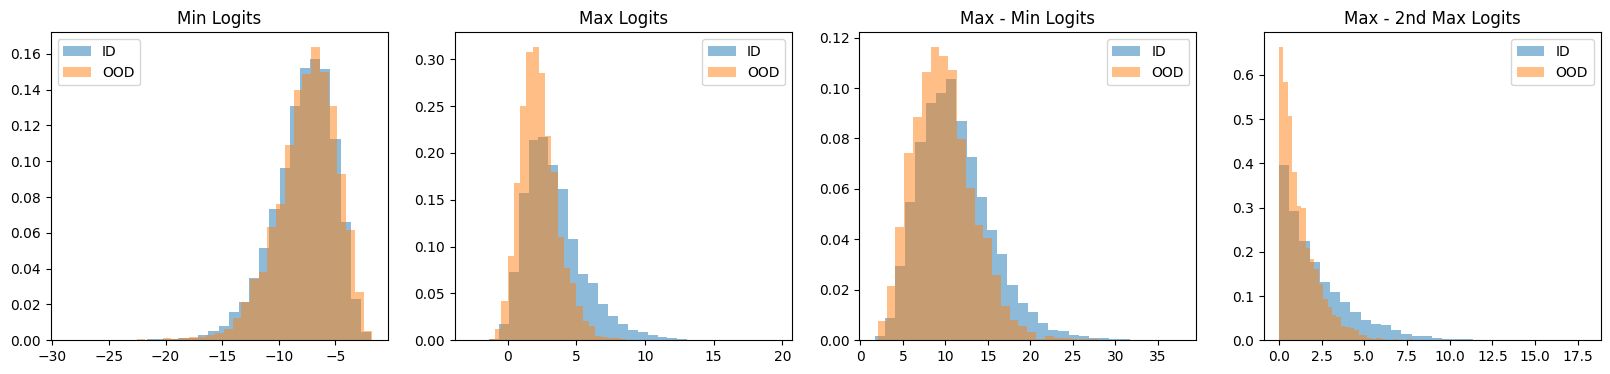

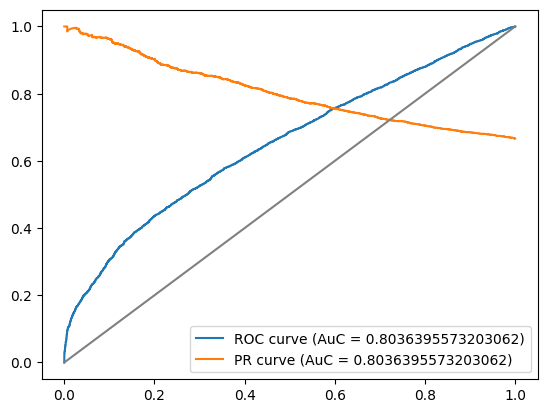

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


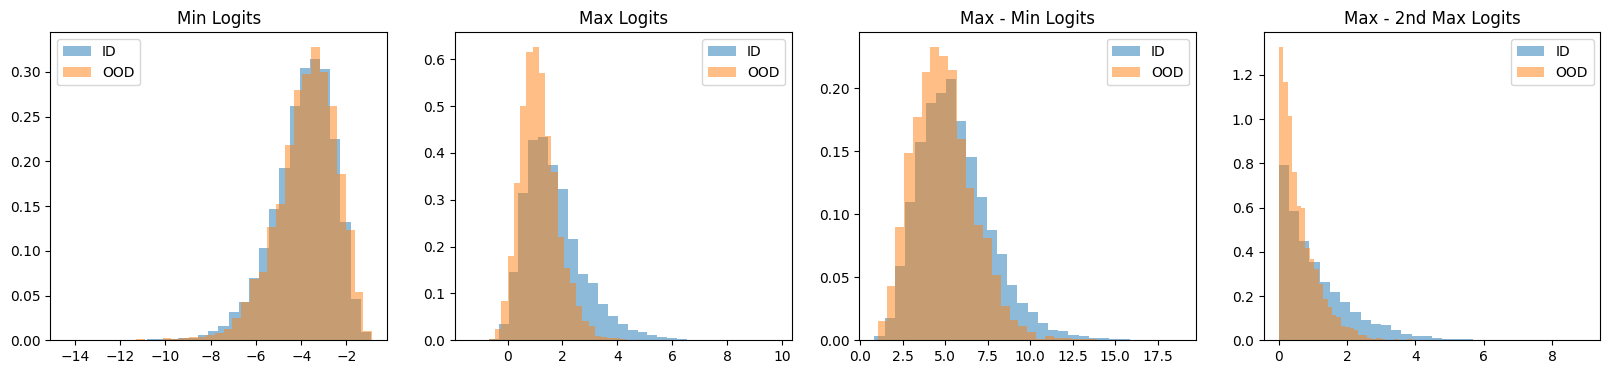

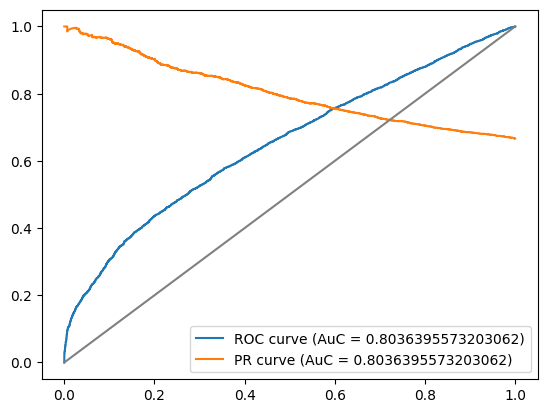

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


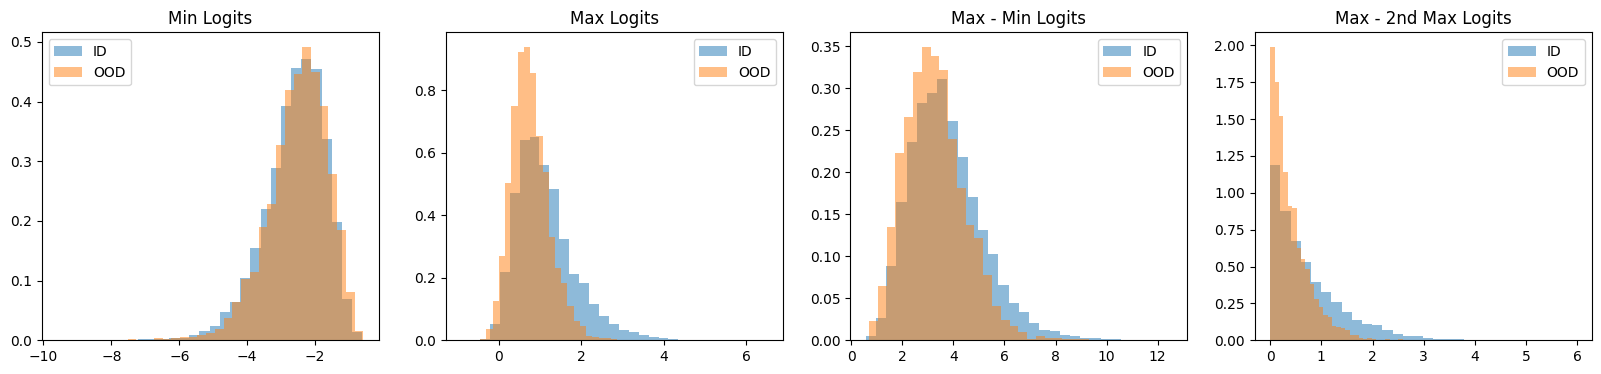

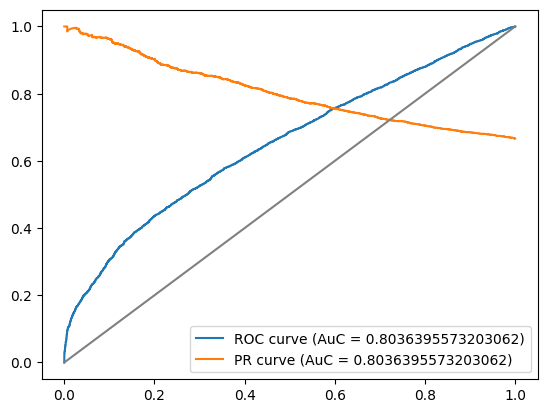

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


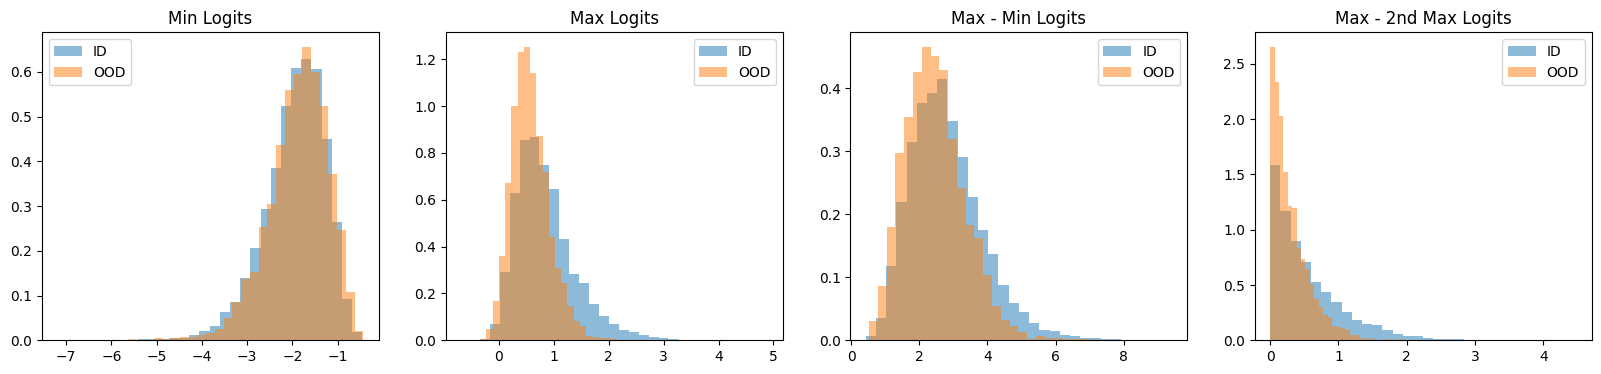

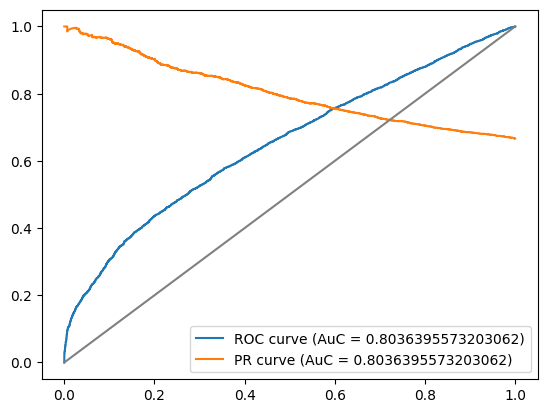

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


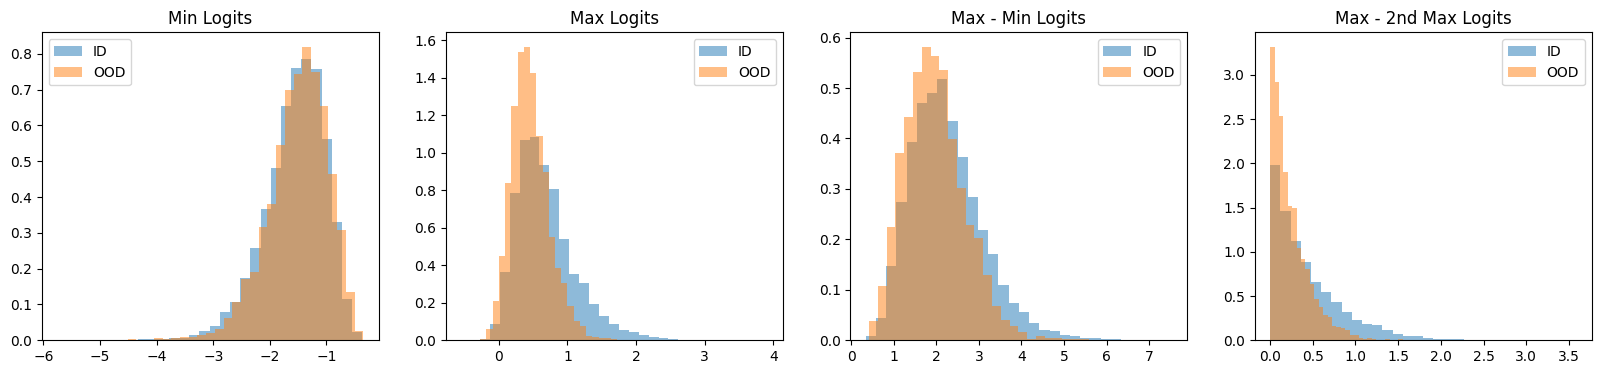

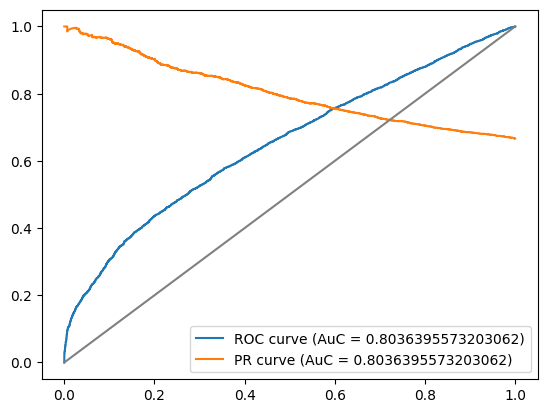

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


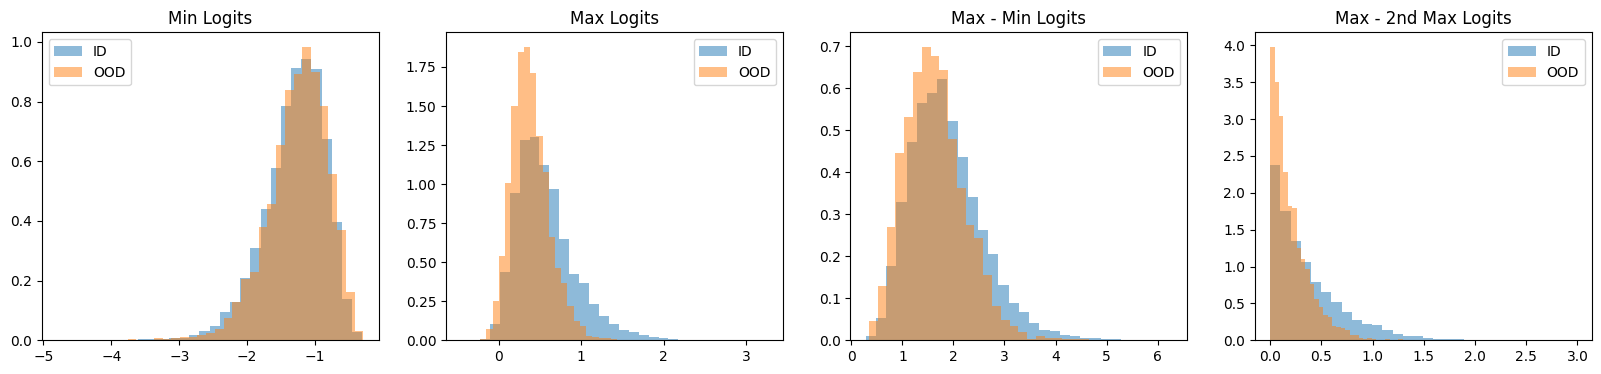

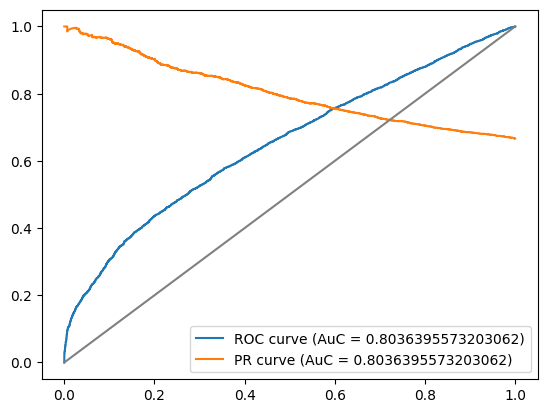

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


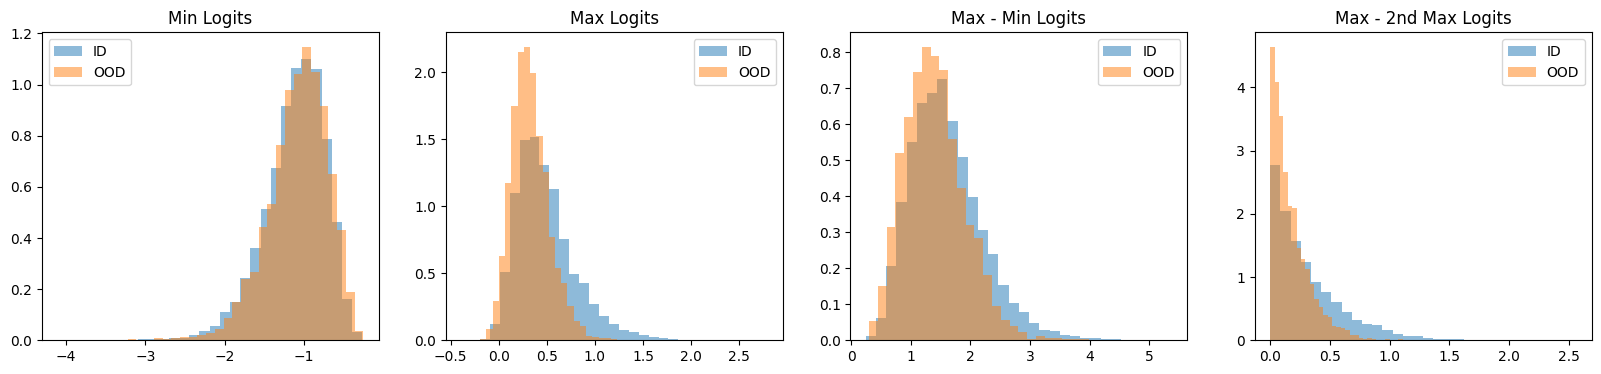

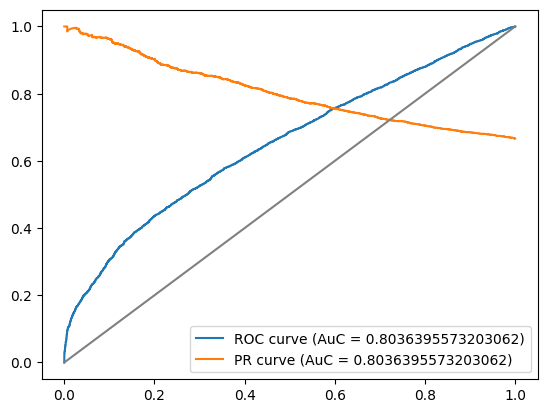

Loss Train = 0.9248058939764661, Loss Val = 1.2323835055878822, Acc = 0.6316666666666667


Loss Train = 0.5583361157878444, Loss Val = 1.0301371835647746, Acc = 0.6710666666666667


Loss Train = 0.3195787887250702, Loss Val = 0.975883324602817, Acc = 0.6666


Loss Train = 0.21460596029348739, Loss Val = 0.9966006235873446, Acc = 0.6632


Loss Train = 0.16274768366415387, Loss Val = 1.0446417428077535, Acc = 0.6572


Loss Train = 0.1475932263484875, Loss Val = 1.036480061297721, Acc = 0.6596666666666666


/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


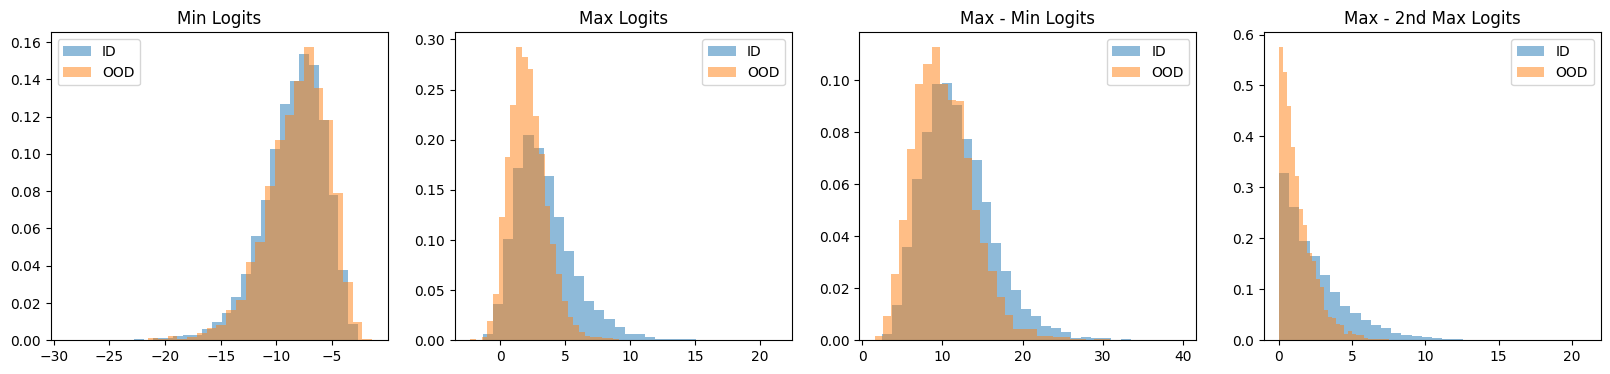

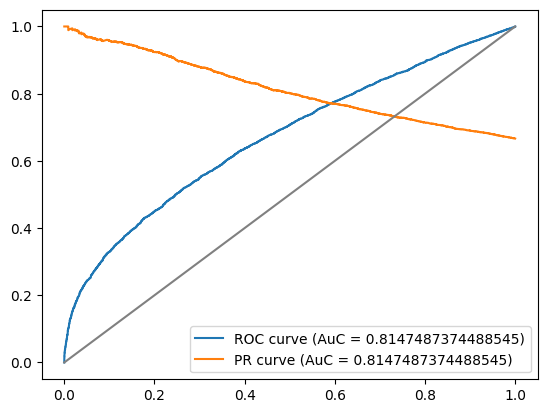

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


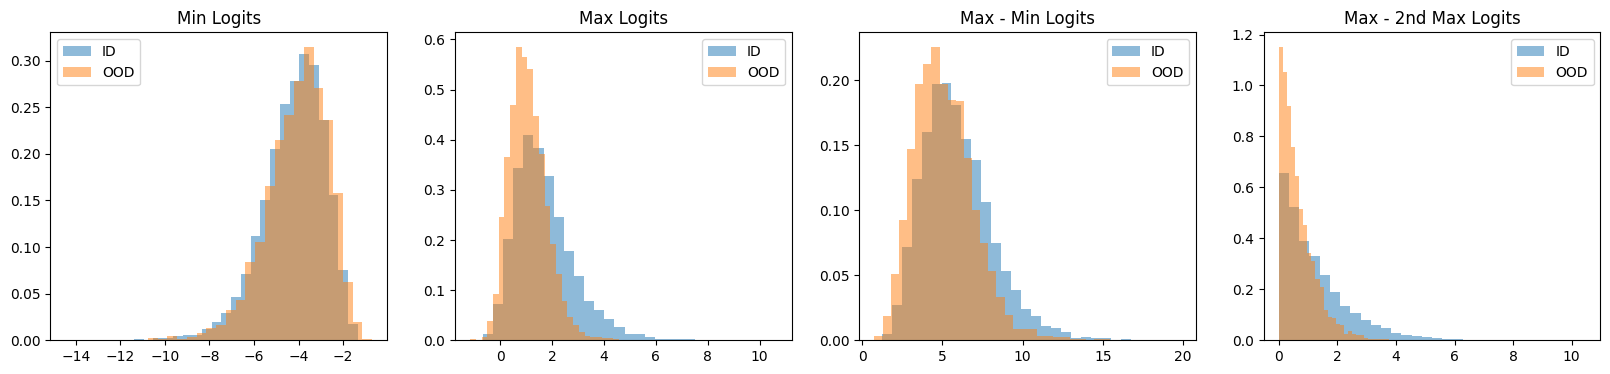

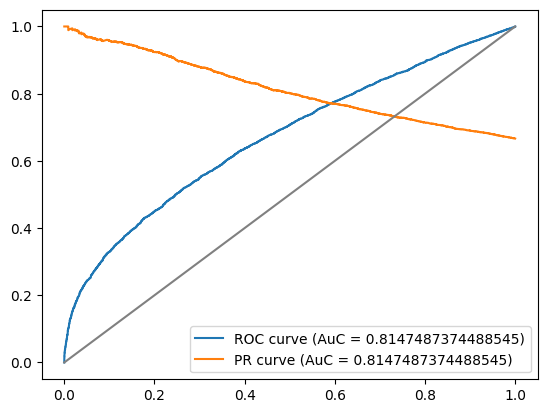

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


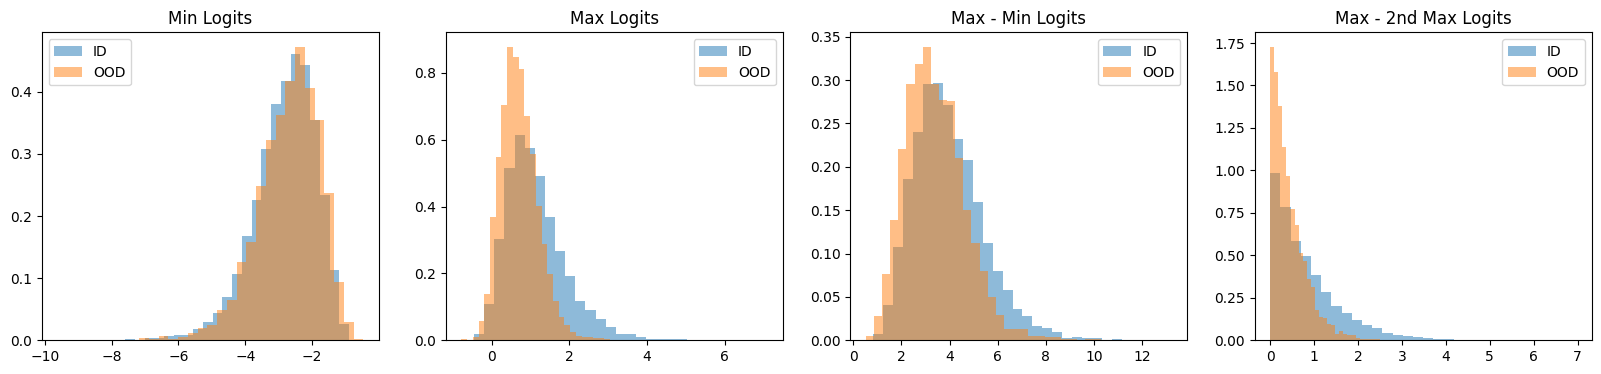

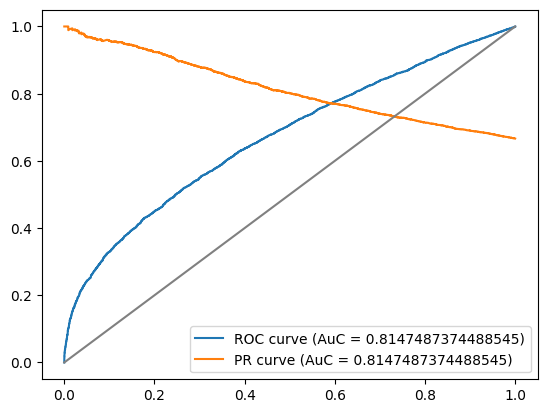

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


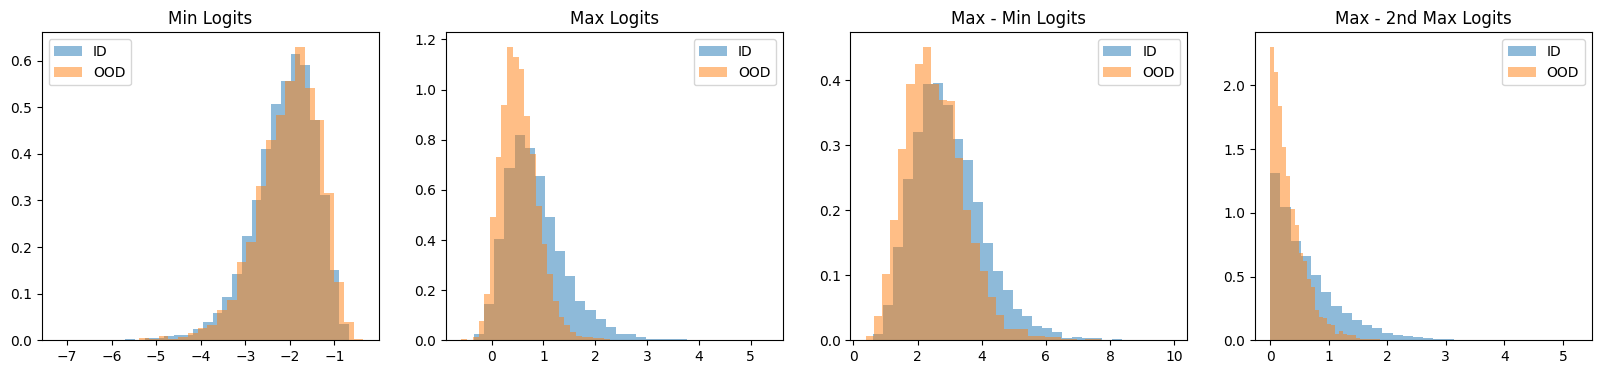

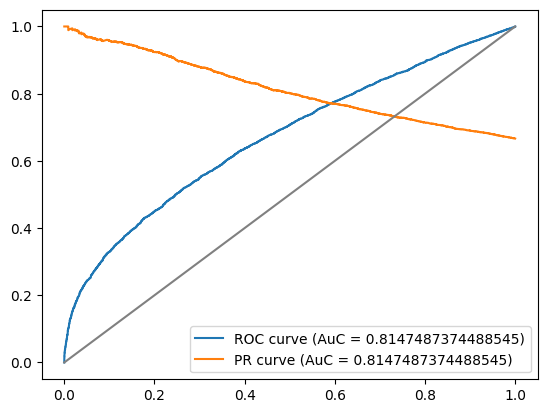

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


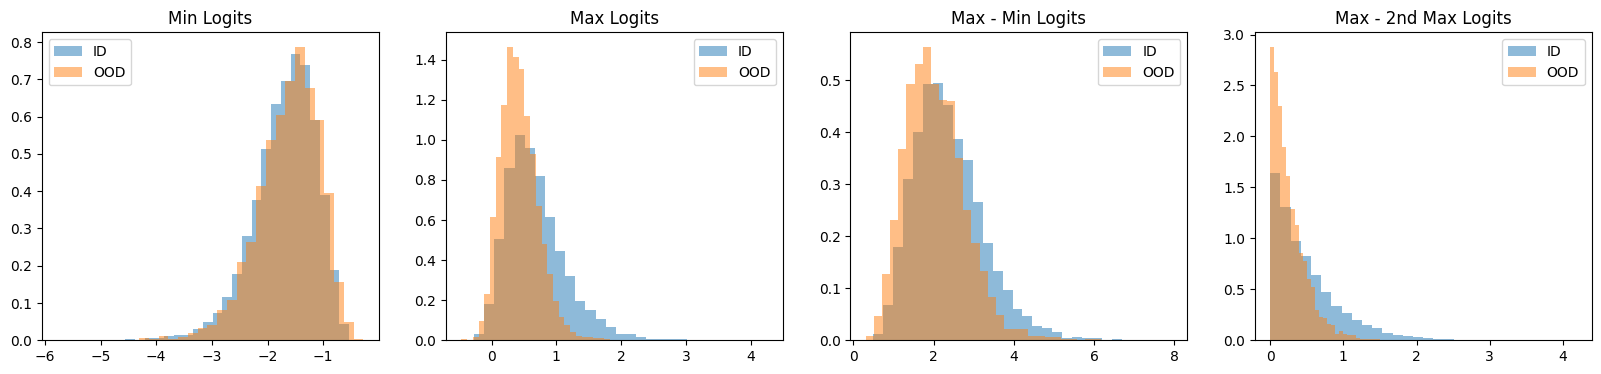

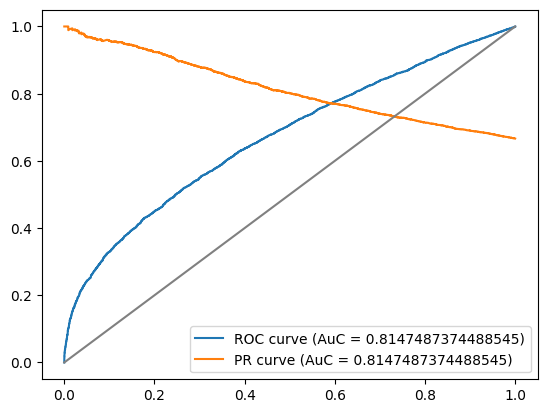

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


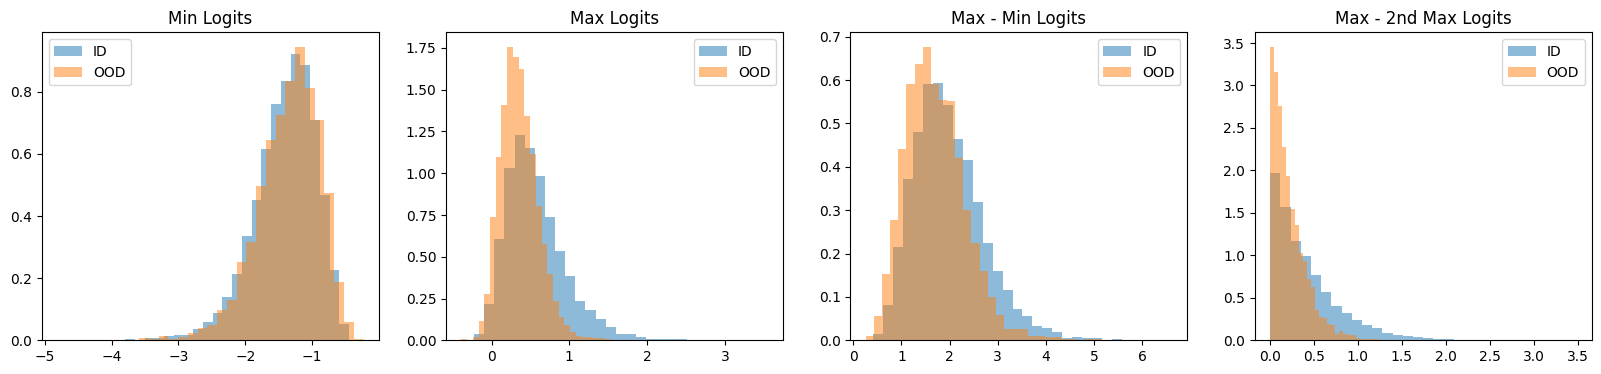

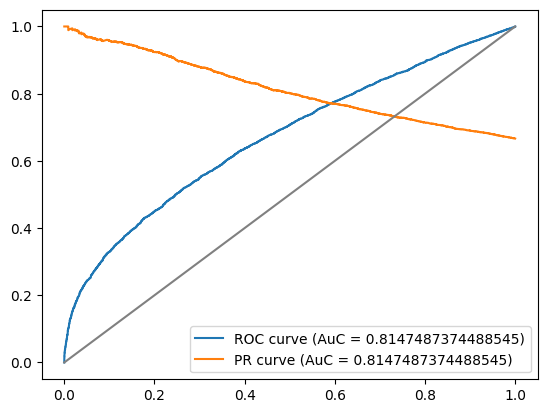

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


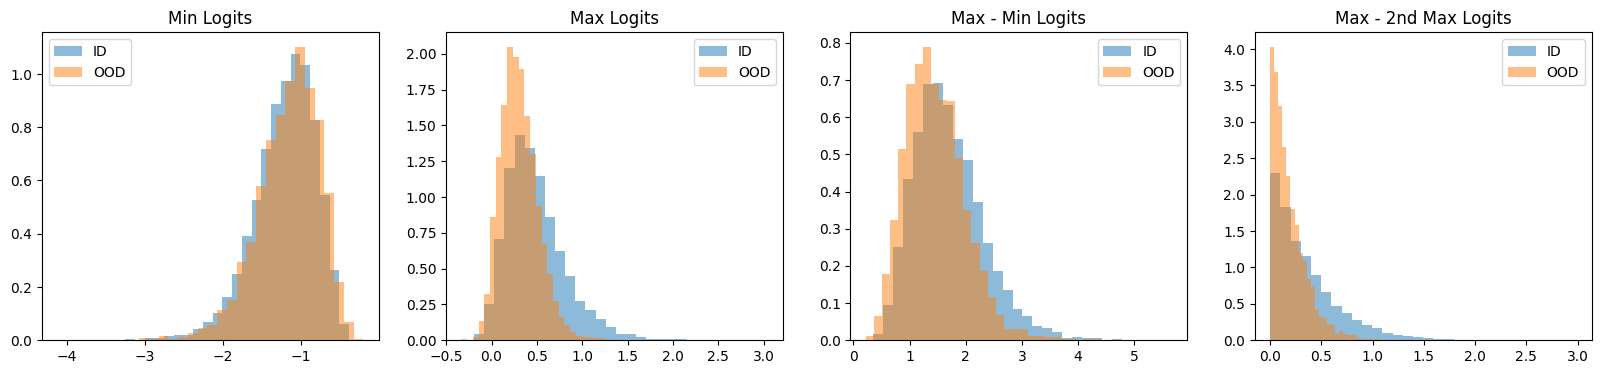

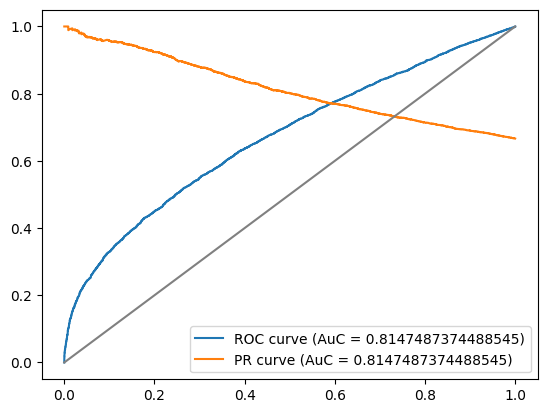

Loss Train = 0.9598877340609674, Loss Val = 1.3134470802672367, Acc = 0.6086666666666667


Loss Train = 0.6082164239839837, Loss Val = 1.102762860947467, Acc = 0.6389333333333334


Loss Train = 0.3629790003219078, Loss Val = 1.0506863134972593, Acc = 0.6408666666666667


Loss Train = 0.2516602928966447, Loss Val = 1.0001194550635968, Acc = 0.6546666666666666


Loss Train = 0.19273171951173645, Loss Val = 1.0394182689646456, Acc = 0.6485333333333333


Loss Train = 0.1607274317014043, Loss Val = 1.095620547710581, Acc = 0.6391333333333333


/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


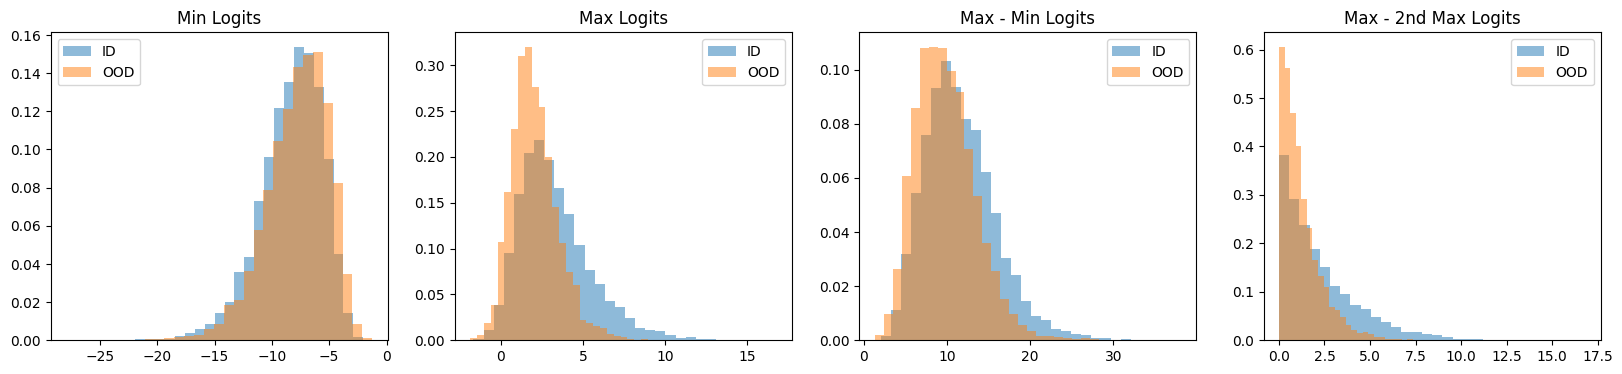

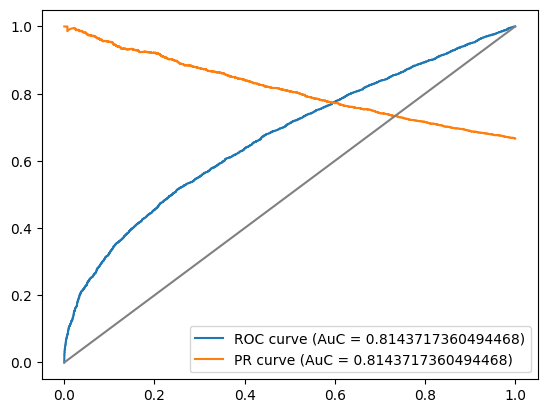

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


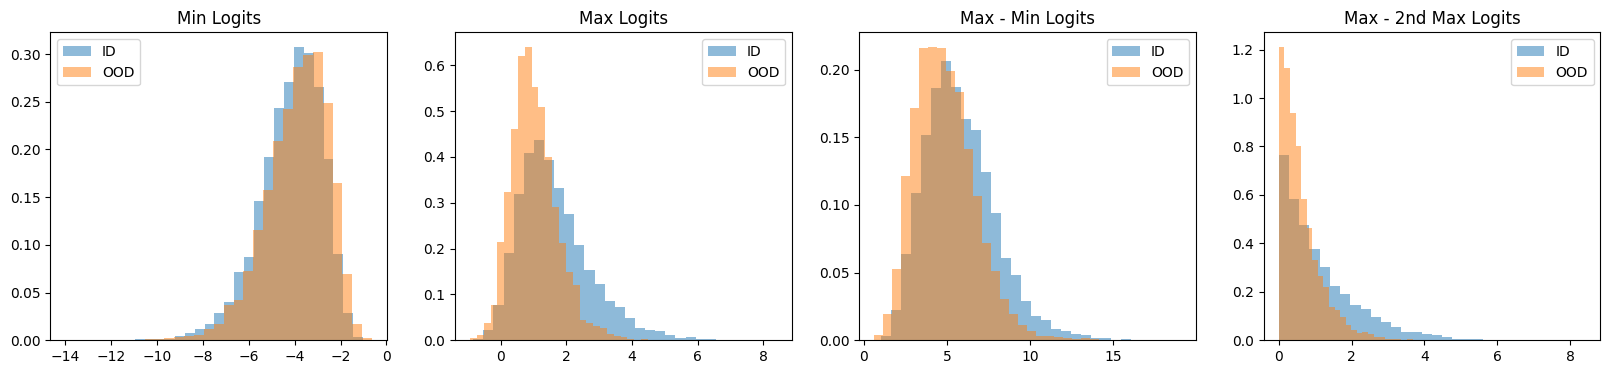

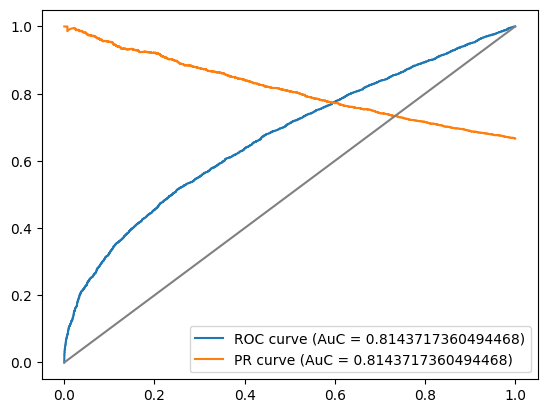

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


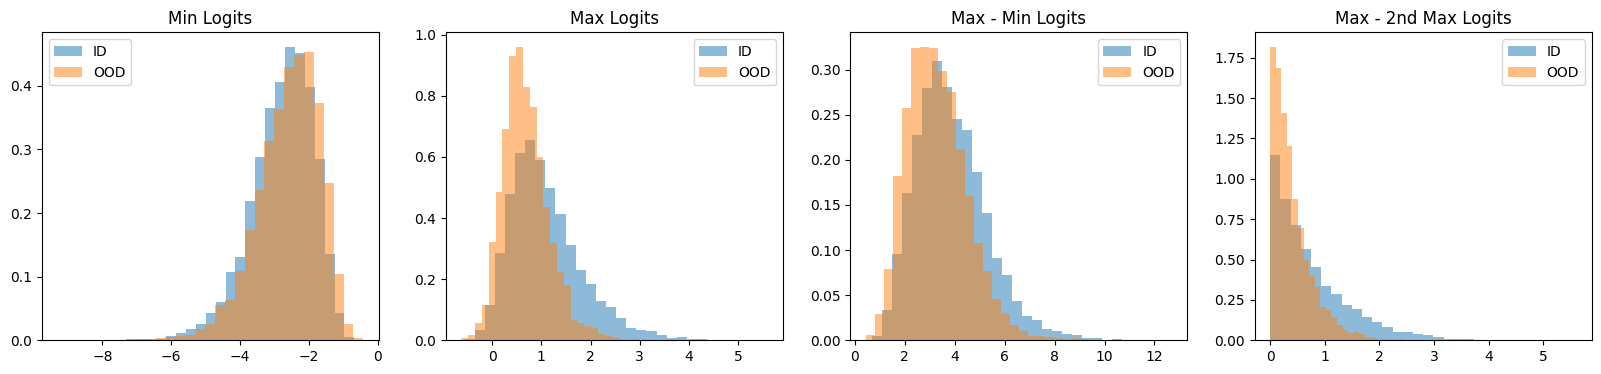

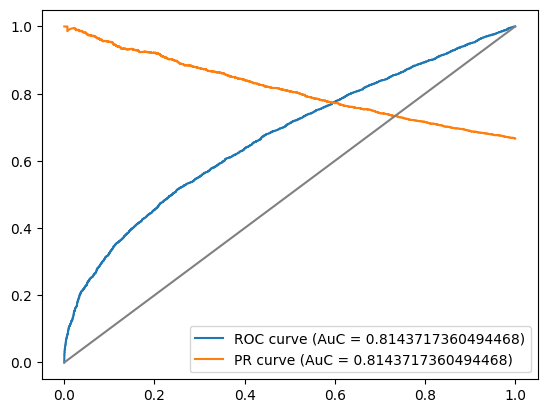

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


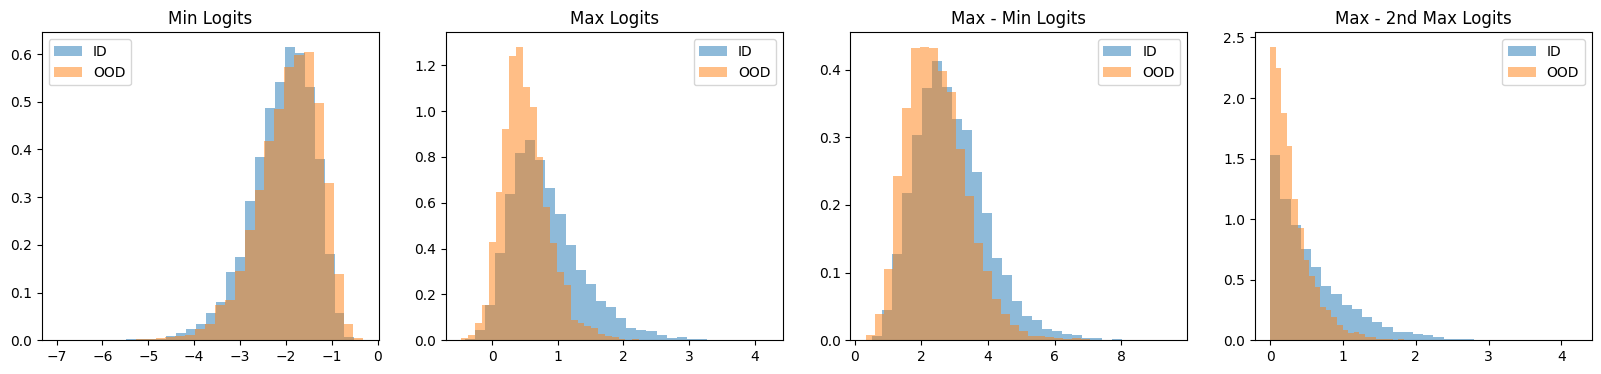

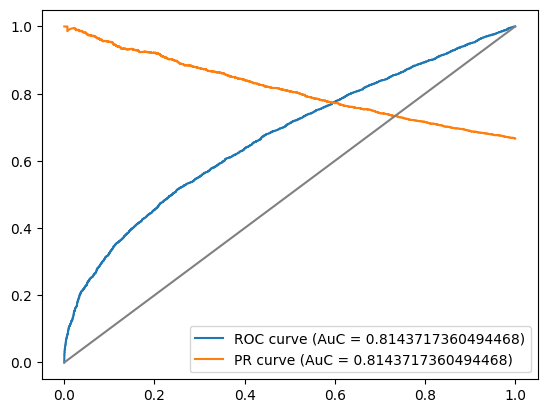

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


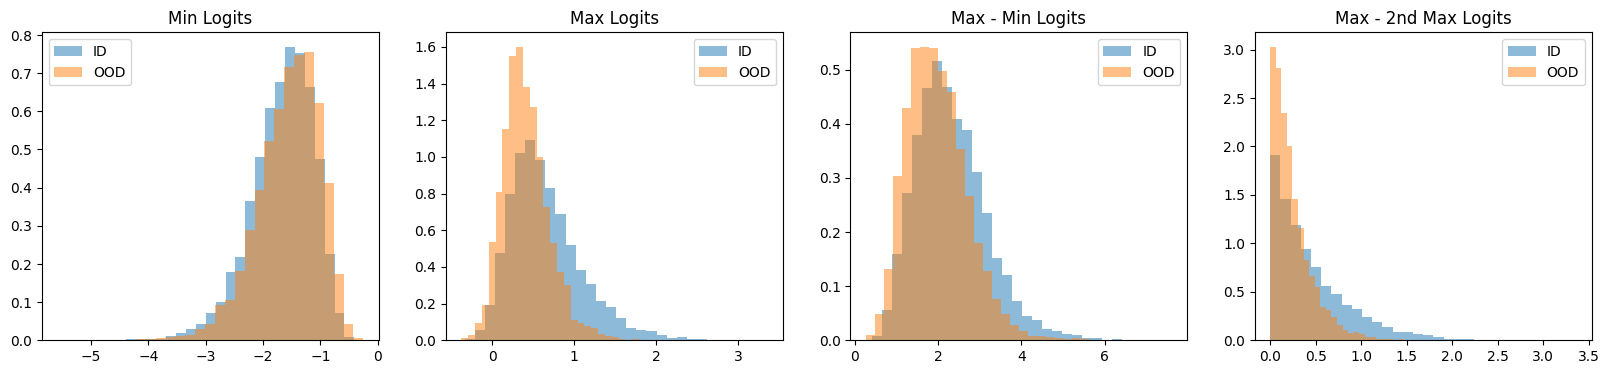

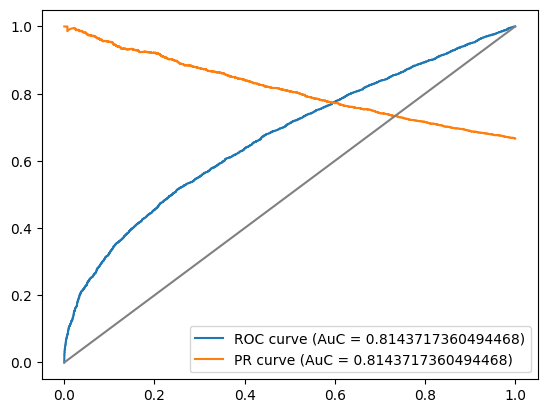

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


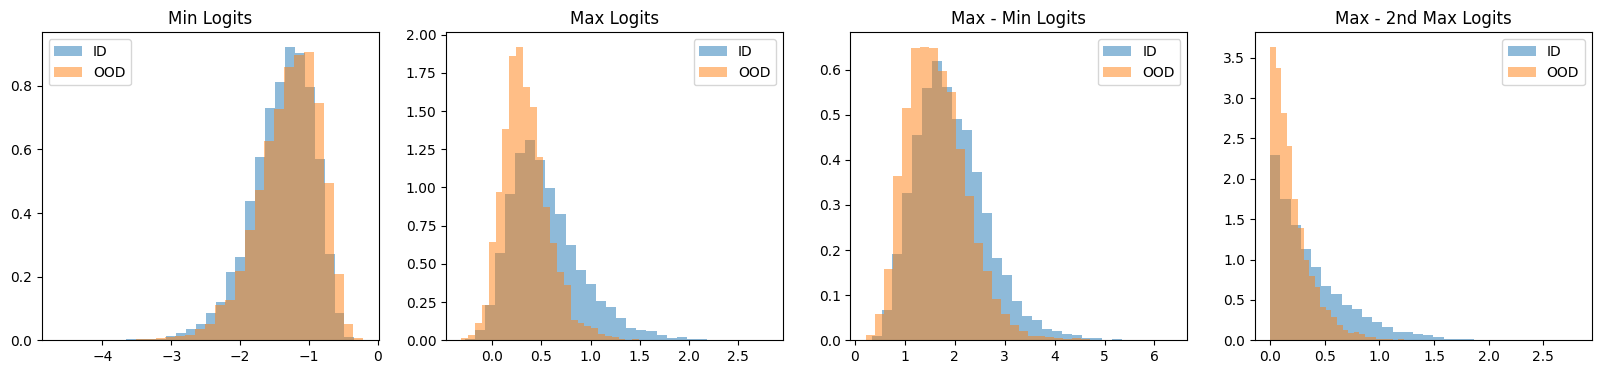

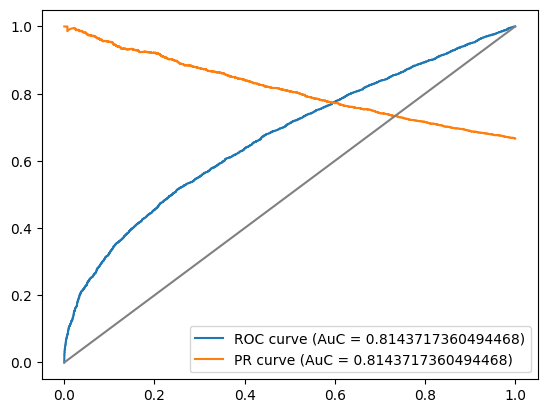

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


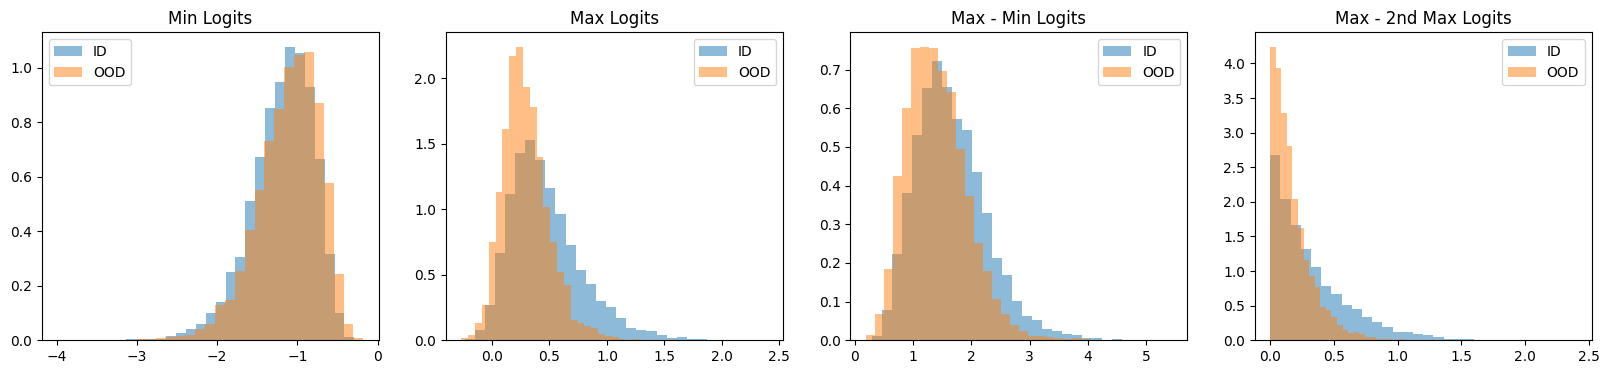

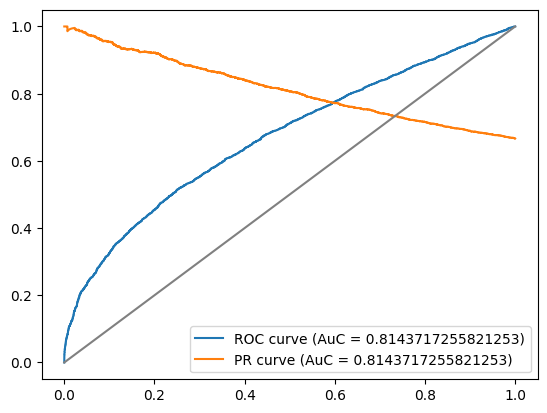

Loss Train = 0.9934021994008443, Loss Val = 1.3109151601791382, Acc = 0.6248666666666667


Loss Train = 0.6450843704792874, Loss Val = 1.0687516182026964, Acc = 0.6696666666666666


Loss Train = 0.41835265501761565, Loss Val = 1.0149729926535425, Acc = 0.6601333333333333


Loss Train = 0.2966856442977567, Loss Val = 1.0200303059943179, Acc = 0.6546


Loss Train = 0.23093372512561094, Loss Val = 1.0097618455582478, Acc = 0.6588666666666667


Loss Train = 0.2061312111806281, Loss Val = 1.029740633609447, Acc = 0.6550666666666667


/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


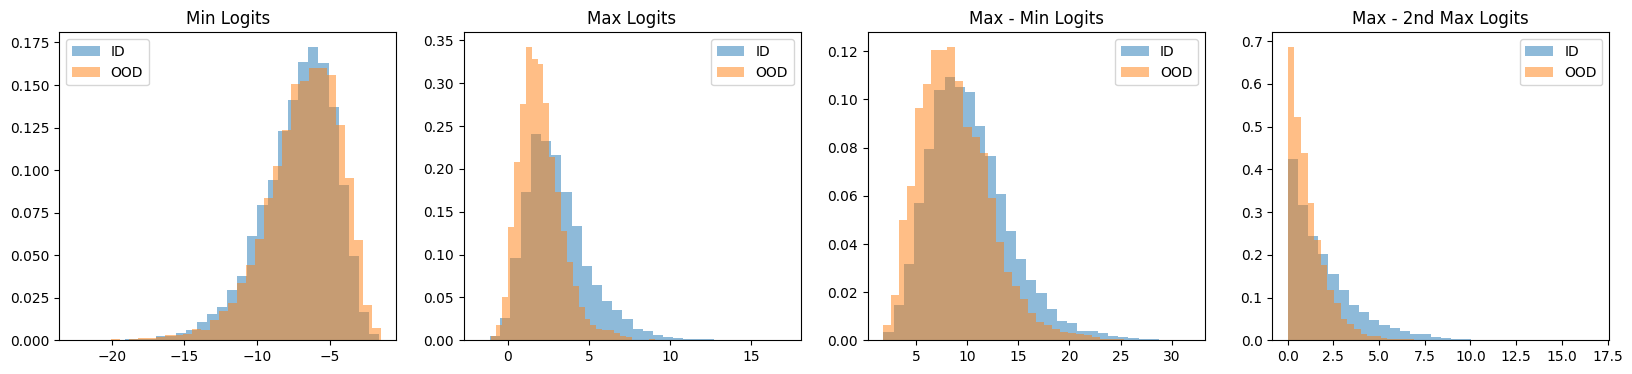

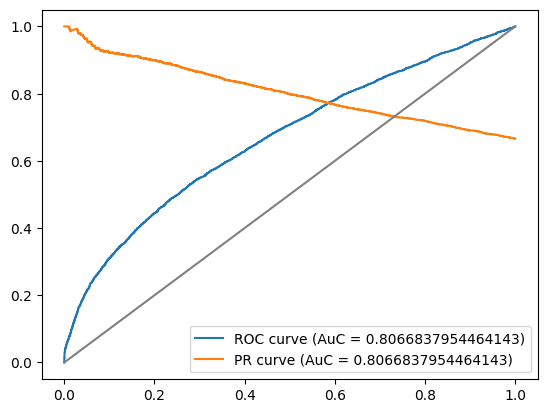

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


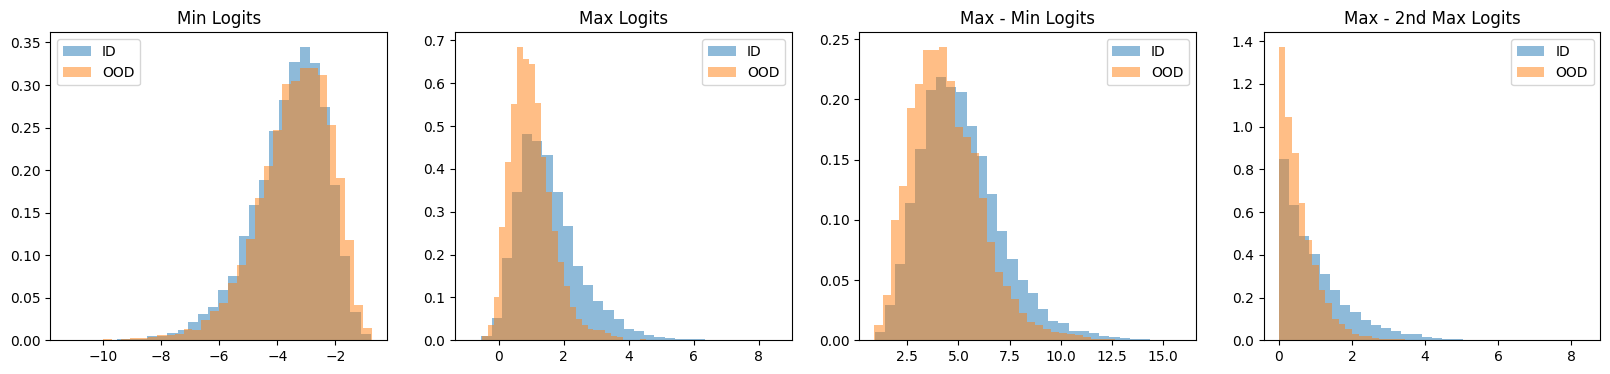

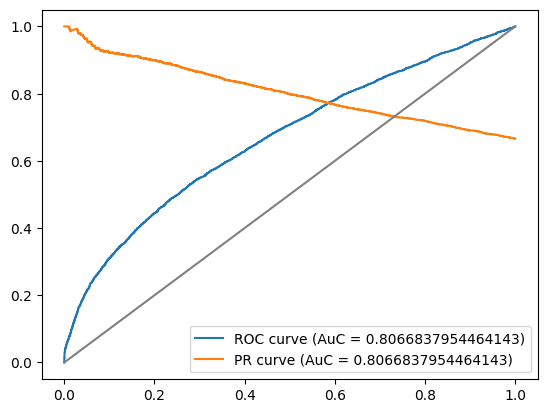

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


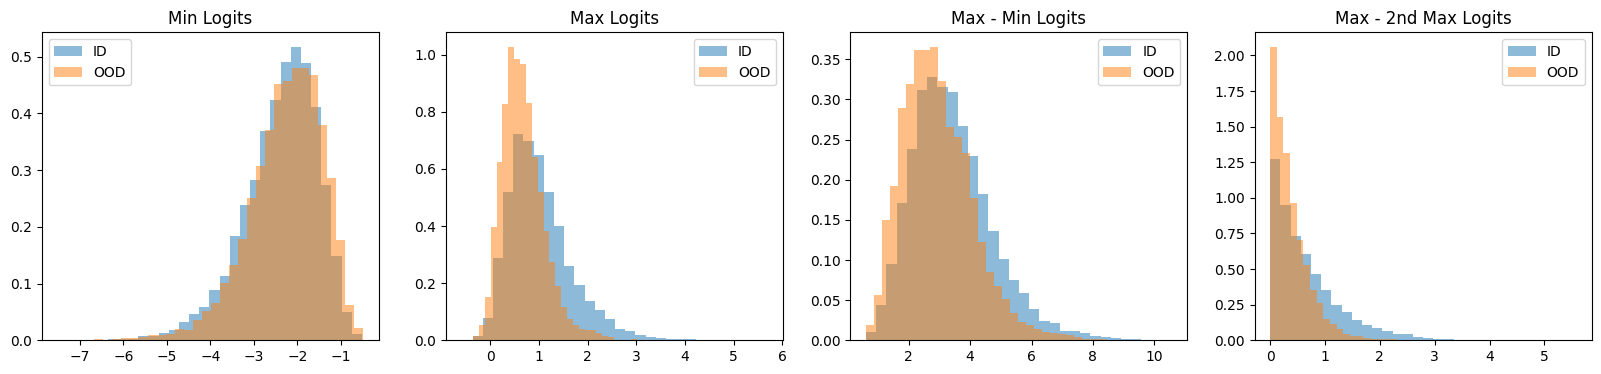

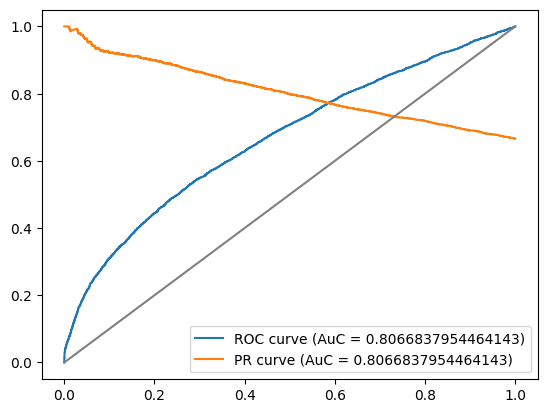

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


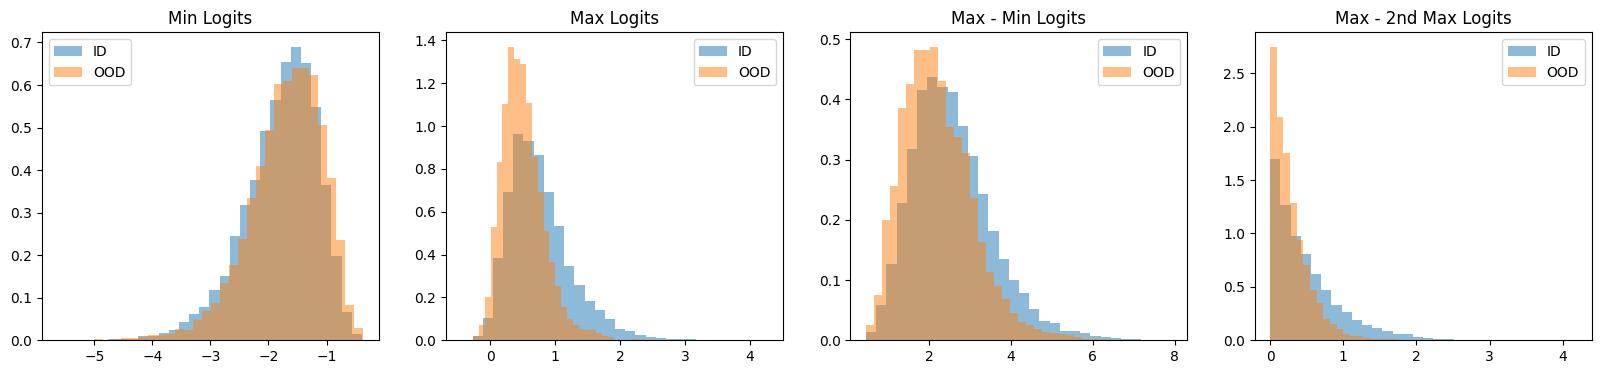

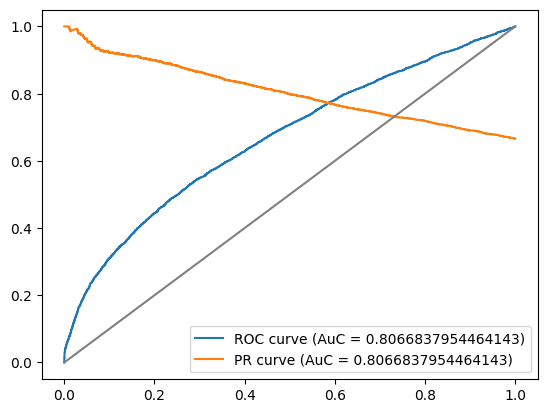

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


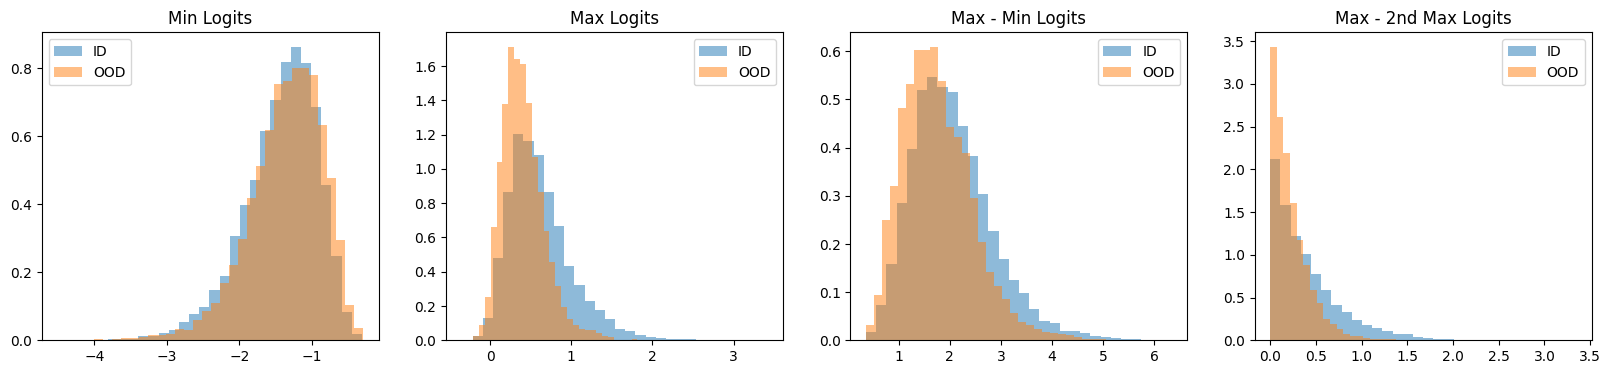

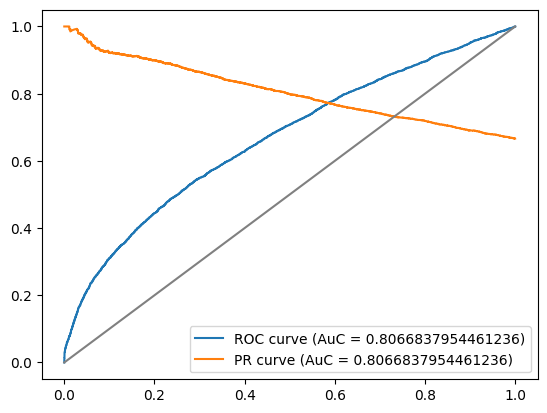

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


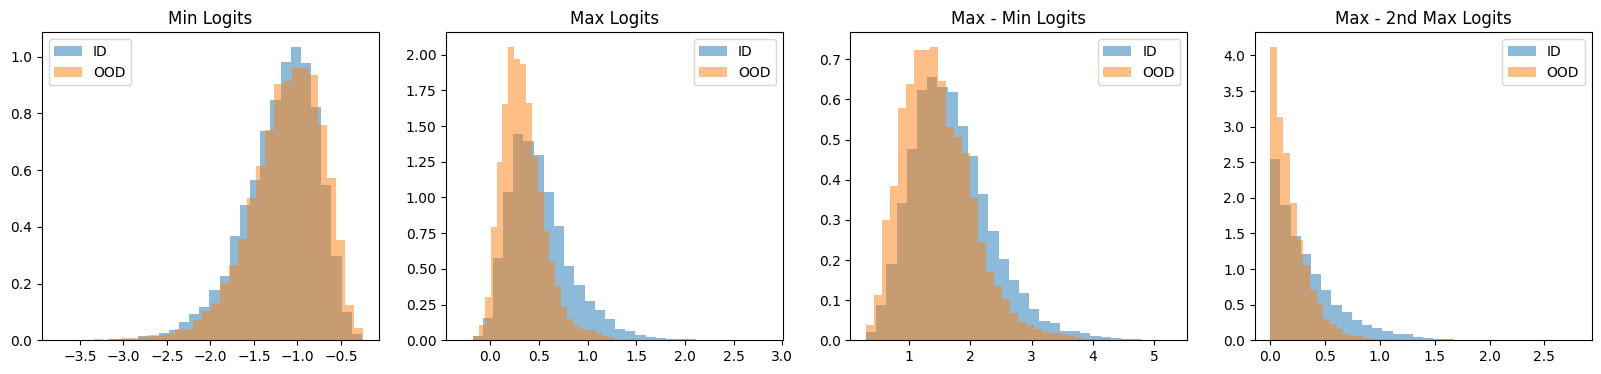

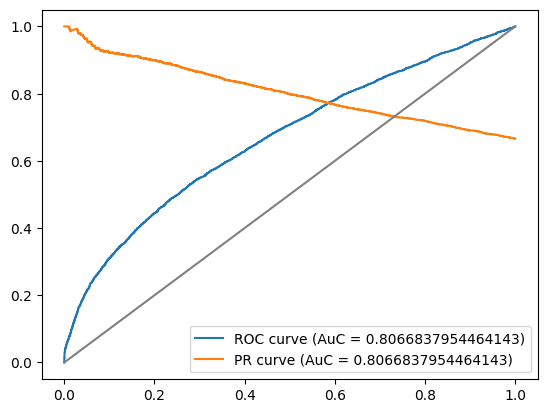

/tmp/ipykernel_13669/1539728995.py:53: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


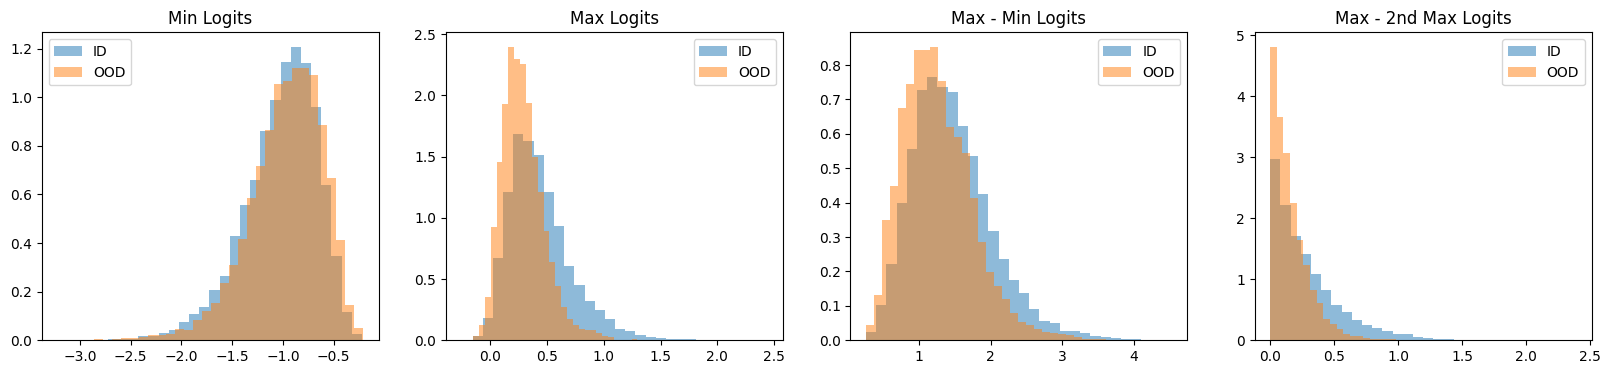

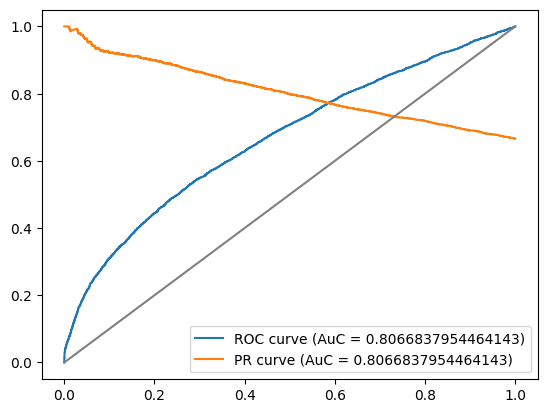

In [39]:
temperatures = [i for i in range(1, 8)]
cols = len(temperatures)
epsilons = [.05 * i for i in range(4, 17)]
loss = F.cross_entropy
for eps in epsilons:
    odin_model = CifarClassifierWithODIN(n_classes).to(device)
    optimizer = torch.optim.Adam(odin_model.parameters(), lr=0.001)
    _, _ = training(odin_model, dl_train, dl_val, loss, optimizer, epochs, 5, False)
    for c, T in enumerate(temperatures):
        plot_hists(odin_model, dl_test, dl_ood, T)
        plot_curves(odin_model, dl_test, dl_ood, T)